# **Modélisation par régression linéaire**

**API SKL** : [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

**Guide SKL** : [**Ordinary Least Squares** (1.1.1)](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

**Résout** : $\min_{w} || X w - y||_2^2$

**Complexité** : $\mathcal{O}(n p^2)$


## Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)
# display(data)

✔ _data loaded
✔ struct loaded


## Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

## Préparation des données pour la modélisation

Le premier `get_ml_data(data)` retournait la juxtaposition fixe suivante d'ensembles de données : `bid`, `pid`, `x`, `y`, `z`, `t`, `a_scale`, `ei_ad`, `u_ad`, `ies_wn`, `ies`, `ie_wn`, `ie`, `ie_e`, `ie_s`, `ie_g`, `_1000_ih`.

Certaines variables étaient biaisées, comme `bid` et `pid` qui sont de naïfs et *hérétiques* encodages de libellés de `BuildingType` et de `PrimaryPropertyType`.

Pour la nouvelle version, plus *flexible*, nous :
1. même plan de spécification de noms de variables courts et proches de leur expression $\LaTeX$, avec éventuellement des variables synthétiques supplémentaires que le feature engineering pourrait faire émerger.
2. encodage à chaud systématique des variables catégorielles.
3. moyen pratique de définir divers sous-ensembles de variables (suivant un mode qui cherche à se rapprocher du langage de formules [`patsy`](https://patsy.readthedocs.io/en/latest/)).

# Expérimentation

## Config 1 : $g = f(a)$

Ensemble minimal.

$\{a : g\}$

Cela nous donne une première performance *baseline*.

Elle est inférieure de 0,0827388301 à celle obtenue sur la cible $e$.

$R^2_{1, \text{OLS}} \left(\{a : g\}\right)$ :
* $\mu = 0.2633858597214695$
* $\sigma = 0.16993461331808574$

Pour comparaison :

$R^2_{1, \text{OLS}} \left(\{a : e\}\right)$ :
* $\mu = 0.34612468985020617$
* $\sigma = 0.15269182507734183$

#### Jeu de données

In [3]:
config_name = "{a : g}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

a          g
id                      
1       88434   249980.0
2      103566   295860.0
3      956110  2089280.0
5       61320   286430.0
8      175580   505010.0
...       ...        ...
50221   18261    20330.0
50223   16000    32170.0
50224   13157   223540.0
50225   14101    22110.0
50226   18258    41270.0

[3193 rows x 2 columns]

#### Visualisation

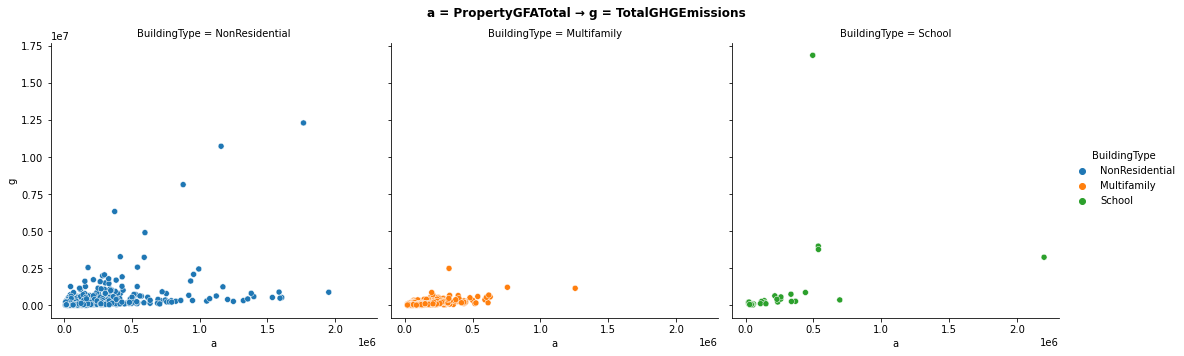

In [5]:
from seattle_commons import get_abstract_btype, plot_ml_data
btype = get_abstract_btype(data)   # hue labels
plot_ml_data(ml_data, btype=btype,
             x='a', y='g',
             title="a = PropertyGFATotal → g = TotalGHGEmissions"
)

#### Vérifications

L'ensemble des valeurs des $a$ et de $e$ sont positives, on peut donc appliquer la régression NNLS ([**Non-negative least squares**](https://scikit-learn.org/stable/auto_examples/linear_model/plot_nnls.html#sphx-glr-auto-examples-linear-model-plot-nnls-py)).

In [6]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [7]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.11555763815691467
 OLS R2 score 0.11555763815691455
features : ['a']
intercept (ols) : [-60412.94335401]
intercept (nnls) : [-60412.94335401]
coefficients (ols) : [[1.96676112]]
coefficients (nnls) : [[1.96676112]]


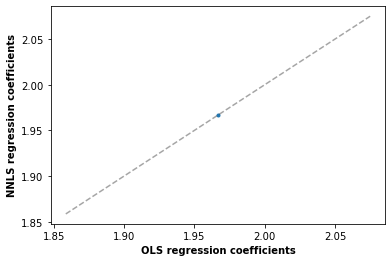

In [8]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [9]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.2918926680377112
SM OLS R2 score 0.11555763815691467
                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     328.1
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           1.14e-61
Time:                        08:00:09   Log-Likelihood:                -11544.
No. Observations:                 798   AIC:                         2.309e+04
Df Residuals:                     796   BIC:                         2.310e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

#### Validation croisée du score OLS

In [10]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.15364604 0.50341661 0.13309493]
mean scores : 0.2633858597214695
std scores : 0.16993461331808574


## Config 2 : $g = f(a, \tilde{a_i}, \tilde{a_o})$

$\{\tilde{a_i}, \tilde{a_o} a, : g\}$

Premier élargissement avec l'ajout des proportions relatives de surface intérieure / extérieure.

On vérifie en outre :
* qu'il n'y a pas de NA,
* que les coefficients sont tous positifs.

Les performances se dégradent légèrement de 0.00680617456 à comparer à la dégradation du même ordre sur la cible $e$ (0,00502634837).

$R^2_{2, \text{OLS}} \left(\{\tilde{a_i}, \tilde{a_o}, a : g\}\right)$ :
* $\mu = 0.25657968516337576$
* $\sigma = 0.16407328531365872$ 

Pour comparaison :

$R^2_{1, \text{OLS}} \left(\{a : g\}\right)$ :
* $\mu = 0.2633858597214695$
* $\sigma = 0.16993461331808574$

$R^2_{2, \text{OLS}} \left(\{\tilde{a_i}, \tilde{a_o}, a : e\}\right)$ :
* $\mu = 0.341098341484052$
* $\sigma = 0.153097888182222$

$R^2_{1, \text{OLS}} \left(\{a : e\}\right)$ :
* $\mu = 0.34612468985020617$
* $\sigma = 0.15269182507734183$

#### Jeu de données

In [11]:
config_name = "{_a_i, _a_o, a : g}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

_a_i      _a_o       a          g
id                                          
1      1.000000  0.000000   88434   249980.0
2      0.854547  0.145453  103566   295860.0
3      0.794252  0.205748  956110  2089280.0
5      1.000000  0.000000   61320   286430.0
8      0.646885  0.353115  175580   505010.0
...         ...       ...     ...        ...
50221  1.000000  0.000000   18261    20330.0
50223  1.000000  0.000000   16000    32170.0
50224  1.000000  0.000000   13157   223540.0
50225  1.000000  0.000000   14101    22110.0
50226  1.000000  0.000000   18258    41270.0

[3193 rows x 4 columns]

#### Visualisation

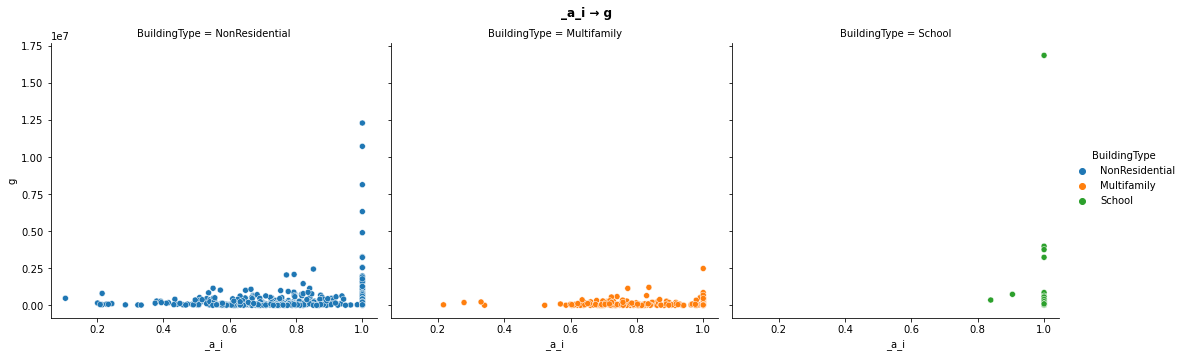

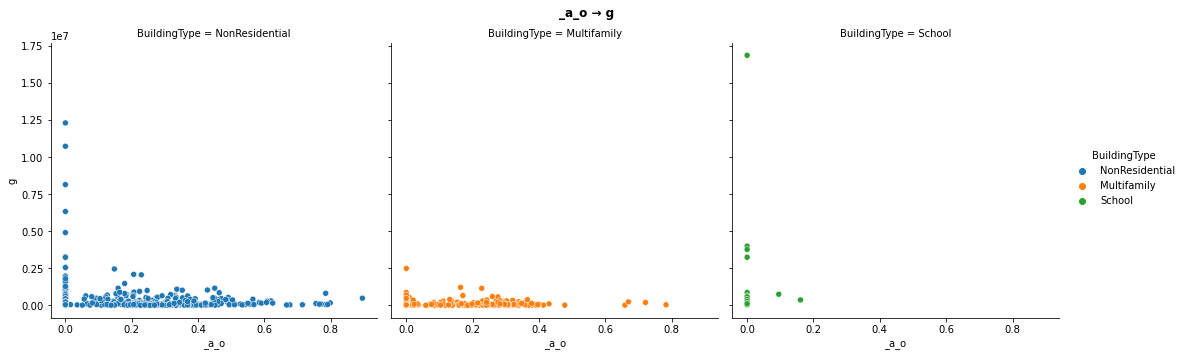

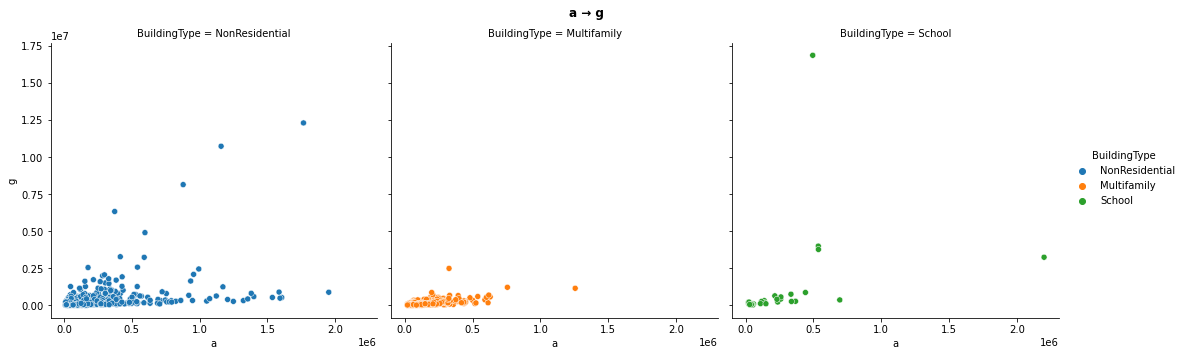

In [12]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [13]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [14]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.11170802818084158
 OLS R2 score 0.11170802818187542
features : ['_a_i' '_a_o' 'a']
intercept (ols) : [-351163.60729561]
intercept (nnls) : [-654075.71835594]
coefficients (ols) : [[ 3.02912111e+05 -3.02912111e+05  2.09459751e+00]]
coefficients (nnls) : [[6.05824222e+05 0.00000000e+00 2.09459751e+00]]


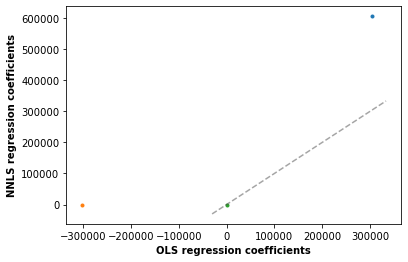

In [15]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

* même $\beta_1$ (`a`), à 5 chiffres significatifs
* $\beta_0$ (`intercept_`) de même signe et ordre de grandeur, mais avec décalé de 50 %
* idem avec $\beta_2$ (`_a_i`) et $\beta_3$ (`_a_e`)
* des $p$-values $\le$ à 0,05, et =0,05 pour le seul $\beta_2$ (`_a_i`)
* je ne sais pas interpréter $t$, ni les autres indicateurs (sauf le $R^2$)
* La plus petite valeur propre est 2,56e-30. Cela pourrait indiquer qu'il y a de forts problèmes de multicolinéarité ou que la matrice de conception est singulière ⇒ il me semble que la cause principale est que les coefficients (`a`) dominent les deux autres.

C'est cette dernière conclusion qui motive de basculer sur l'intensité de la consommation plutôt que la consommation en volume. Dans un premier temps, on ne travaille qu'avec les deux surfaces relatives `_a_i` et `_a_e`, puis on réintroduit le facteur d'échelle `asc` qui est le logarithme de `a`.

In [16]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.30577124124824184
SM OLS R2 score 0.11170802817927084
                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     175.1
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           9.94e-64
Time:                        08:10:46   Log-Likelihood:                -11536.
No. Observations:                 798   AIC:                         2.308e+04
Df Residuals:                     795   BIC:                         2.309e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

#### Validation croisée du score OLS

In [17]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.15709241 0.48786334 0.12478331]
mean scores : 0.25657968516337576
std scores : 0.16407328531365872


## Config 3 : $g = f(\tilde{a_i}, \tilde{a_o})$

Intensité de la consommation en fonction des proportions relatives de surfaces intérieure et extérieure.

$\{\tilde{a_i}, \tilde{a_o} :g\}$

Sans intérêt, la performance est moindre que celle d'un tirage aléatoire.

$R^2_{1, \text{OLS}} \left(\{\tilde{a_i}, \tilde{a_o} : g\}\right)$ :
* $\mu = -0.06142832697590276$
* $\sigma = 0.05008360981388441$ 

Rappel pour comparaison :

$R^2_{1, \text{OLS}} \left(\{\tilde{a_i}, \tilde{a_o} : ie\}\right)$ :
* $\mu = -0.01777427213941755$
* $\sigma = 0.0052747752634359595$

#### Jeu de données

In [18]:
config_name = "{_a_i, _a_o : g}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

_a_i      _a_o          g
id                                  
1      1.000000  0.000000   249980.0
2      0.854547  0.145453   295860.0
3      0.794252  0.205748  2089280.0
5      1.000000  0.000000   286430.0
8      0.646885  0.353115   505010.0
...         ...       ...        ...
50221  1.000000  0.000000    20330.0
50223  1.000000  0.000000    32170.0
50224  1.000000  0.000000   223540.0
50225  1.000000  0.000000    22110.0
50226  1.000000  0.000000    41270.0

[3193 rows x 3 columns]

#### Visualisation

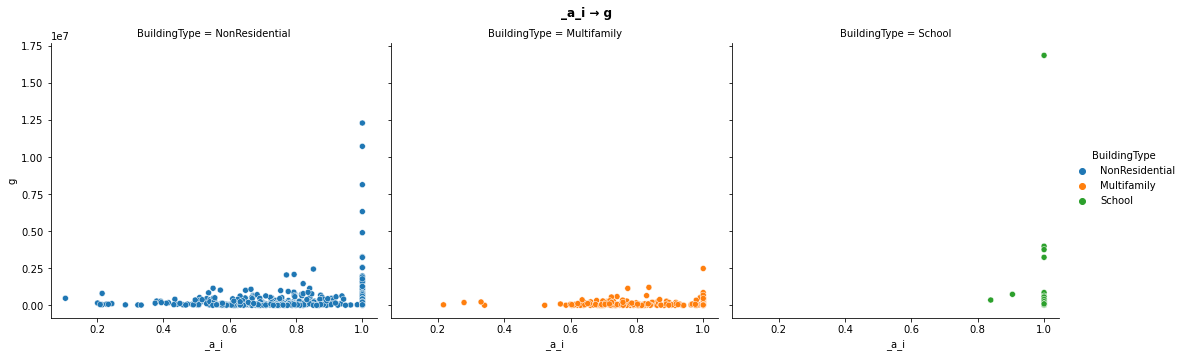

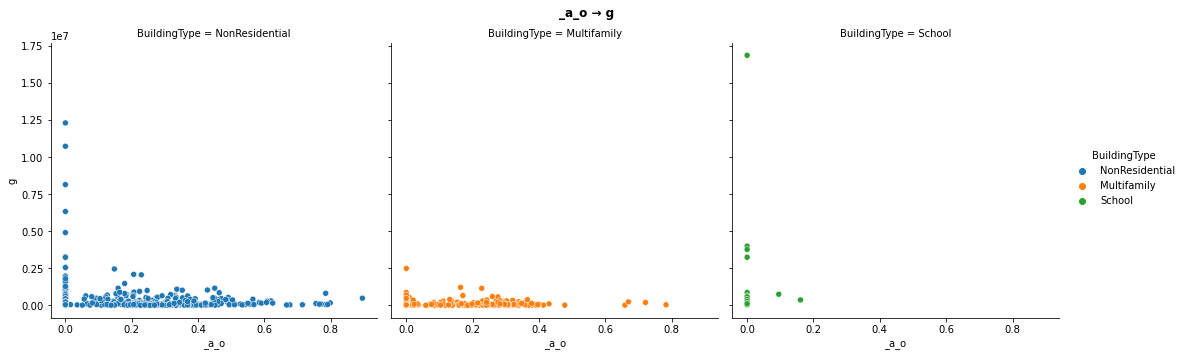

In [19]:
# title="_a_i = Building's relative inner floor area → ie = SiteEUI(kBtu/sf)"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [20]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [21]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.0009098083468255247
 OLS R2 score 0.0009284841959847911
features : ['_a_i' '_a_o']
intercept (ols) : [-7.39025538e+18]
intercept (nnls) : [110169.2828339]
coefficients (ols) : [[7.39025538e+18 7.39025538e+18]]
coefficients (nnls) : [[     0.         204216.04294147]]


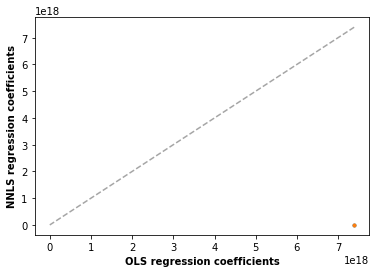

In [22]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [23]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.001717123373344398
SM OLS R2 score 0.0009098083468255247
                            OLS Regression Results                            
Dep. Variable:                      g   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.369
Date:                Mon, 14 Nov 2022   Prob (F-statistic):              0.242
Time:                        08:13:01   Log-Likelihood:                -11681.
No. Observations:                 798   AIC:                         2.337e+04
Df Residuals:                     796   BIC:                         2.338e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### Validation croisée du score OLS

In [24]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [-0.02277203 -0.13215511 -0.02935784]
mean scores : -0.06142832697590276
std scores : 0.05008360981388441


## Config 4 : $\ln{g} = f(\ln{a})$

$\{\log(a) : \log(g)\}$

Gain important de 0,0829536975, mais moins significatif que celui de 0,222145739 obtenu sur la cible $e$.

$R^2_{4, \text{OLS}} \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

Rappel pour comparaison :

$R^2_{1, \text{OLS}} \left(\{a : g\}\right)$ :
* $\mu = 0.2633858597214695$
* $\sigma = 0.16993461331808574$

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [128]:
config_name = "{log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

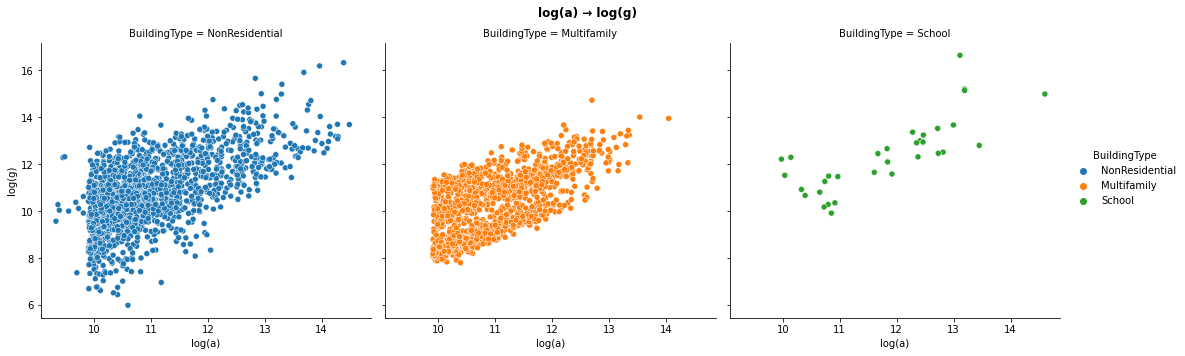

In [26]:
# title="log(a = PropertyGFATotal) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [27]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [28]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.3998451438746614
 OLS R2 score 0.3998451438746614
features : ['log(a)']
intercept (ols) : [-1.08005518]
intercept (nnls) : [-1.08005518]
coefficients (ols) : [[1.05246203]]
coefficients (nnls) : [[1.05246203]]


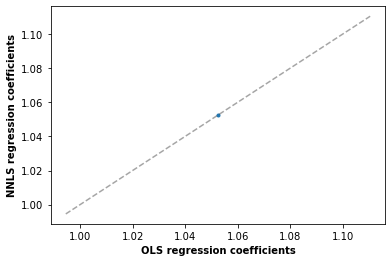

In [29]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [30]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.39536760438181195
SM OLS R2 score 0.3998451438746612
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     520.5
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           4.85e-89
Time:                        08:15:31   Log-Likelihood:                -1228.0
No. Observations:                 798   AIC:                             2460.
Df Residuals:                     796   BIC:                             2469.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

#### Validation croisée du score OLS

In [31]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.42687679 0.27570463 0.33643725]
mean scores : 0.3463395572103616
std scores : 0.06211171186045244


## Config 5 : $\ln{g} = f(\ln{a_i})$

$\{\log(a_i) : \log(g)\}$

Le but est de confirmer l'intuition que la surface totale est moins pertinente que la surface intérieure prise seule.

Cette intuition était trompeuse : la surface totale est plus pertinente que la seule surface intérieure.

$R^2_4 \left(\{\log(a_i) : \log(g)\}\right)$:
* $\mu = 0.33530492742634427$
* $\sigma = 0.05662428283457976$

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_4 \left(\{\log(a_i):\log(e)\}\right)$:
* $\mu = 0.5358488752194961$
* $\sigma = 0.048844016950912963$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [32]:
config_name = "{log(a_i) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

log(a_i)     log(g)
id                         
1      11.390012  12.429136
2      11.390780  12.597642
3      13.540273  14.552330
5      11.023861  12.565249
8      11.640263  13.132334
...          ...        ...
50221   9.812523   9.919853
50223   9.680344  10.378790
50224   9.484709  12.317346
50225   9.554001  10.003785
50226   9.812359  10.627891

[3193 rows x 2 columns]

#### Visualisation

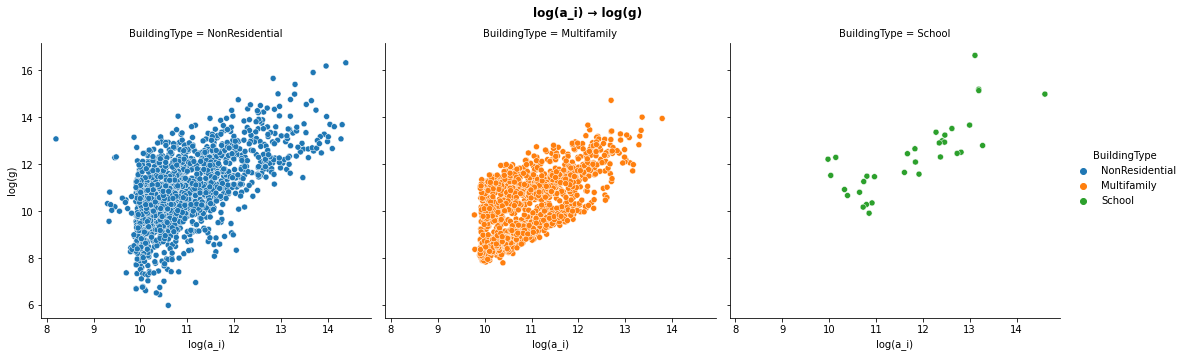

In [33]:
# title="log(a_i = PropertyGFABuilding(s)) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [34]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [35]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.39181766174695476
 OLS R2 score 0.39181766174695476
features : ['log(a_i)']
intercept (ols) : [-1.50209267]
intercept (nnls) : [-1.50209267]
coefficients (ols) : [[1.09620136]]
coefficients (nnls) : [[1.09620136]]


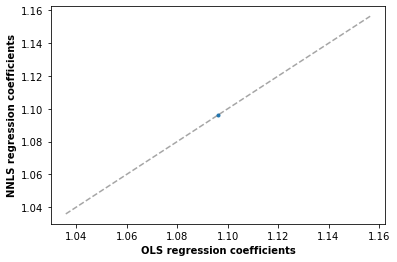

In [36]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [37]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.38899250465292734
SM OLS R2 score 0.39181766174695476
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     506.8
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           3.18e-87
Time:                        08:21:20   Log-Likelihood:                -1232.2
No. Observations:                 798   AIC:                             2468.
Df Residuals:                     796   BIC:                             2478.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

#### Validation croisée du score OLS

In [38]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.40940275 0.27195776 0.32455427]
mean scores : 0.33530492742634427
std scores : 0.05662428283457976


## Config 6 : $\ln{g} = f(\ln{a}, \ln{n_l})$ 

Evaluation de la contribution du nombre de niveaux `n_l` (nombres d'étages + 1).

$\{\log(n_l), \log(a) : \log(g)\}$

L'amélioration du score est marginale (gain < 0,01).

$R^2_6 \left(\{\log(n_l), \log(a) : \log(g)\}\right)$:
* $\mu = 0.35311666666845615$
* $\sigma = 0.05195488513038288$

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

#### Jeu de données

In [39]:
config_name = "{log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

log(n_l)     log(a)     log(g)
id                                   
1      2.564949  11.390012  12.429136
2      2.484907  11.547964  12.597642
3      3.737670  13.770628  14.552330
5      2.397895  11.023861  12.565249
8      2.944439  12.075850  13.132334
...         ...        ...        ...
50221  0.693147   9.812523   9.919853
50223  0.693147   9.680344  10.378790
50224  0.693147   9.484709  12.317346
50225  0.693147   9.554001  10.003785
50226  0.693147   9.812359  10.627891

[3193 rows x 3 columns]

#### Visualisation

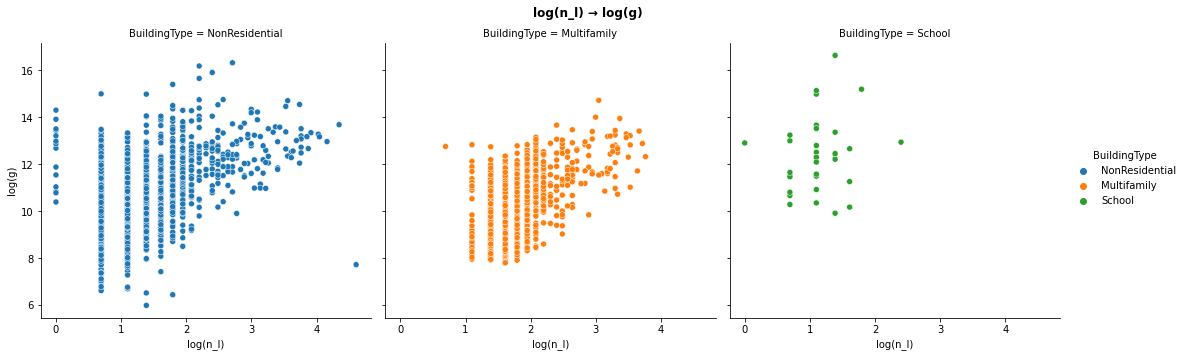

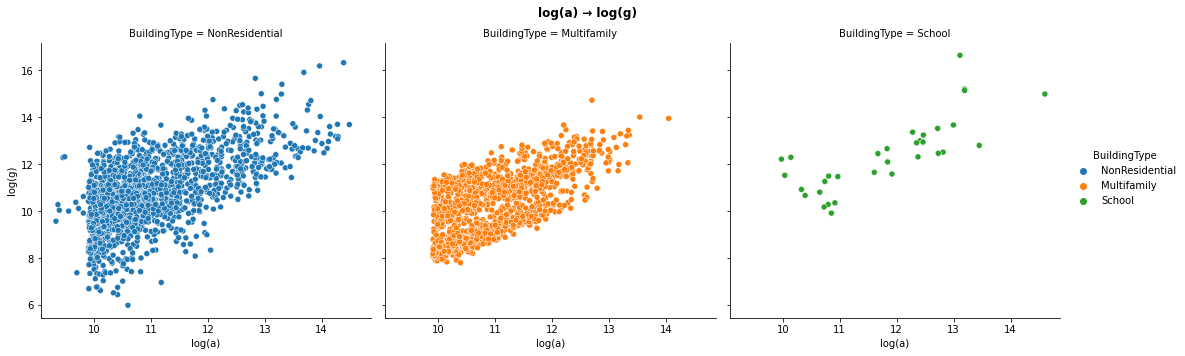

In [40]:
# title="log(n_l = 1 + NumberofFloors) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [41]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [42]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.3998451438746614
 OLS R2 score 0.4068111449496723
features : ['log(n_l)' 'log(a)']
intercept (ols) : [-2.08503848]
intercept (nnls) : [-1.08005518]
coefficients (ols) : [[-0.35371727  1.19547141]]
coefficients (nnls) : [[0.         1.05246203]]


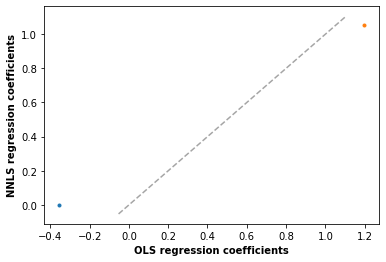

In [43]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [44]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.4077525751330986
SM OLS R2 score 0.4068111449496723
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     273.7
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           3.72e-91
Time:                        08:26:10   Log-Likelihood:                -1219.8
No. Observations:                 798   AIC:                             2446.
Df Residuals:                     795   BIC:                             2460.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [45]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.41885984 0.29183133 0.34865883]
mean scores : 0.35311666666845615
std scores : 0.05195488513038288


## Config 7 : $\ln{g} = f(\ln{a}, n_l)$

Evaluation de la contribution du nombre de niveaux `n_l` (nombres d'étages + 1).

$\{n_l, \log(a) : \log(g)\}$

Dégradation marginale de la performance en ne passant pas au log.

Mieux vaut rester au log, ce qui semble logique si l'on considère que :
$\log(S) = \log(n s) = \log(n) + \log(s)$

$R^2_7 \left(\{n_l, \log(a) : \log(g)\}\right)$:
* $\mu = 0.3469105719044963$
* $\sigma = 0.061377544673703856$

Pour comparaison :

$R^2_6 \left(\{\log(n_l), \log(a) : \log(g)\}\right)$:
* $\mu = 0.35311666666845615$
* $\sigma = 0.05195488513038288$

#### Jeu de données

In [46]:
config_name = "{n_l, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

n_l     log(a)     log(g)
id                              
1       13  11.390012  12.429136
2       12  11.547964  12.597642
3       42  13.770628  14.552330
5       11  11.023861  12.565249
8       19  12.075850  13.132334
...    ...        ...        ...
50221    2   9.812523   9.919853
50223    2   9.680344  10.378790
50224    2   9.484709  12.317346
50225    2   9.554001  10.003785
50226    2   9.812359  10.627891

[3193 rows x 3 columns]

#### Visualisation

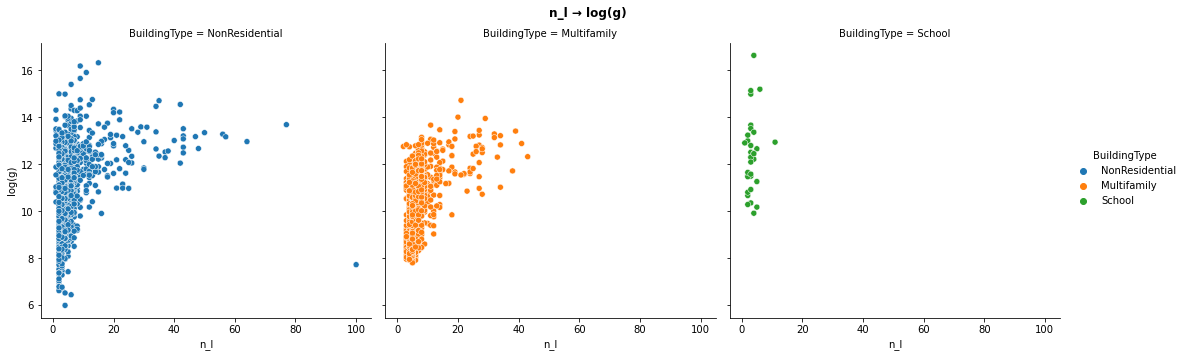

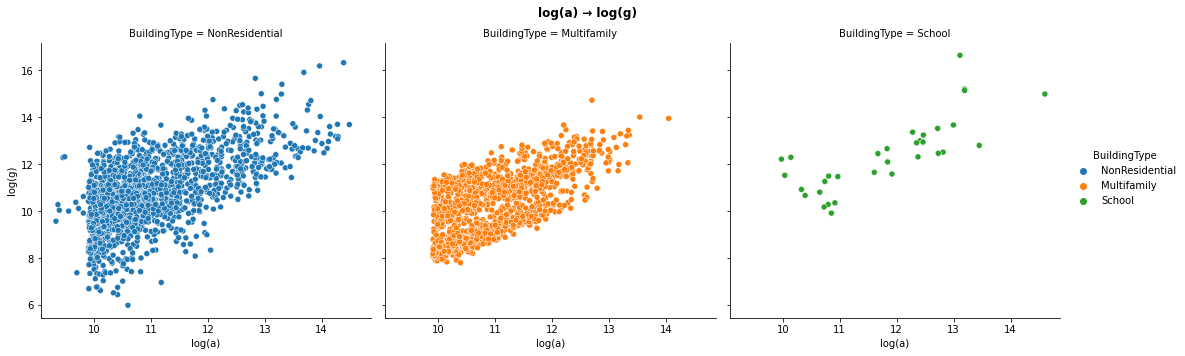

In [47]:
# title="n_l = 1 + NumberofFloors → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [48]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [49]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.3998451438746614
 OLS R2 score 0.40052792365044476
features : ['n_l' 'log(a)']
intercept (ols) : [-1.56689512]
intercept (nnls) : [-1.08005518]
coefficients (ols) : [[-0.01425552  1.10473495]]
coefficients (nnls) : [[0.         1.05246203]]


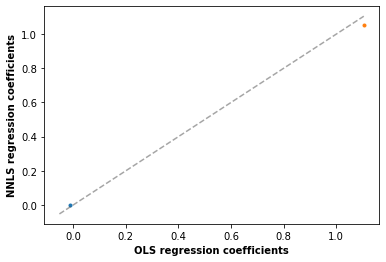

In [50]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [51]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.396915279403684
SM OLS R2 score 0.40052792365044465
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     261.6
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           5.02e-88
Time:                        08:33:08   Log-Likelihood:                -1227.0
No. Observations:                 798   AIC:                             2460.
Df Residuals:                     795   BIC:                             2474.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [52]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.4268495  0.27764725 0.33623497]
mean scores : 0.3469105719044963
std scores : 0.061377544673703856


## Config 8 : $\ln{g} = f(\ln{a}, T)$

Contribution de l'âge du bâtiment `T`.

$\{T, \log(a) :\log(e)\}$

Gain intéressant de l'ordre de 0,04 à comparer au gain de 0,012 sur l'énergie.

$R^2_8 \left(\{T, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.38582637737848335$
* $\sigma = 0.05462498998192768$

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_8 \left(\{T, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.5808945020768737$
* $\sigma = 0.06343508702165074$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [53]:
config_name = "{T, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

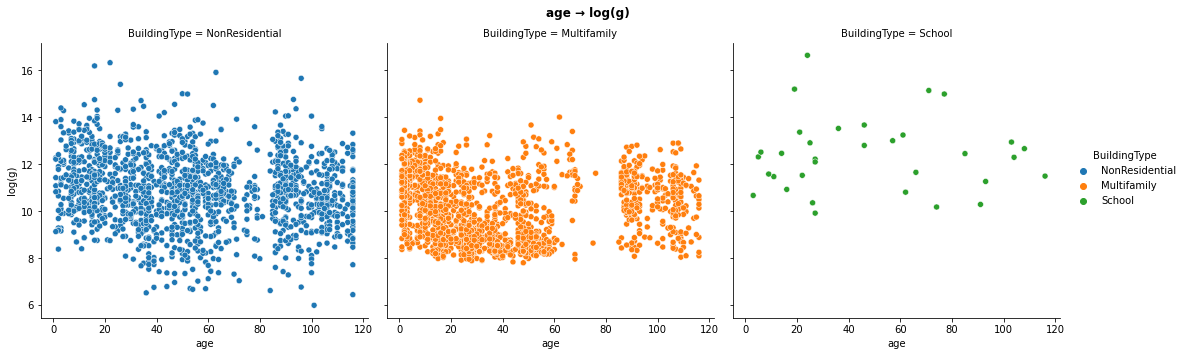

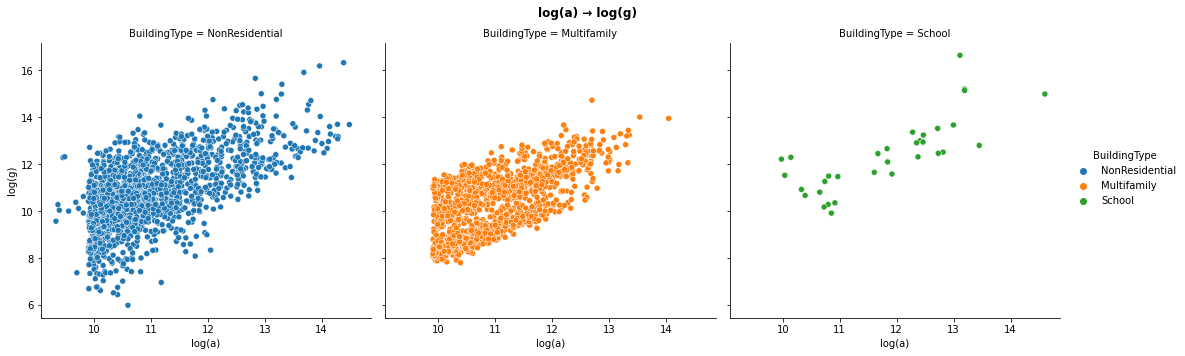

In [54]:
# title="T = (2016 - `YearBuilt`) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [55]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [56]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.4334658494340806
 OLS R2 score 0.4334658494340806
features : ['age' 'log(a)']
intercept (ols) : [-2.69279444]
intercept (nnls) : [-2.69279444]
coefficients (ols) : [[0.00886587 1.16246281]]
coefficients (nnls) : [[0.00886587 1.16246281]]


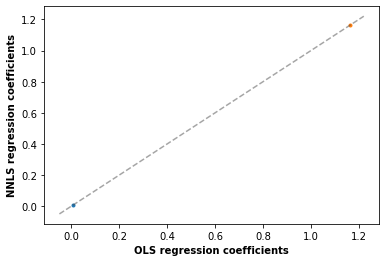

In [57]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [58]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.4318084778477653
SM OLS R2 score 0.4334658494340806
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     302.1
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           2.58e-98
Time:                        08:44:05   Log-Likelihood:                -1203.2
No. Observations:                 798   AIC:                             2412.
Df Residuals:                     795   BIC:                             2427.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [59]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.45674153 0.32383363 0.37690397]
mean scores : 0.38582637737848335
std scores : 0.05462498998192768


## Config 9 : $\ln{e} = f(\ln{a}, n_\star)$

Contribution du score ENERGYSTAR.

$\{n_\star, \log(a) :\log(e)\}$

**Gain** : 0.0281895128 à comparer à 0.0483976384 pour $e$.

$R^2_9 \left(\{n_\star, \log(a) :\log(e)\}\right)$:
* $\mu = 0.3745290700559048$
* $\sigma = 0.064792957840783$

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_9 \left(\{n_\star, \log(a) :\log(e)\}\right)$:
* $\mu = 0.616668067176413$
* $\sigma = 0.059980161457964365$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [60]:
config_name = "{n_★, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

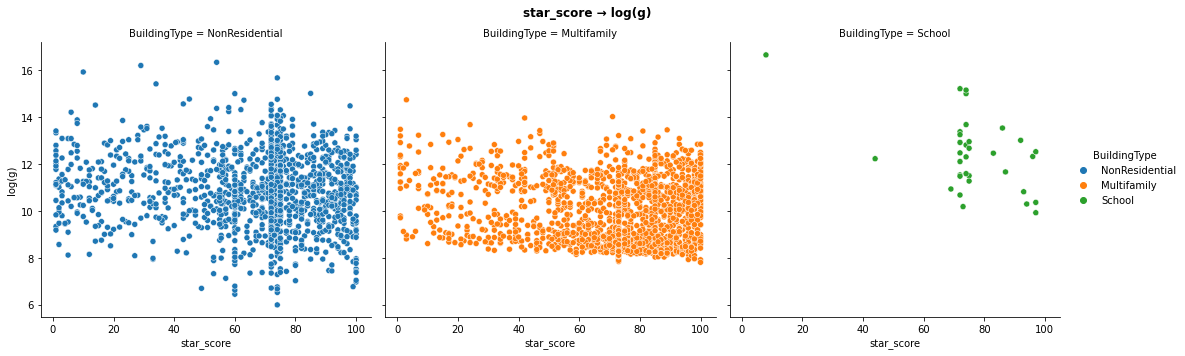

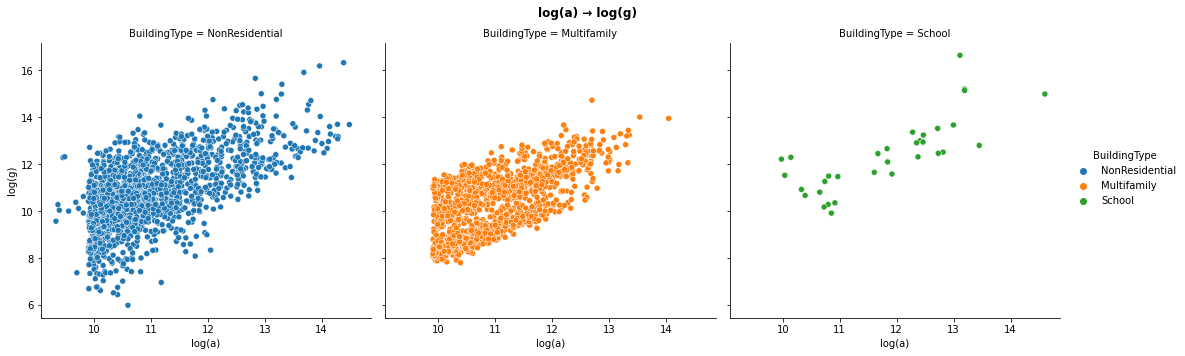

In [61]:
# title="star_score = ENERGYSTARScore → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [62]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [63]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.3998451438746614
 OLS R2 score 0.4265855175794361
features : ['star_score' 'log(a)']
intercept (ols) : [-0.55792015]
intercept (nnls) : [-1.08005518]
coefficients (ols) : [[-0.00938897  1.0641734 ]]
coefficients (nnls) : [[0.         1.05246203]]


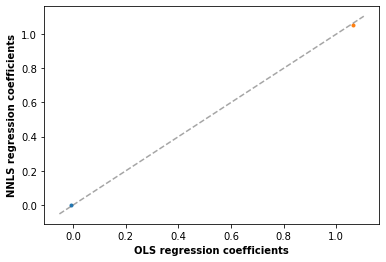

In [64]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [65]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.4193060256840858
SM OLS R2 score 0.4265855175794362
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     287.0
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           1.48e-94
Time:                        08:47:55   Log-Likelihood:                -1211.9
No. Observations:                 798   AIC:                             2430.
Df Residuals:                     795   BIC:                             2444.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [66]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.45803426 0.3001061  0.36544685]
mean scores : 0.3745290700559048
std scores : 0.064792957840783


## Config 10 : $\ln{g} = f(\ln{a}, \ln{n_l}, n_\star, T)$

Premier test d'intégration de ce qui a précédemment contribué.

$\{T, n_\star, \log(n_l), \log(a) : \log(g)\}$

$R^2_{10}  \left(\{T, n_\star, \log(n_l), \log(a) : \log(g)\}\right)$ :
* $\mu = 0.41448951503080383$
* $\sigma = 0.0517169529411019$

Pour comparaison :
$R^2_{10}  \left(\{T, n_\star, \log(n_l), \log(a) : \log(e)\}\right)$ :
* $\mu = 0.627354265583291$
* $\sigma = 0.05753899421598054$

#### Jeu de données

In [67]:
config_name = "{n_★, log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

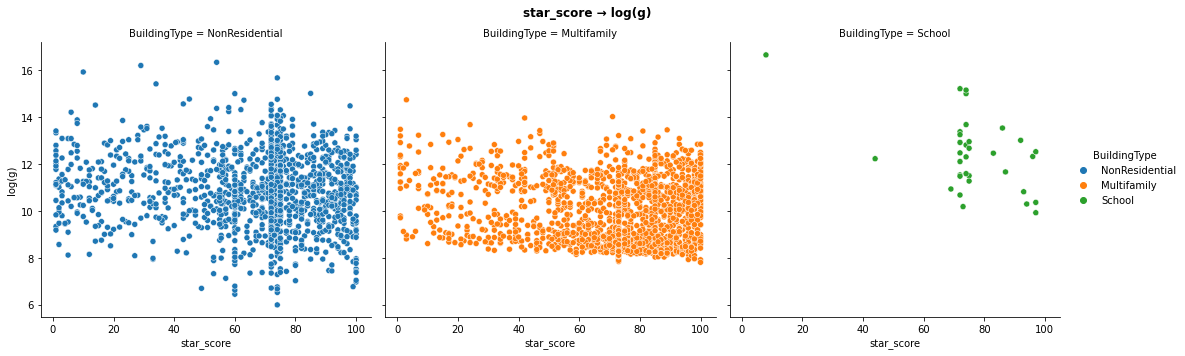

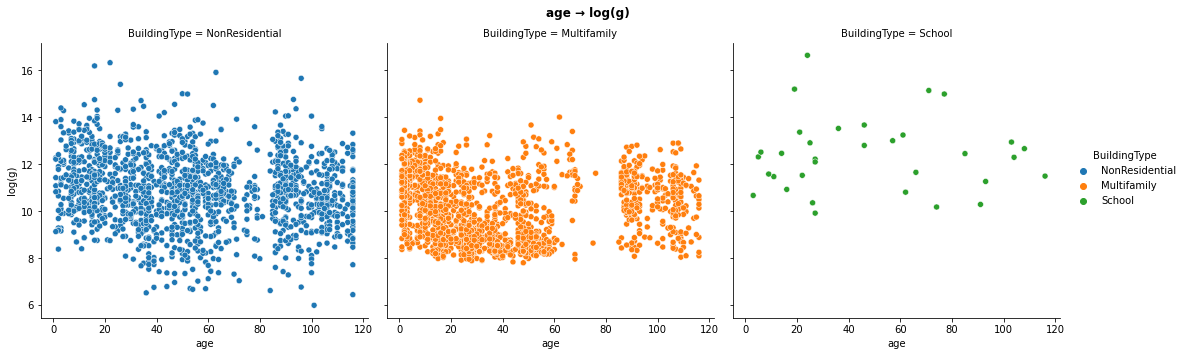

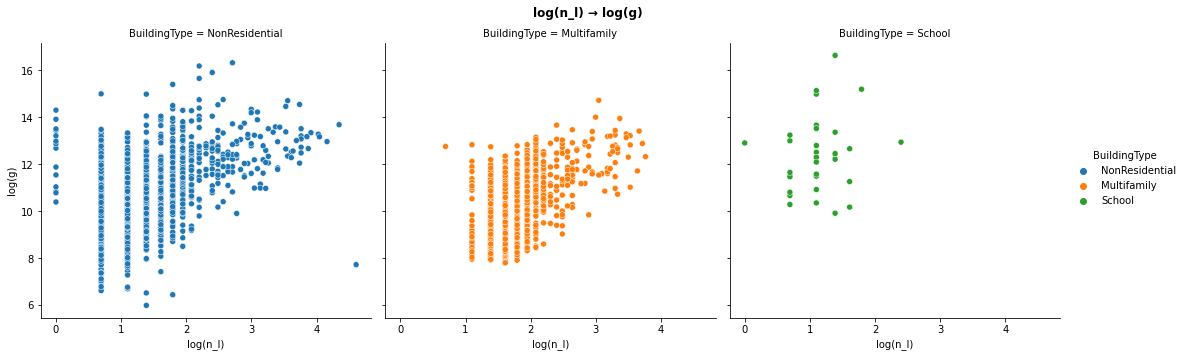

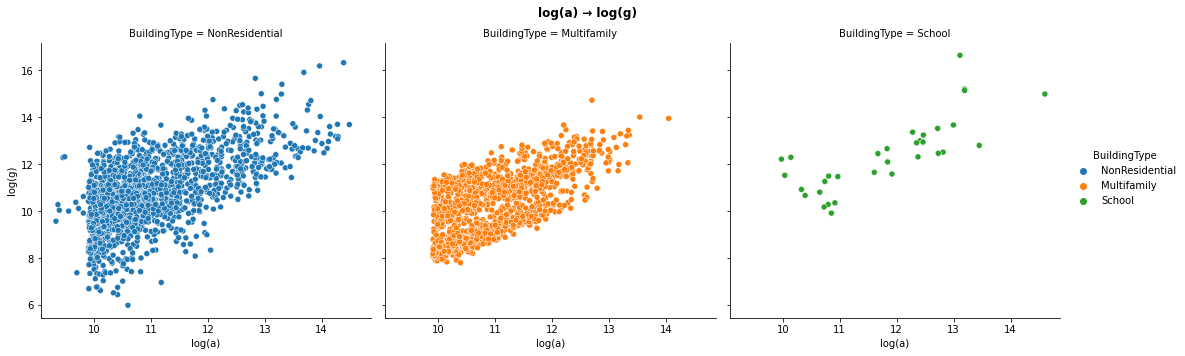

In [68]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [69]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [70]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.4334658494340806
 OLS R2 score 0.46254693820949244
features : ['star_score' 'age' 'log(n_l)' 'log(a)']
intercept (ols) : [-2.88795659]
intercept (nnls) : [-2.69279444]
coefficients (ols) : [[-0.00892542  0.008378   -0.27462495  1.27857479]]
coefficients (nnls) : [[0.         0.00886587 0.         1.16246281]]


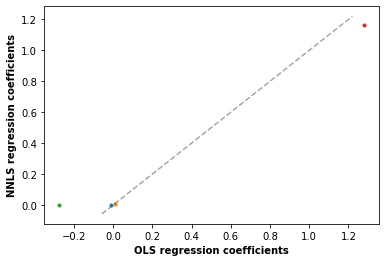

In [71]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [72]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.46217538063559294
SM OLS R2 score 0.4625469382094922
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     170.4
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          2.91e-105
Time:                        08:57:16   Log-Likelihood:                -1181.3
No. Observations:                 798   AIC:                             2373.
Df Residuals:                     793   BIC:                             2396.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

#### Validation croisée du score OLS

In [73]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.48304591 0.35814369 0.40227895]
mean scores : 0.41448951503080383
std scores : 0.0517169529411019


## Config 11 : $\ln{e} = f(\ln{a}, t_b)$

Contribution de `btype`.

$\{t_b, \log(a) : \log(e)\}$

Gain significatif : 0,0507938579.

$R^2_{11} \left(\{t_b, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.3971334150636577$
* $\sigma = 0.04453323147467514$

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_{11} \left(\{t_b, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.6306192265111306$
* $\sigma = 0.06192790341106927$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [74]:
config_name = "{t_b, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

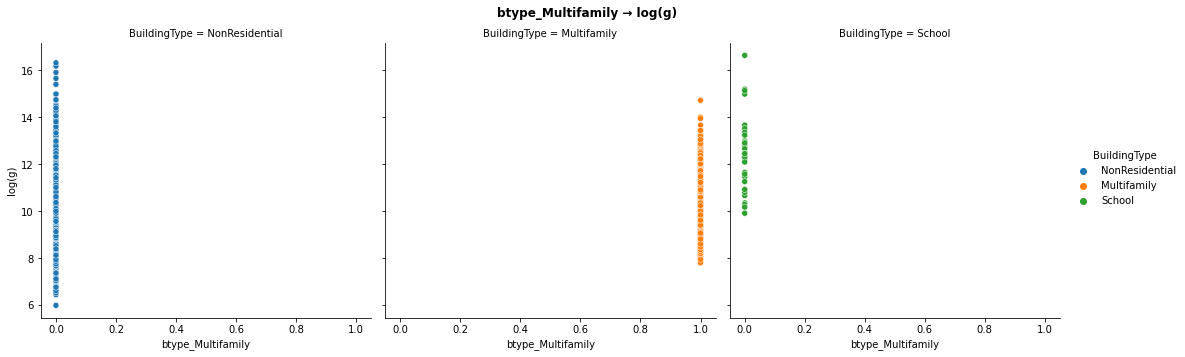

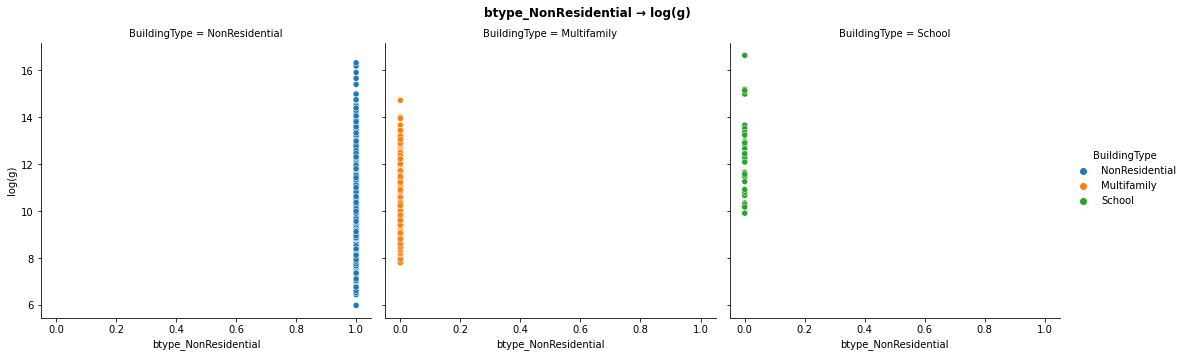

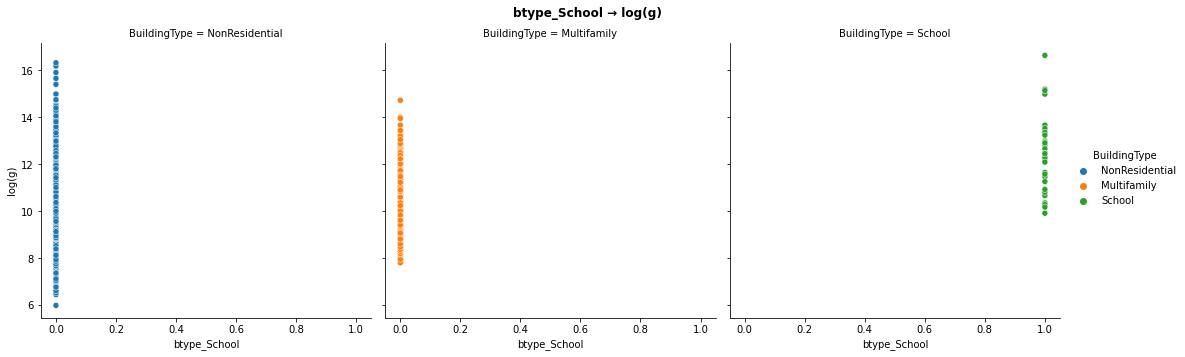

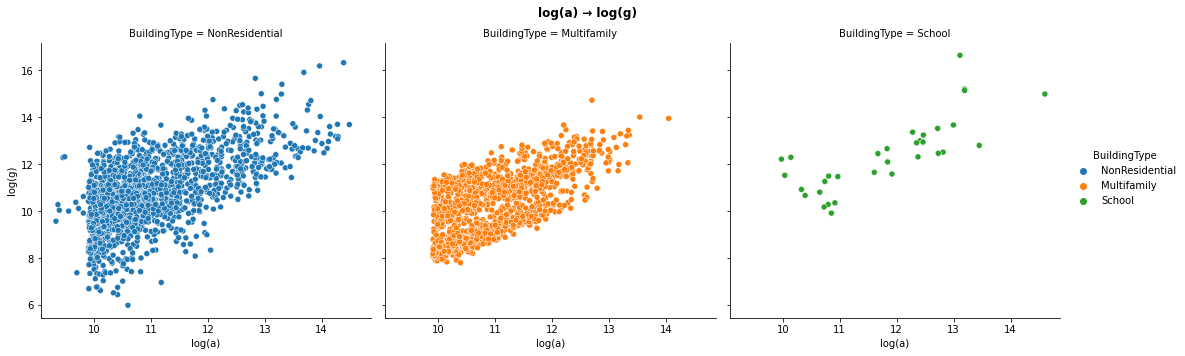

In [75]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [79]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [80]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.4520947185577041
 OLS R2 score 0.4520947185577041
features : ['btype_Multifamily' 'btype_NonResidential' 'btype_School' 'log(a)']
intercept (ols) : [-0.3135023]
intercept (nnls) : [-0.97943139]
coefficients (ols) : [[-0.66592909 -0.01909855  0.68502763  1.01479213]]
coefficients (nnls) : [[0.         0.64683054 1.35095672 1.01479213]]


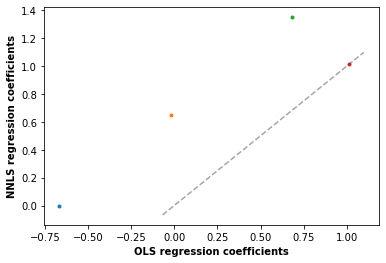

In [81]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [82]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.44849782527478066
SM OLS R2 score 0.4520947185577041
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     215.2
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          3.74e-102
Time:                        09:07:03   Log-Likelihood:                -1191.4
No. Observations:                 798   AIC:                             2391.
Df Residuals:                     794   BIC:                             2409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

#### Validation croisée du score OLS

0,63 contre 0,56 sans `btype`

In [83]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.44492009 0.33771349 0.40876667]
mean scores : 0.3971334150636577
std scores : 0.04453323147467514


## Config 12 : $\ln{g} = f(\ln{a}, t_p)$

Contribution de `ptype`.

$\{t_p, \log(a) : \log(g)\}$

Gain significatif : 0,149735738.

$R^2_{12} \left(\{t_p, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.496075295515992$
* $\sigma = 0.060650302648452496$

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_{11} \left(\{t_b, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.3971334150636577$
* $\sigma = 0.04453323147467514$

$R^2_{12} \left(\{t_p, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.7210437373349693$
* $\sigma = 0.04229253973342958$

$R^2_{11} \left(\{t_b, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.6306192265111306$
* $\sigma = 0.06192790341106927$

#### Jeu de données

In [84]:
config_name = "{t_p, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

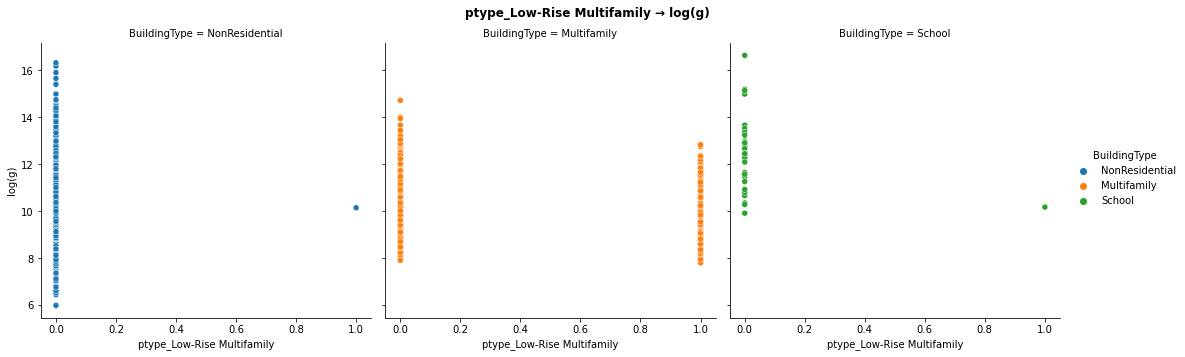

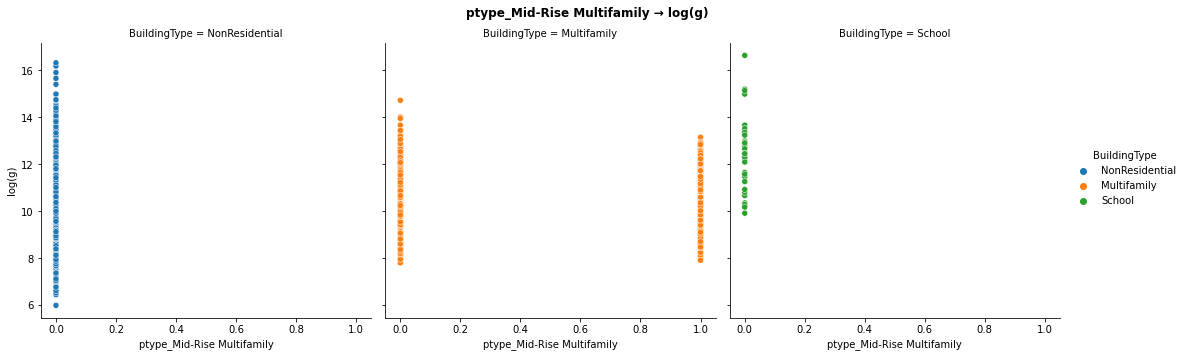

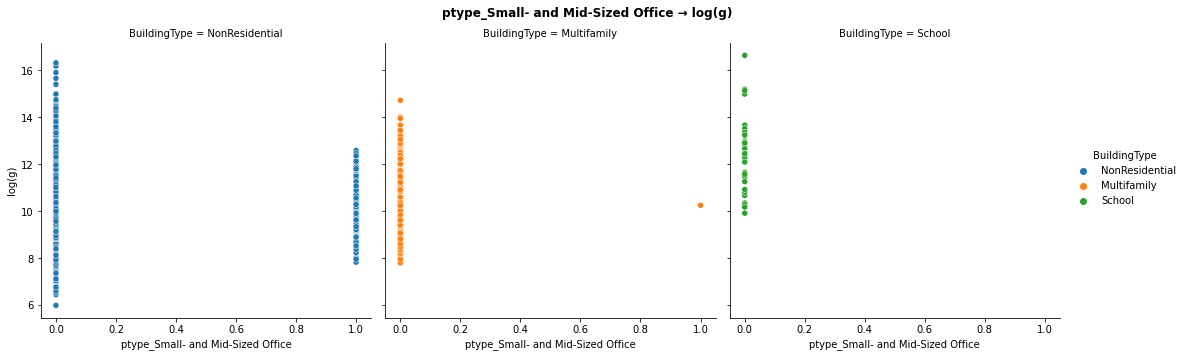

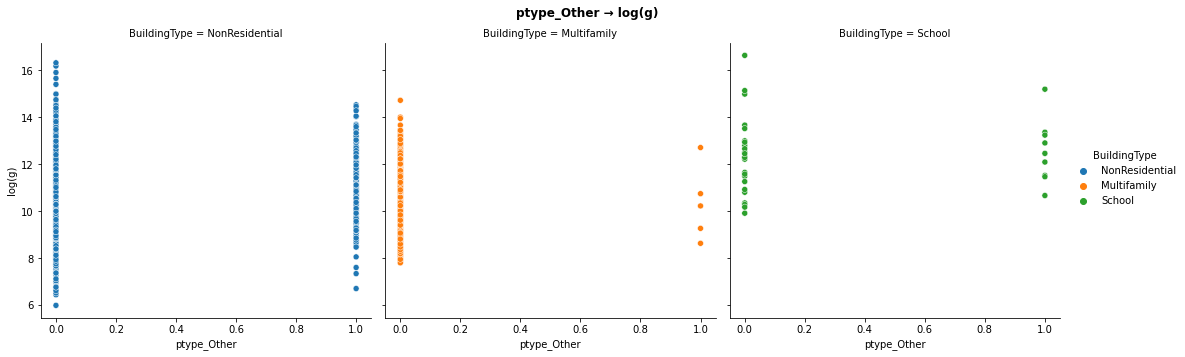

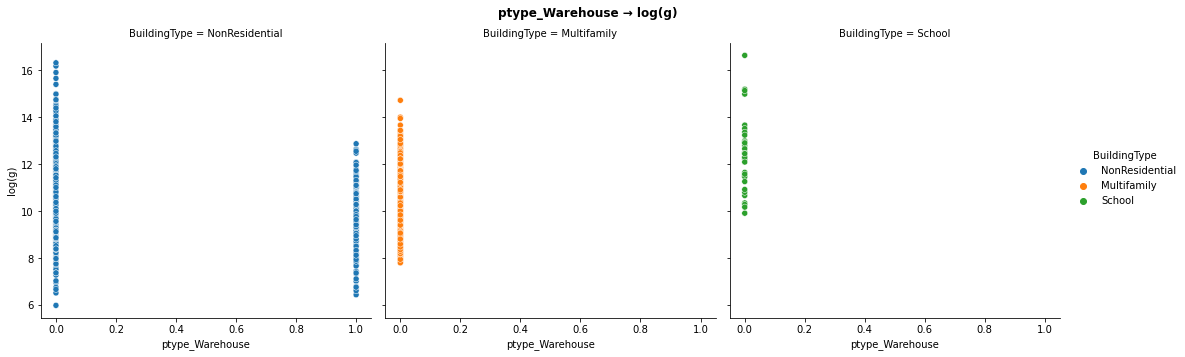

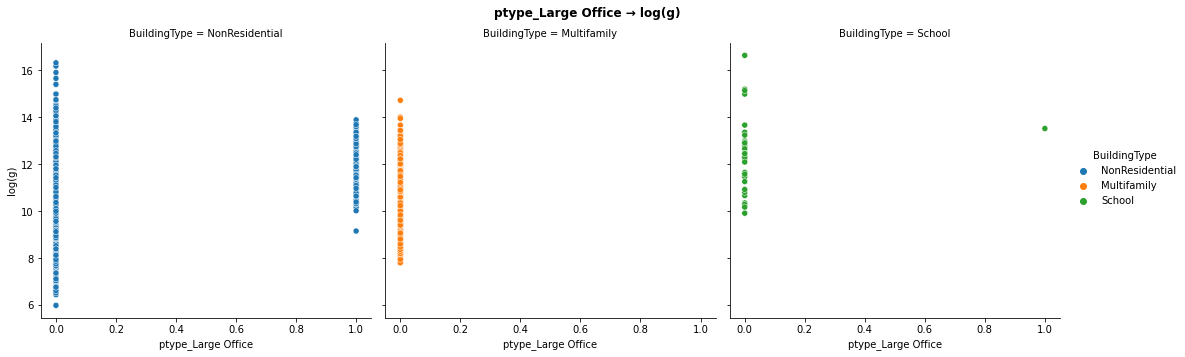

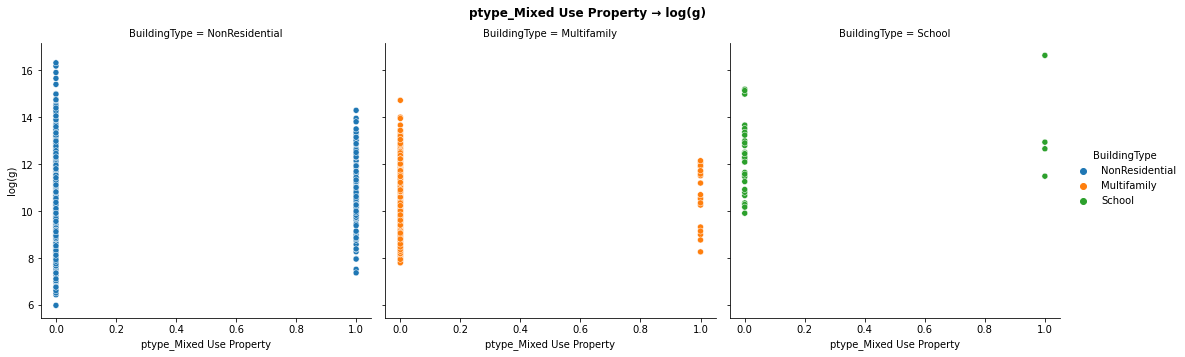

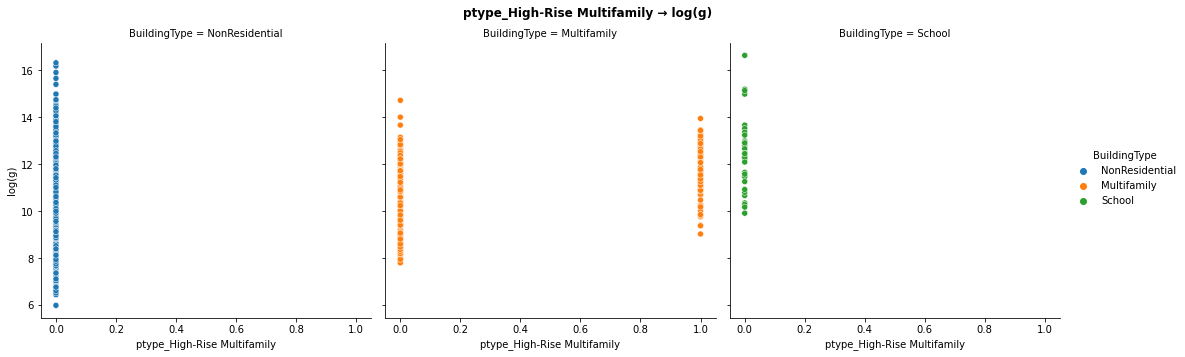

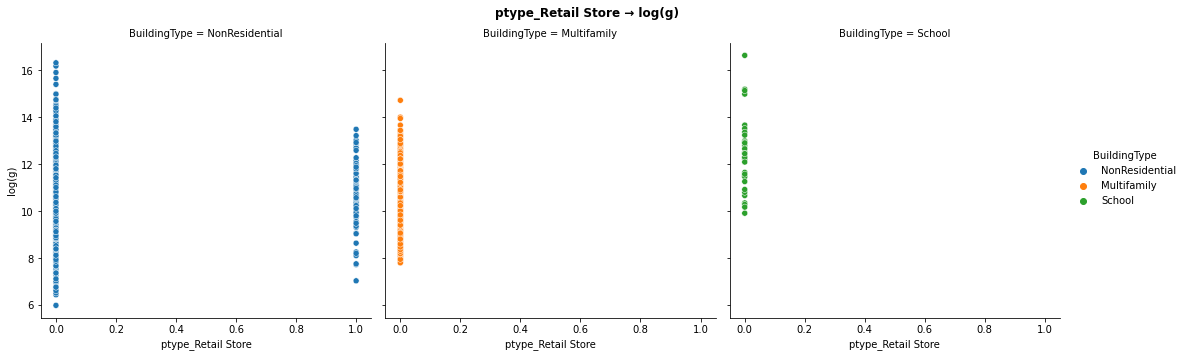

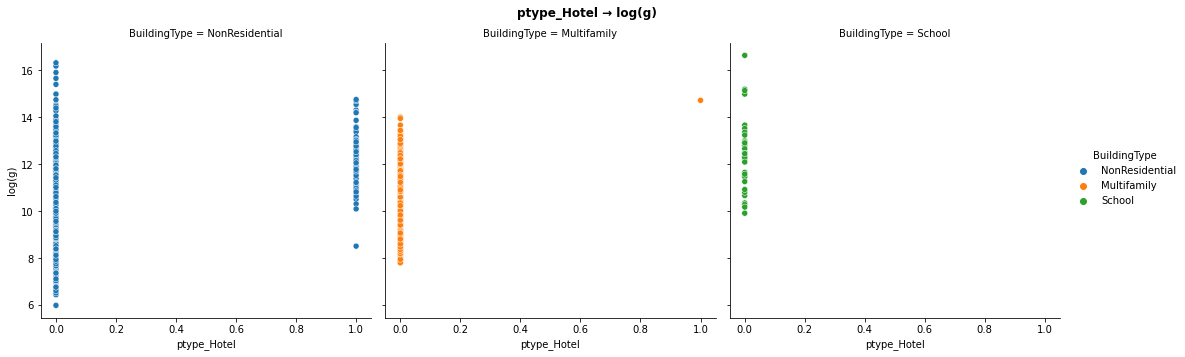

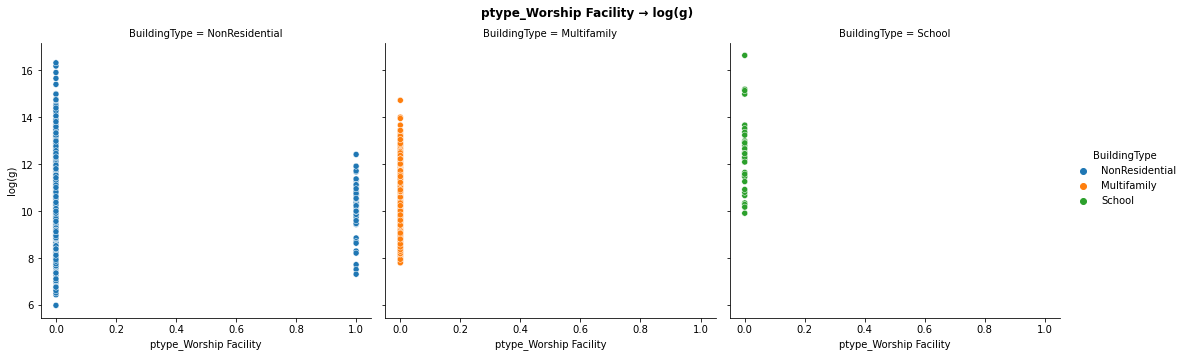

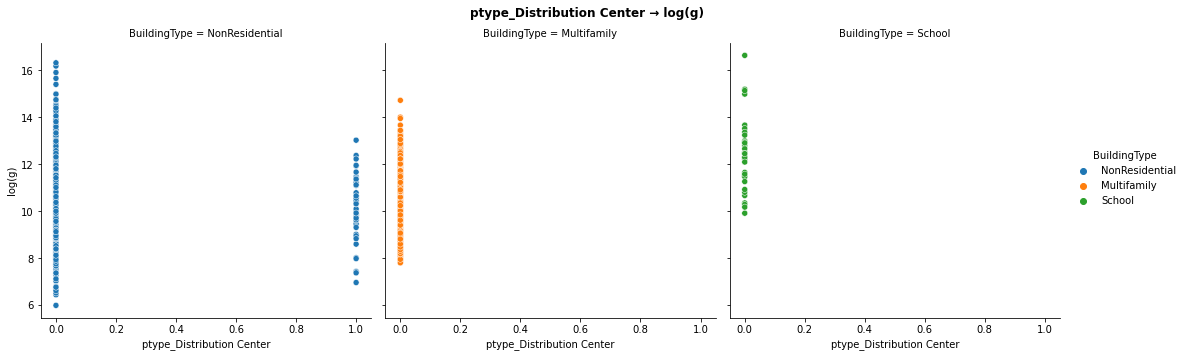

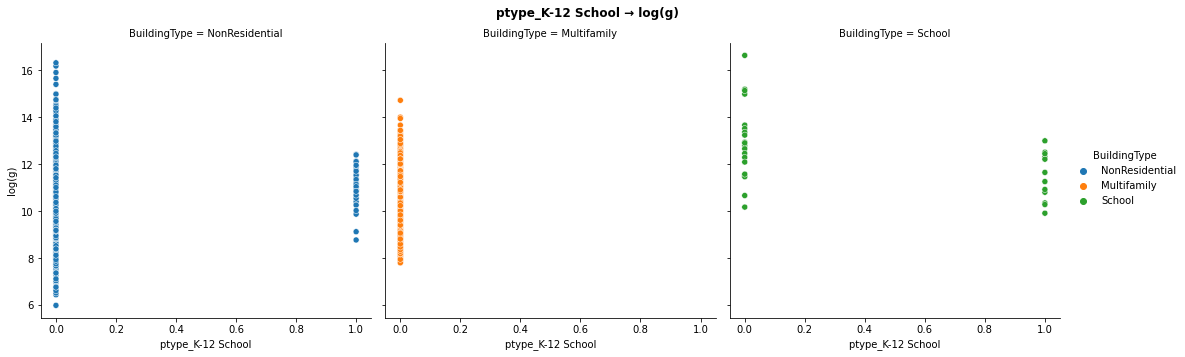

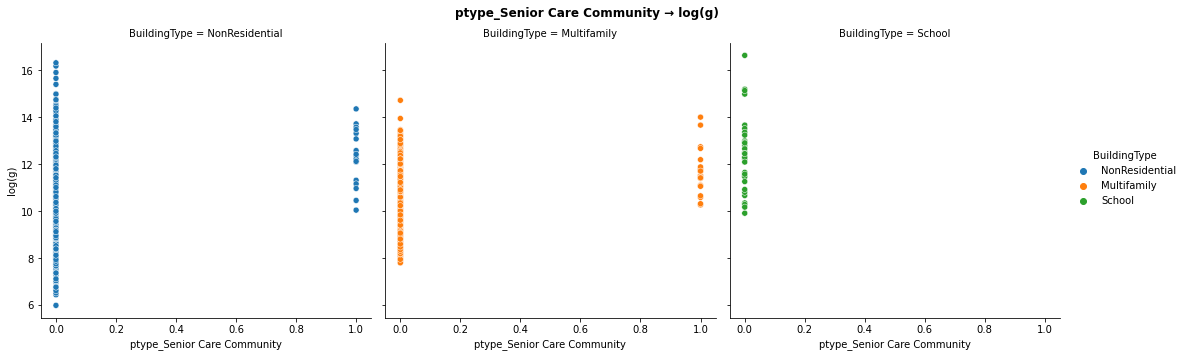

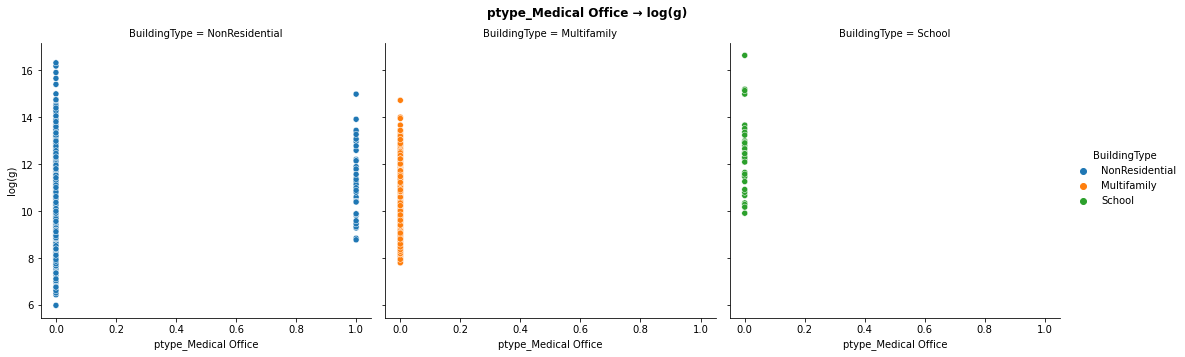

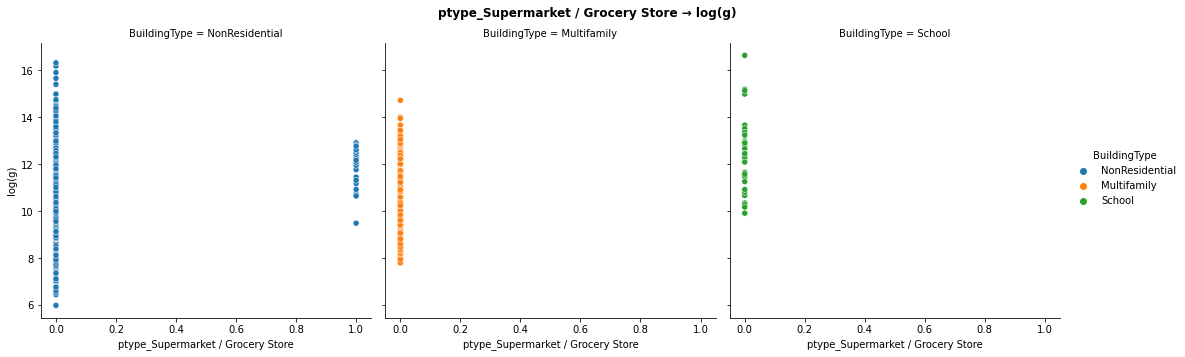

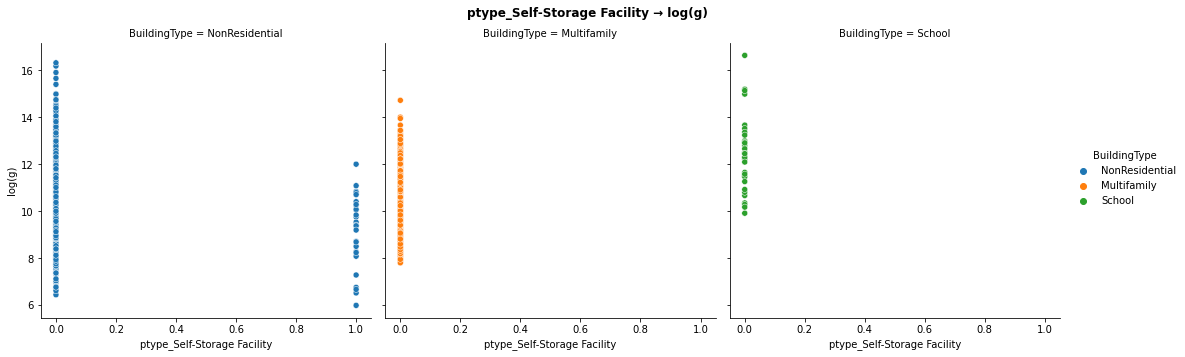

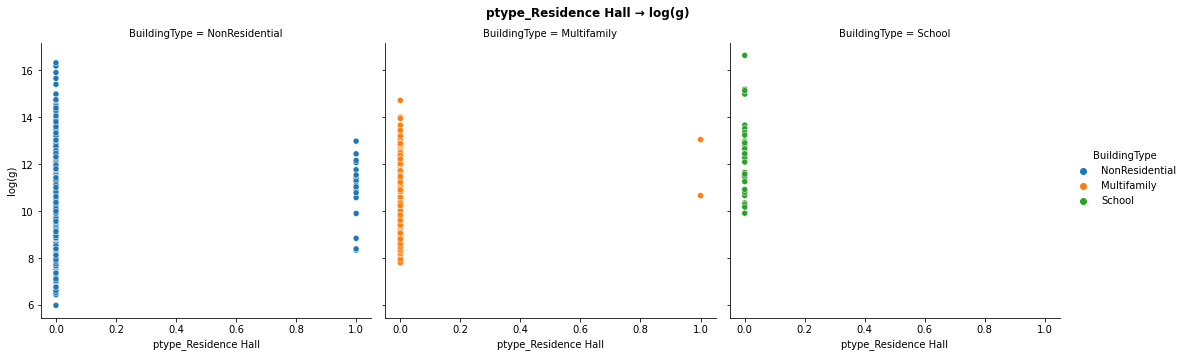

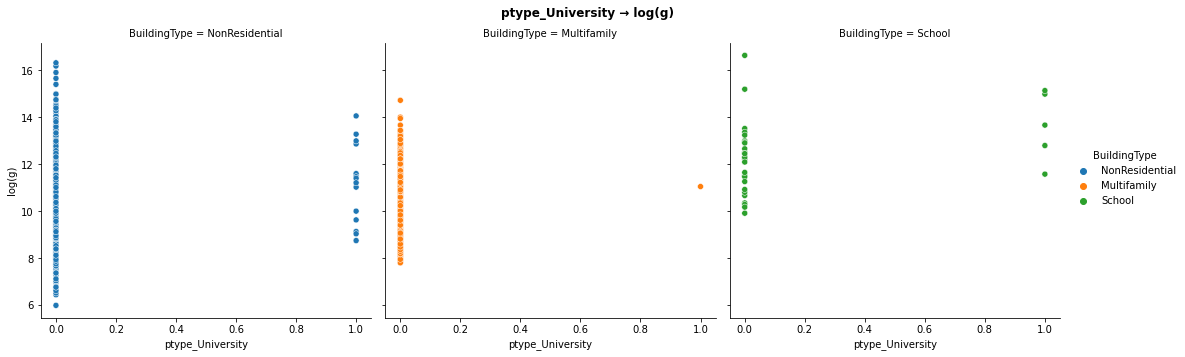

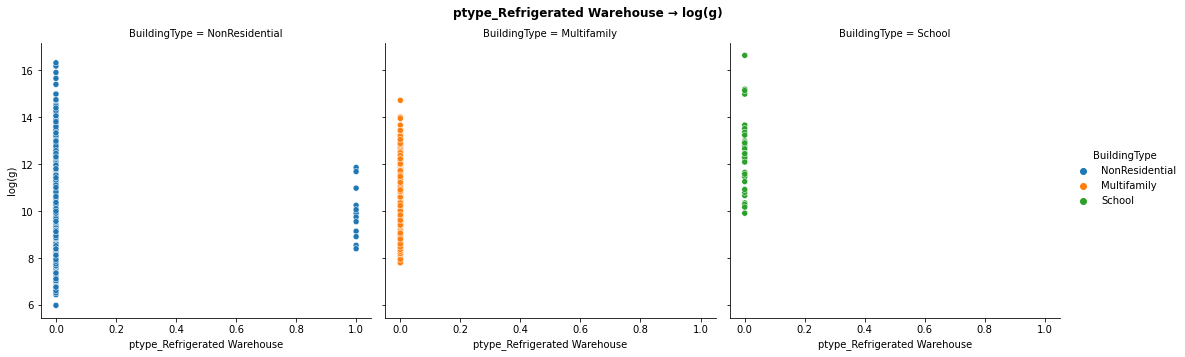

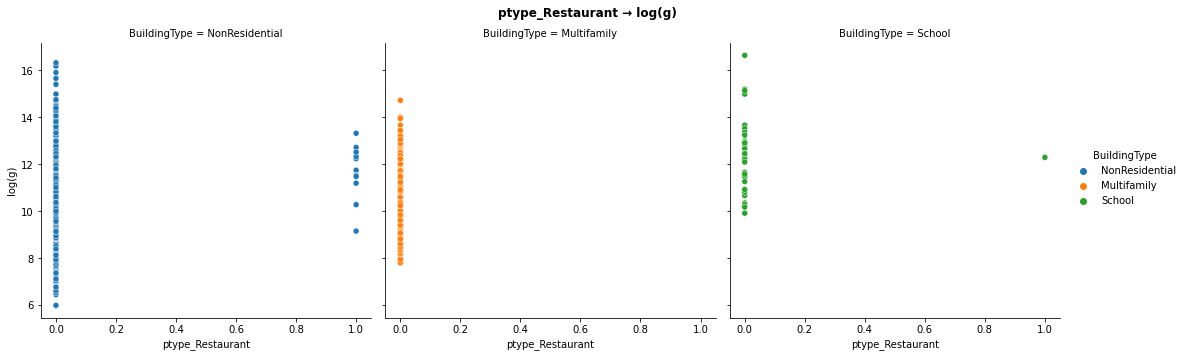

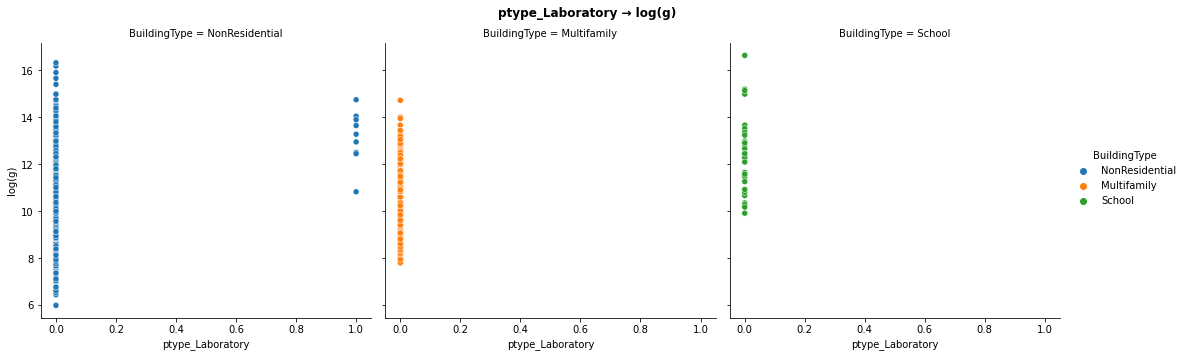

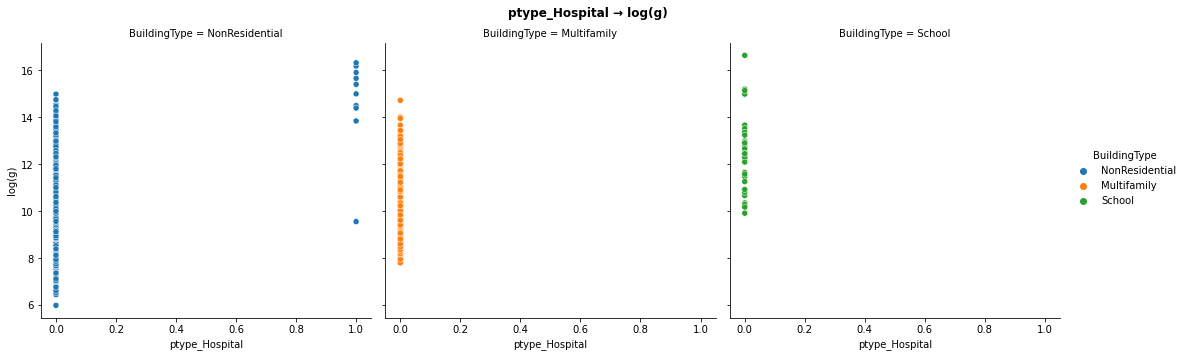

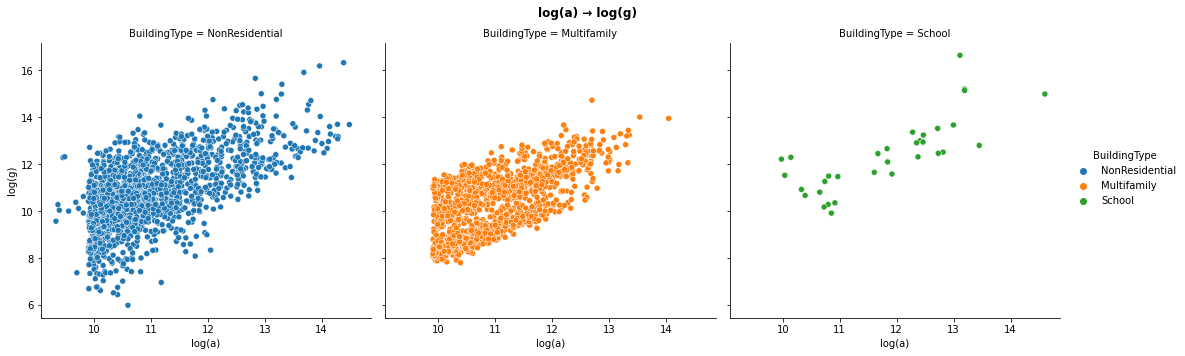

In [85]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [86]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [87]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.5415714117949235
 OLS R2 score 0.541482278828908
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'log(a)']
intercept (ols) : [0.58757074]
intercept (nnls) : [-1.50851454e+13]
coefficients (ols) : [[-0.99485585 -0.7123919  -0.35313266  0.30455531 -0.73484236 -0.73272574
  -0.46557057 -0.01827277 -0.2799993   0.4968119   0.02796186 -0.84049924
   0.22202293  0.15921314  0.03075586  1.29712066 -1.84427015 -0.1108857
   0.09454838 -0.265201    1.5655574

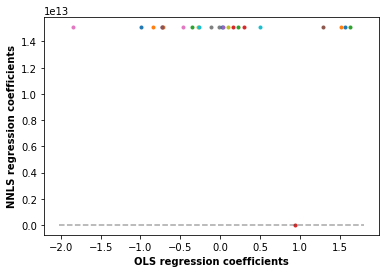

In [88]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [89]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.5401426742845434
SM OLS R2 score 0.5414822788289076
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     39.53
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          6.30e-114
Time:                        09:15:57   Log-Likelihood:                -1118.8
No. Observations:                 798   AIC:                             2286.
Df Residuals:                     774   BIC:                             2398.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

#### Validation croisée du score OLS

In [90]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.56851109 0.420077   0.4996378 ]
mean scores : 0.496075295515992
std scores : 0.060650302648452496


## Config 13 : $\ln{g} = f(\ln{a}, t_p, t_b)$

Contribution de `btype` + `ptype`.

$\{t_b, t_p, \log(a) : \log(g)\}$

Amélioration marginale de l'ordre de 0,0025 par rapport à `ptype` seul.

$R^2_{13} \left(\{t_b, t_p, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.4985341782207848$
* $\sigma = 0.061615539070322856$

Pour comparaison :

$R^2_{12} \left(\{t_p, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.496075295515992$
* $\sigma = 0.060650302648452496$

$R^2_{11} \left(\{t_b, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.3971334150636577$
* $\sigma = 0.04453323147467514$

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

Pour comparaison avec $e$ :

$R^2_{13} \left(\{t_b, t_p, \log(a):\log(e)\}\right)$ :
* $\mu = 0.7249152370998896$
* $\sigma = 0.04175007296498173$

$R^2_{12} \left(\{t_p, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.7210437373349693$
* $\sigma = 0.04229253973342958$

$R^2_{11} \left(\{t_b, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.6306192265111306$
* $\sigma = 0.06192790341106927$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [91]:
config_name = "{t_b, t_p, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation

#### Vérifications

In [92]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [93]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

La NNLS est manifestement en saturation.

NNLS R2 score 0.5395584186989701
 OLS R2 score 0.5439711466408166
features : ['btype_Multifamily' 'btype_NonResidential' 'btype_School'
 'ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'log(a)']
intercept (ols) : [0.60166033]
intercept (nnls) : [-7.76670498e+13]
coefficients (ols) : [[-2.13902226e-01  3.95160816e-03  2.09950618e-01 -8.08143933e-01
  -5.26568837e-01 -3.81260355e-01  2.70038104e-01 -7.66287891e-01
  -7.66610078e-01 -4.48266690e-01  1.66209706e-01 -3.11650849e-01

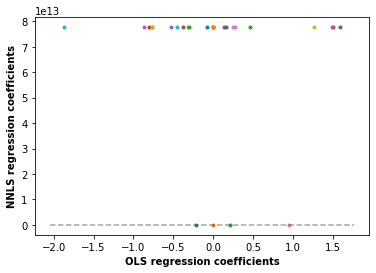

In [94]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives

On pourra raffiner en éliminant ces variables peu pertinentes.

In [95]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.5405490922585015
SM OLS R2 score 0.543971146640817
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     36.33
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          1.79e-112
Time:                        09:25:19   Log-Likelihood:                -1118.5
No. Observations:                 798   AIC:                             2289.
Df Residuals:                     772   BIC:                             2411.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

#### Validation croisée du score OLS

`btype` est redondant avec `ptype` : l'ajouter n'apporte aucun de gain de performance.

In [96]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.57343783 0.42252338 0.49964132]
mean scores : 0.4985341782207848
std scores : 0.061615539070322856


## Config 14 : $\ln{g} = f(\ln{a}, (\tilde{a}_{u_k}))$

Contribution de la ventilation de la surface suivant les usages.

$\{(\tilde{a}_{u_k}), \log(a) : \log(g)\}$

$R^2_{14} \left(\{(\tilde{a}_{u_k}), \log(a) : \log(g)\}\right)$ :
* $\mu = 0.39952776292639586$
* $\sigma = 0.028257919761218674$

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_{14} \left(\{(\tilde{a}_{u_k}), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6225481013361372$
* $\sigma = 0.08228628334571318$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [97]:
config_name = "{(_a_u_k)_k, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

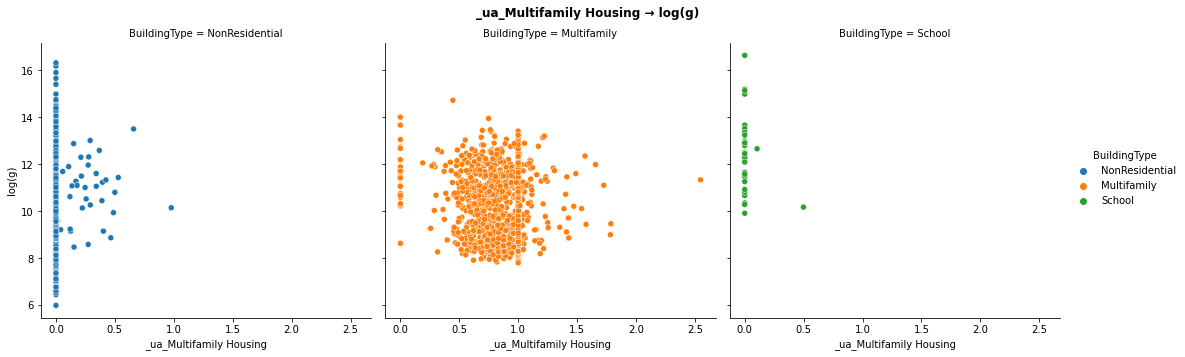

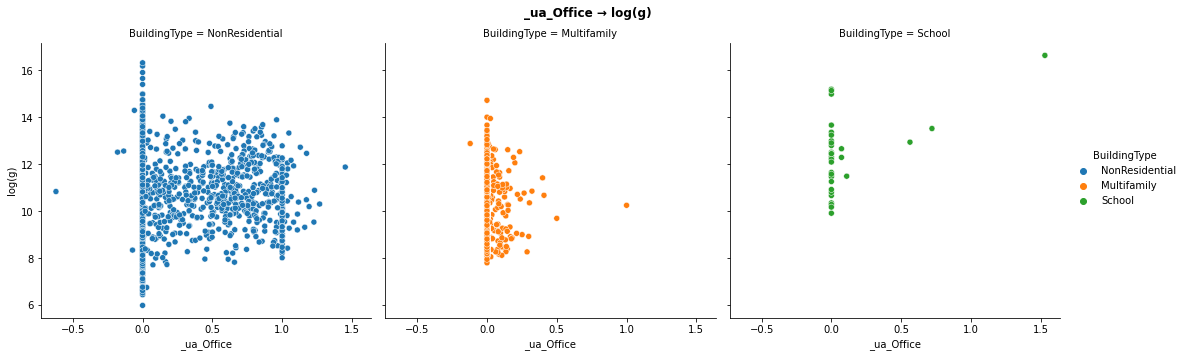

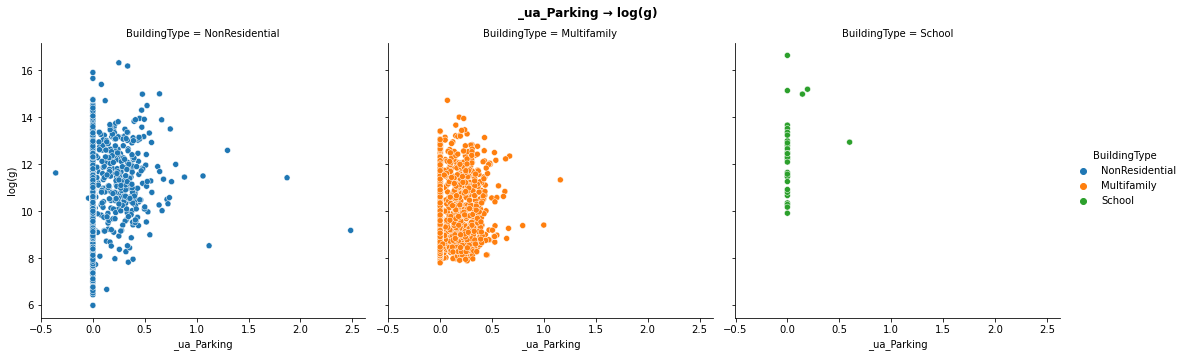

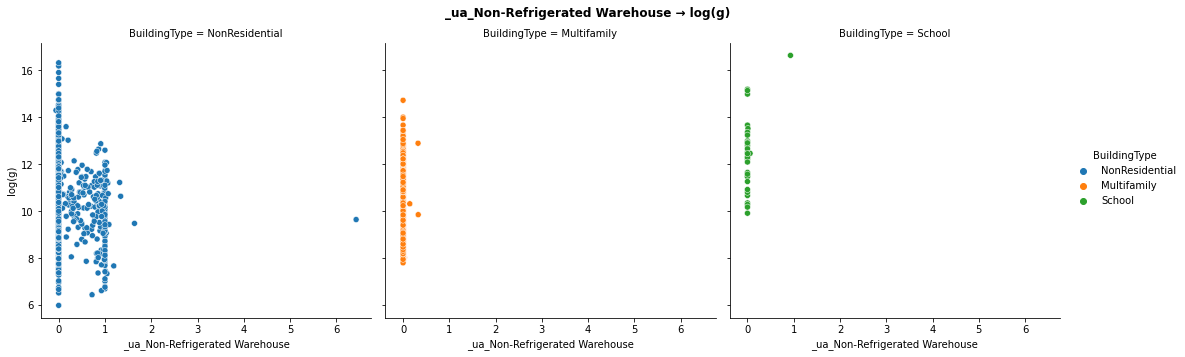

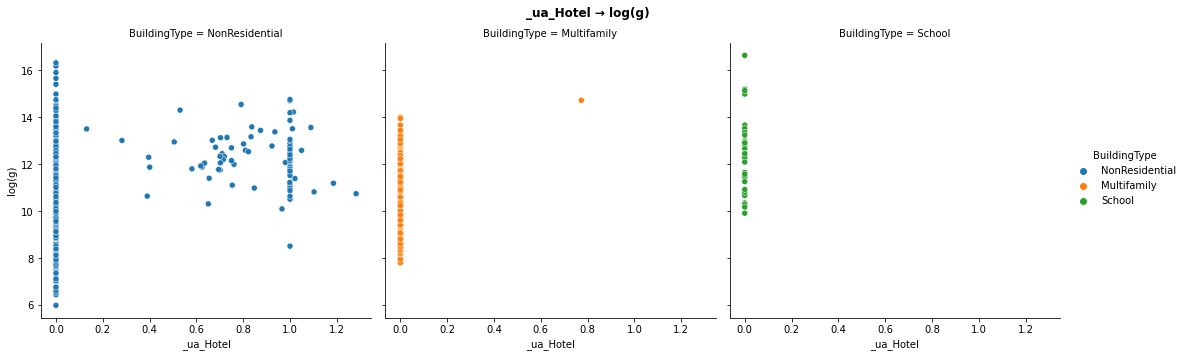

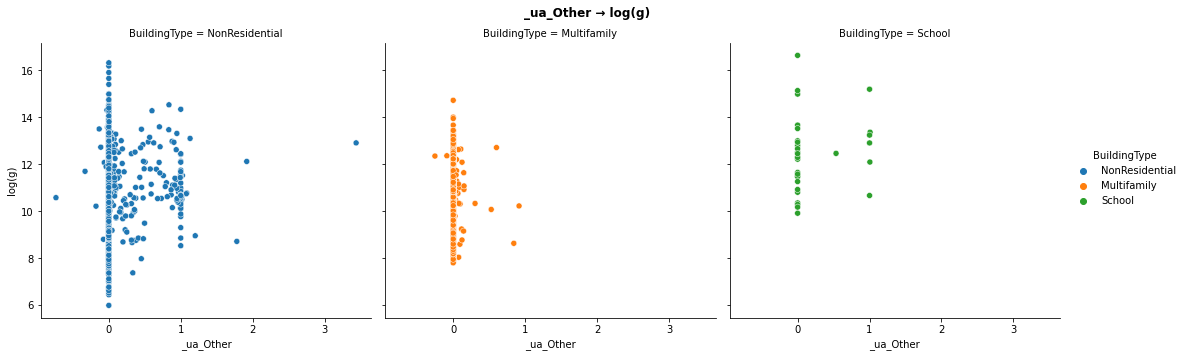

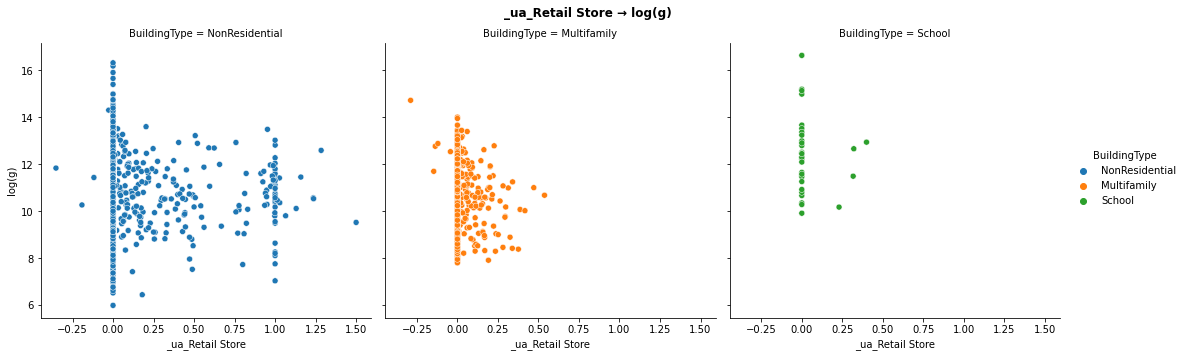

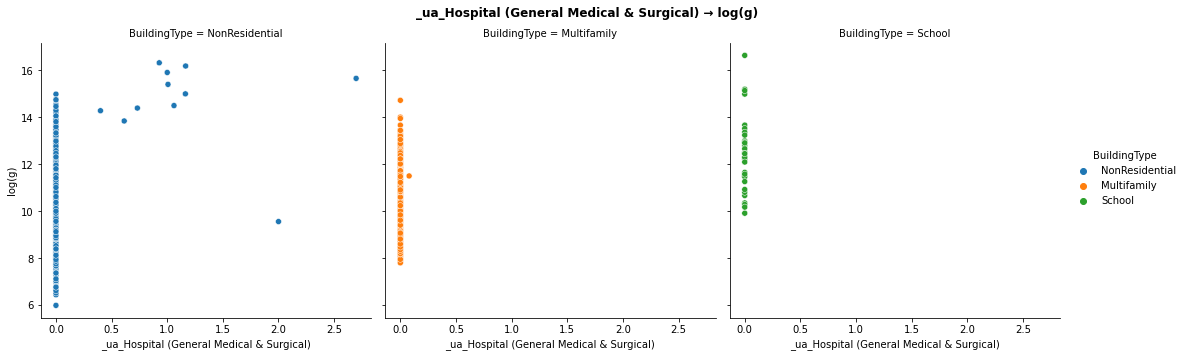

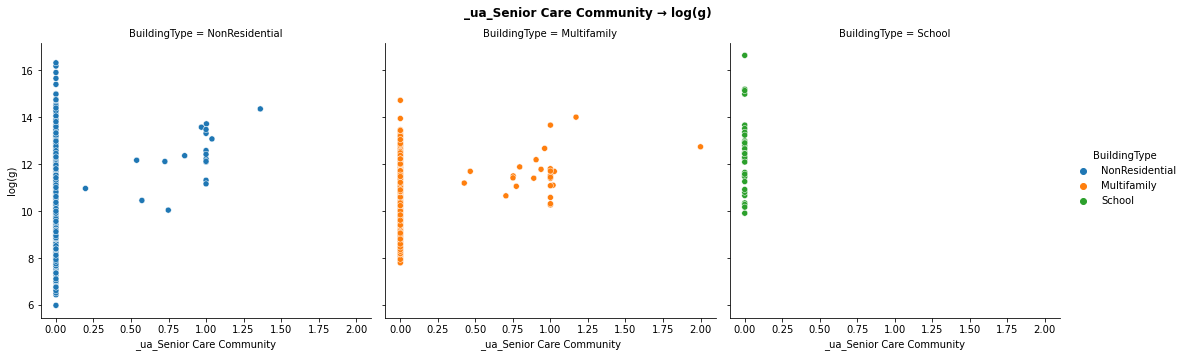

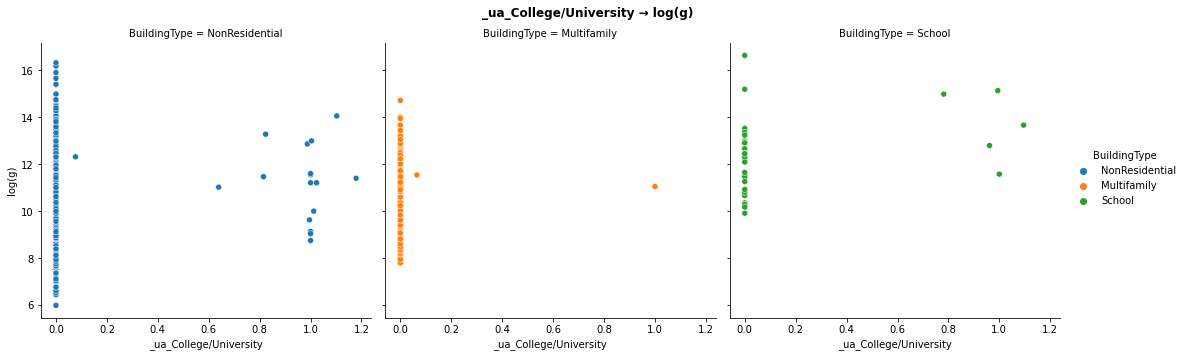

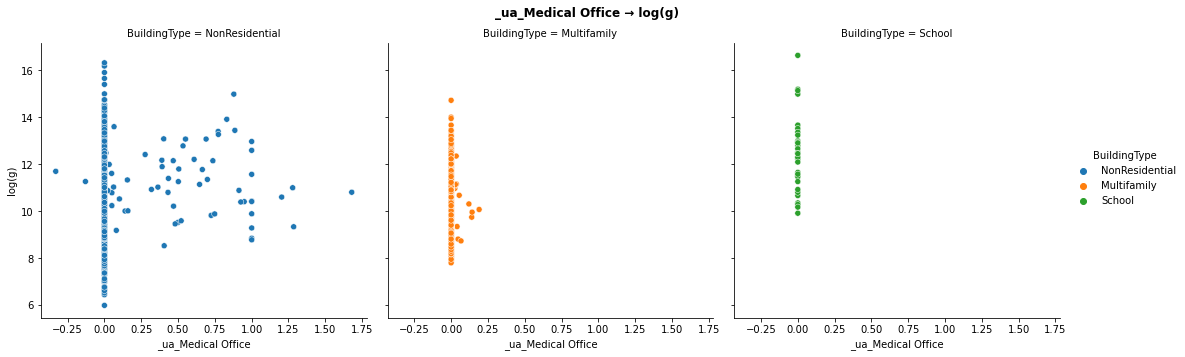

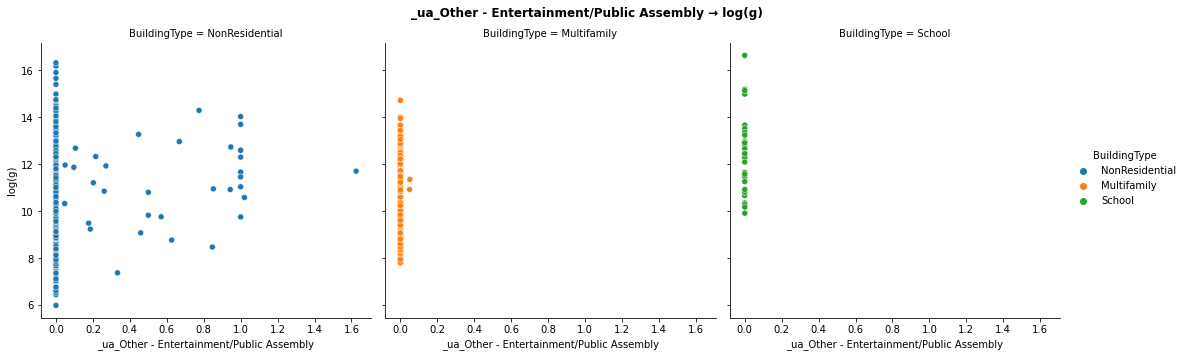

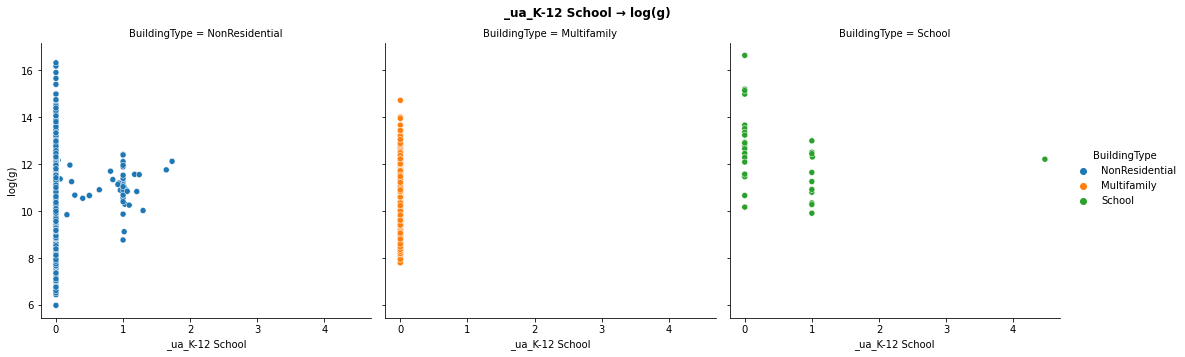

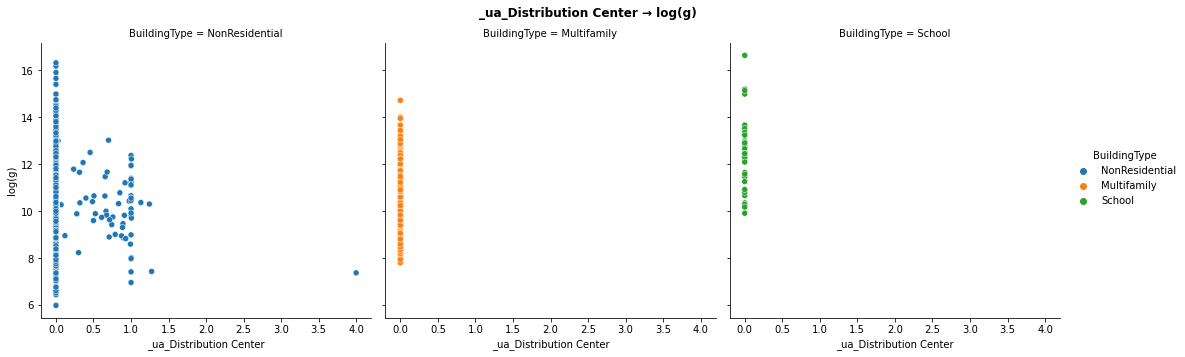

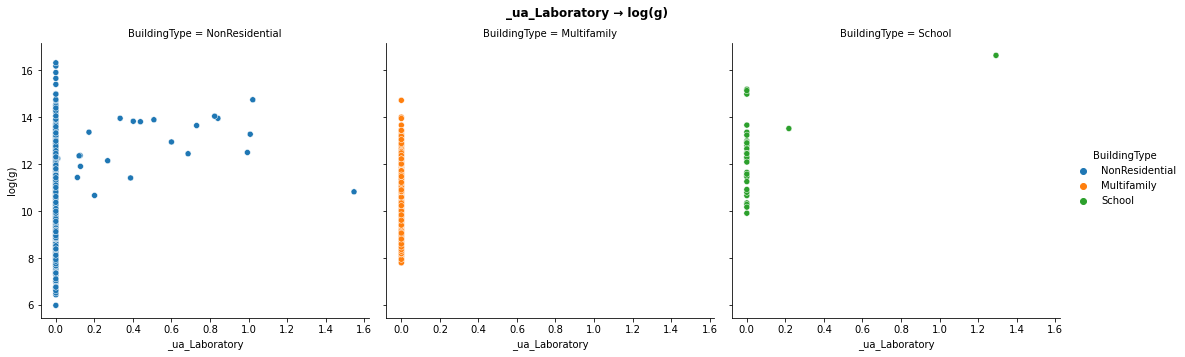

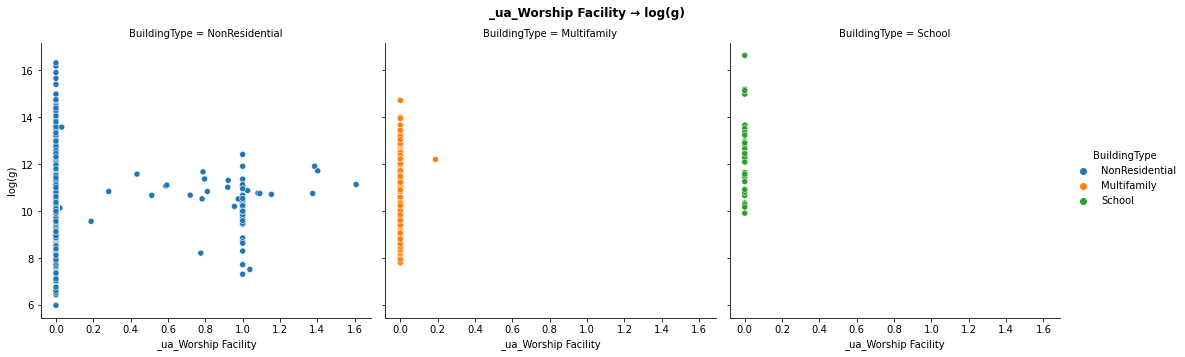

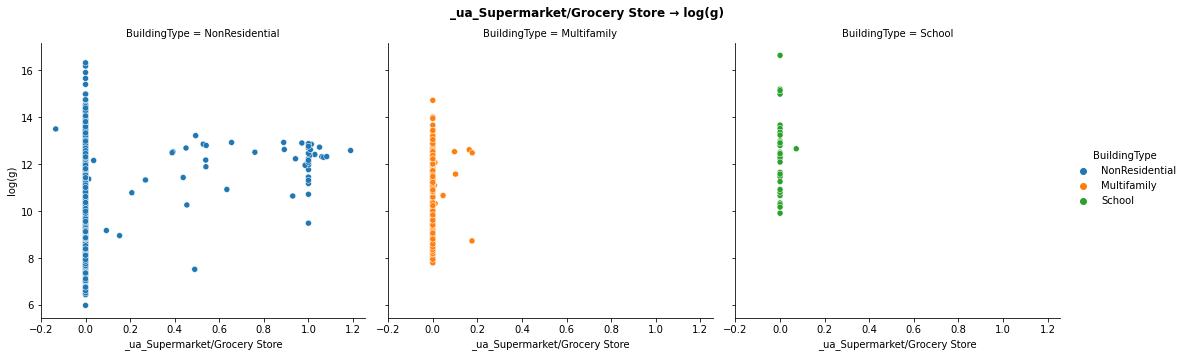

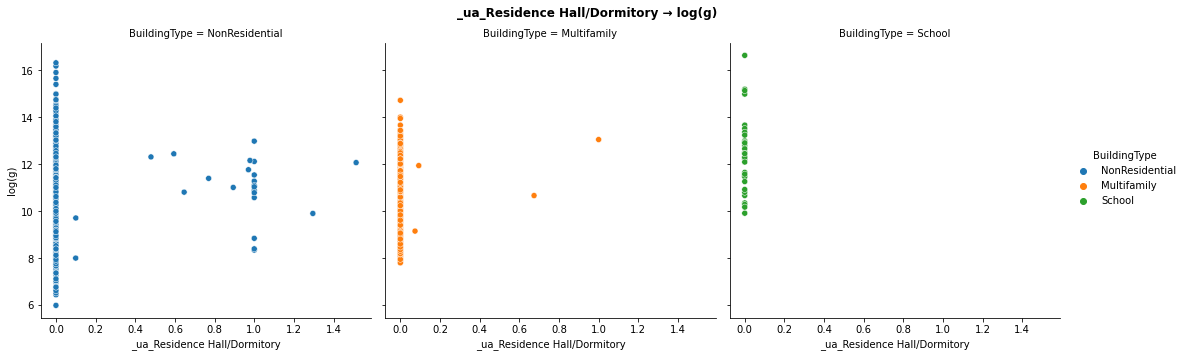

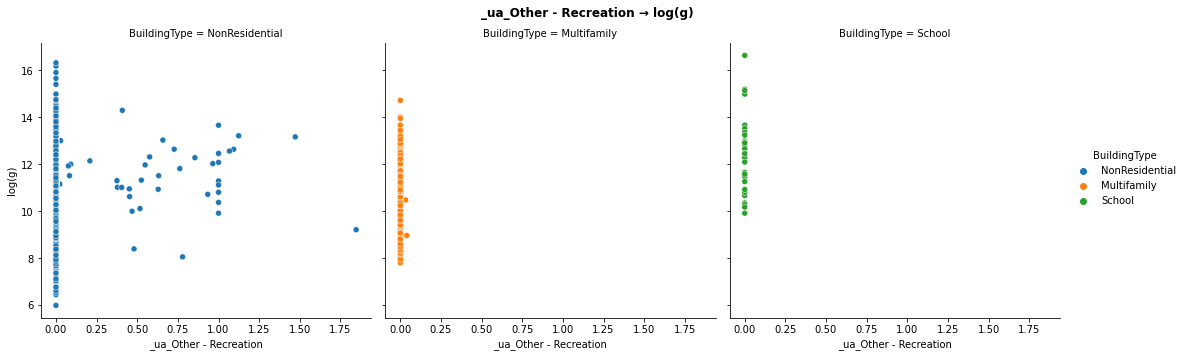

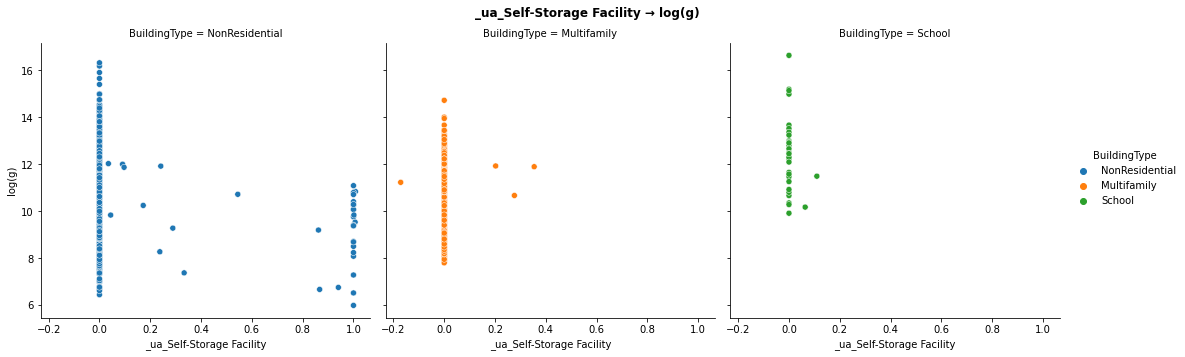

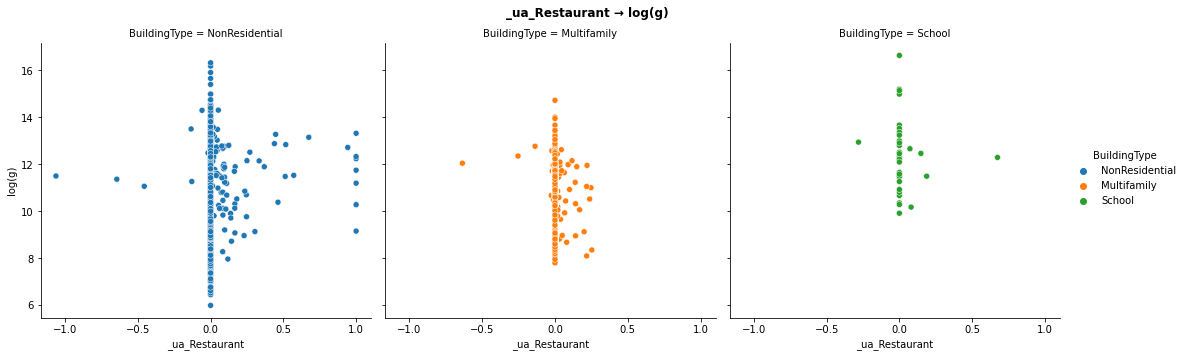

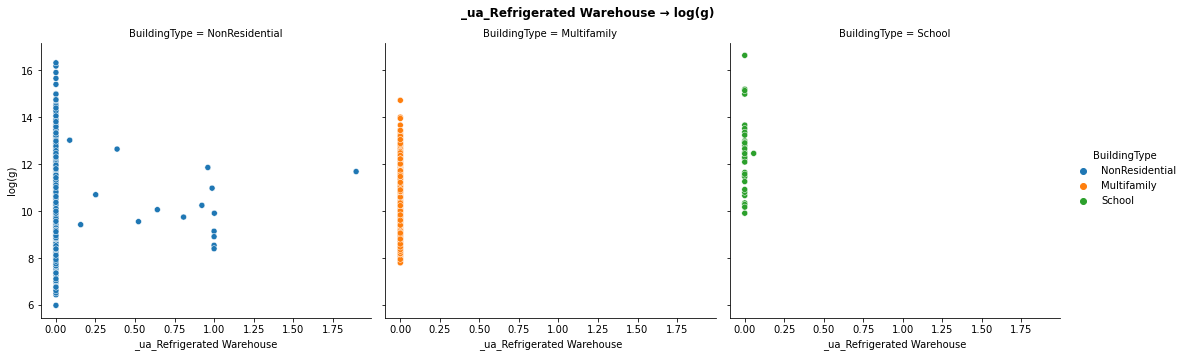

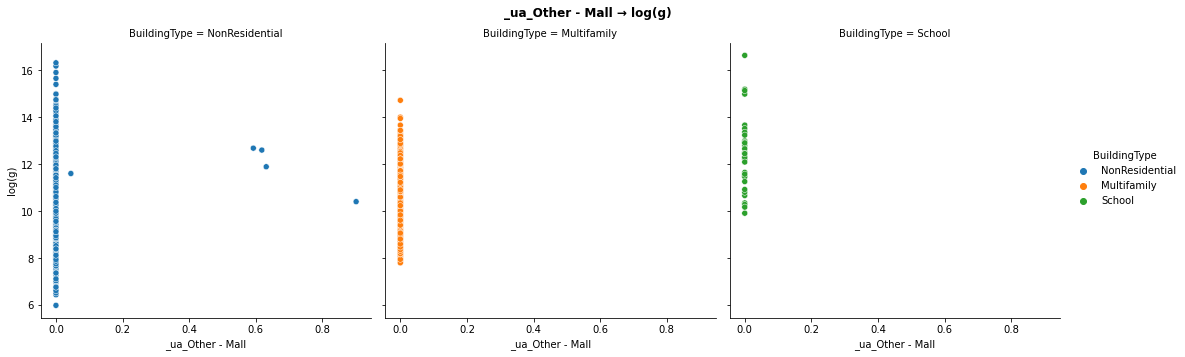

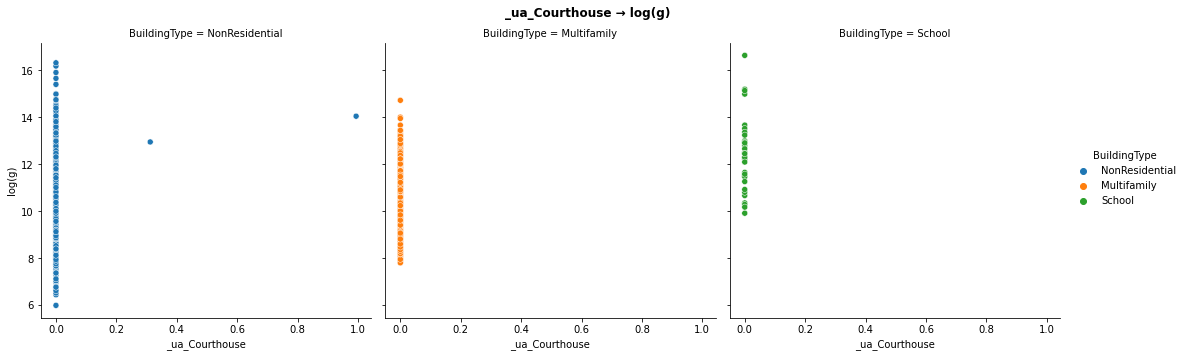

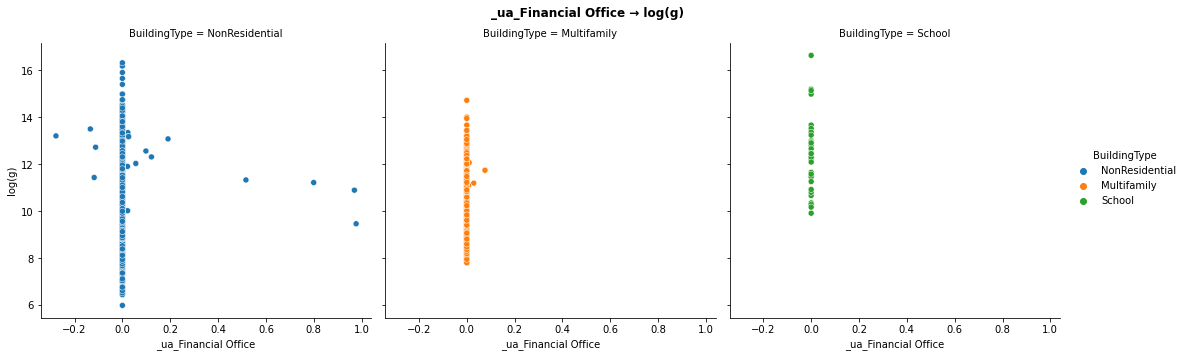

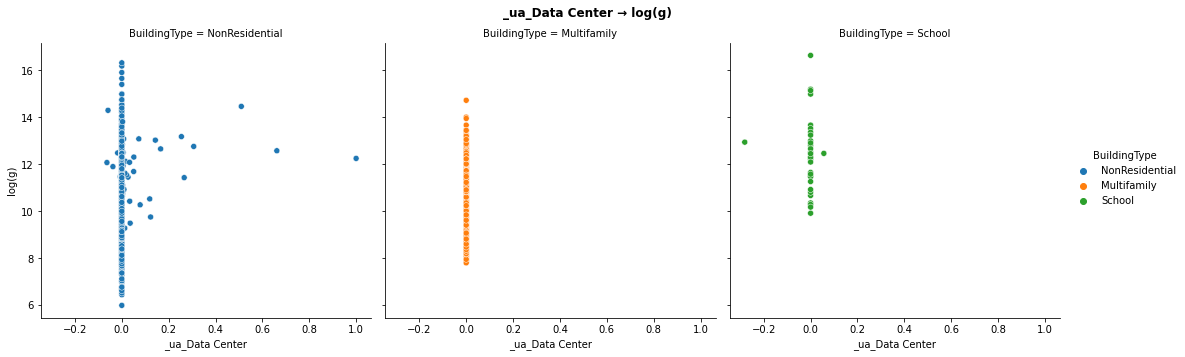

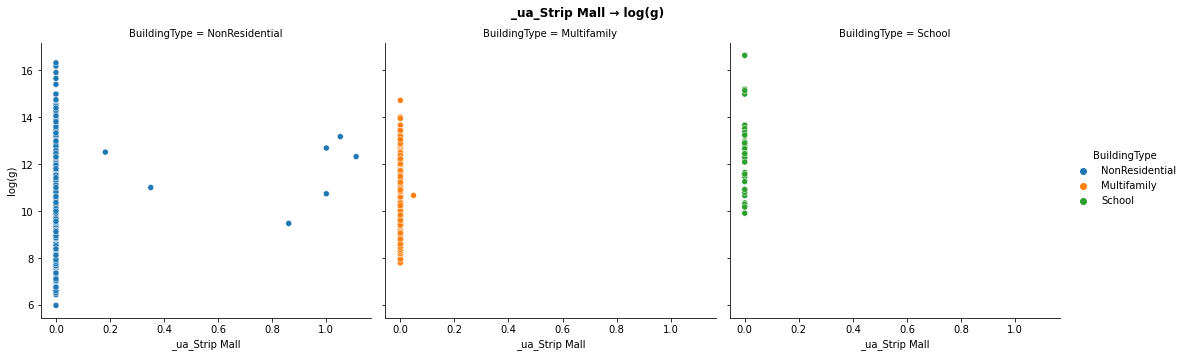

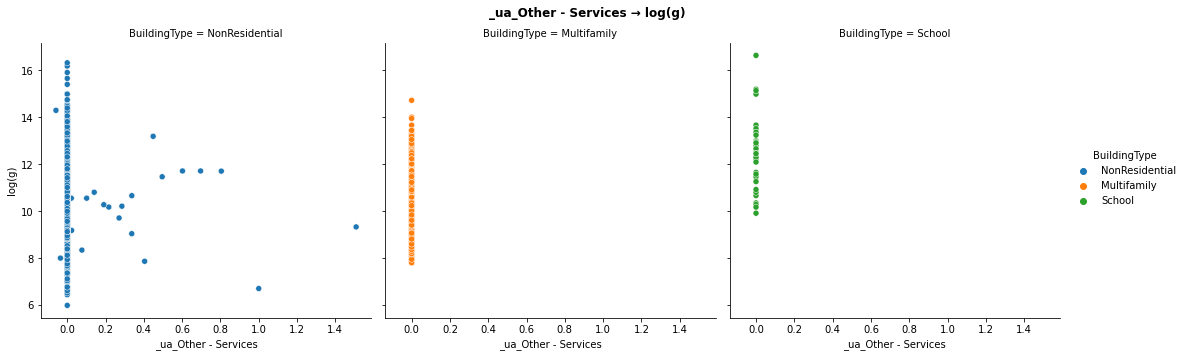

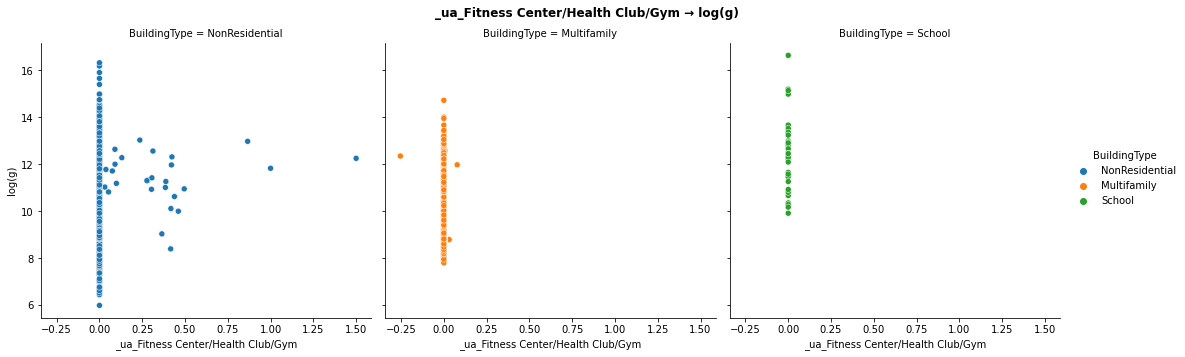

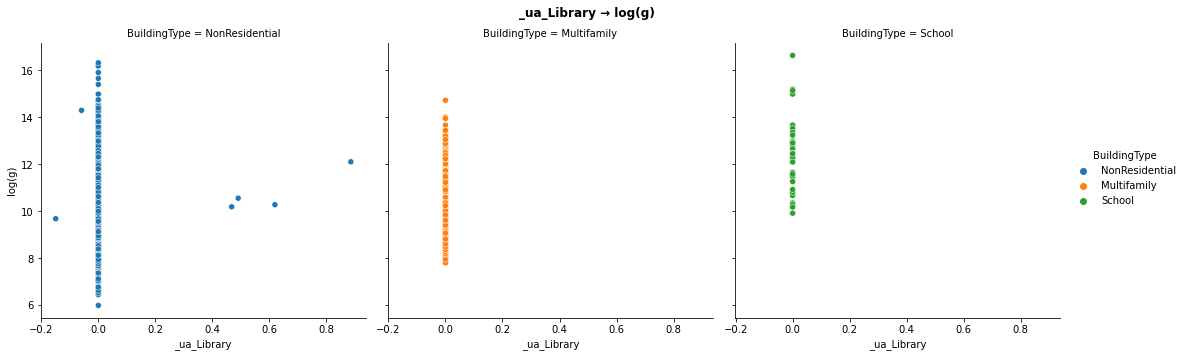

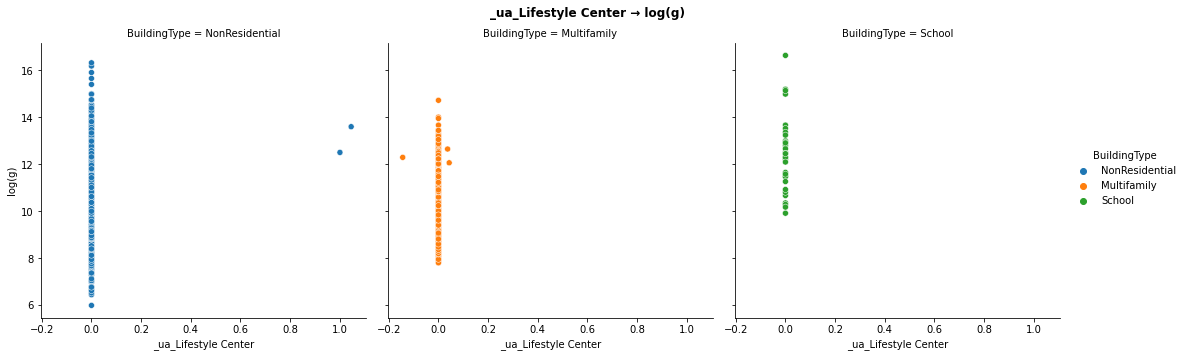

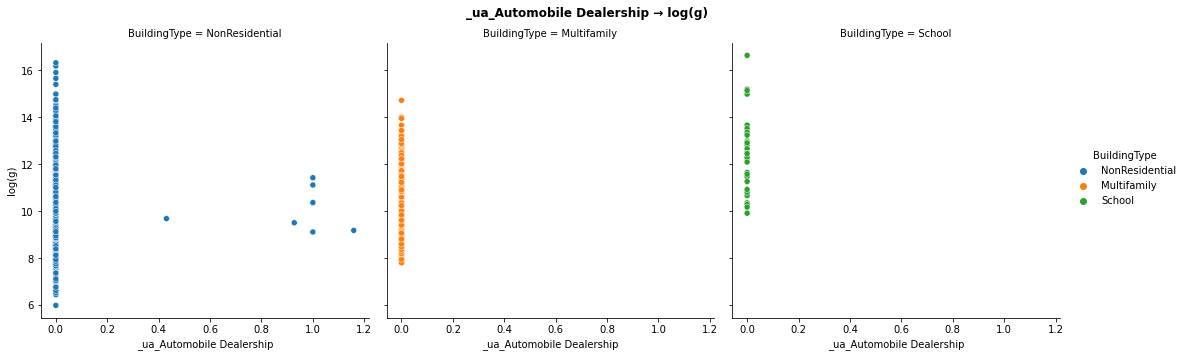

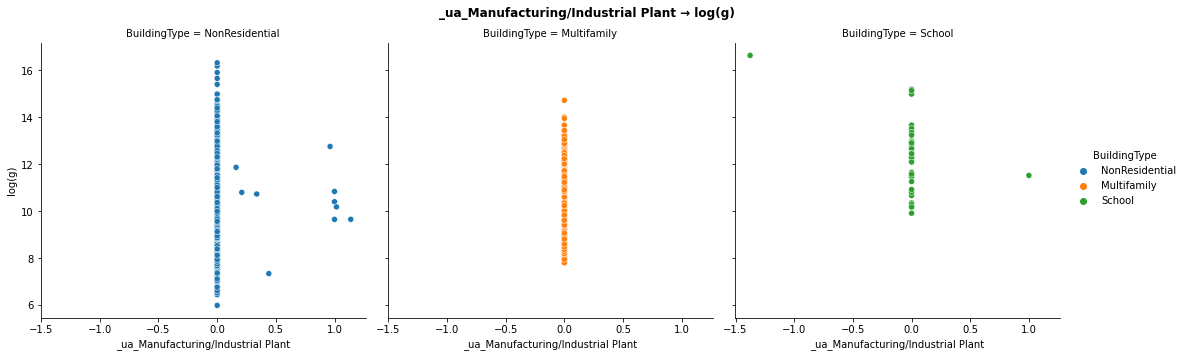

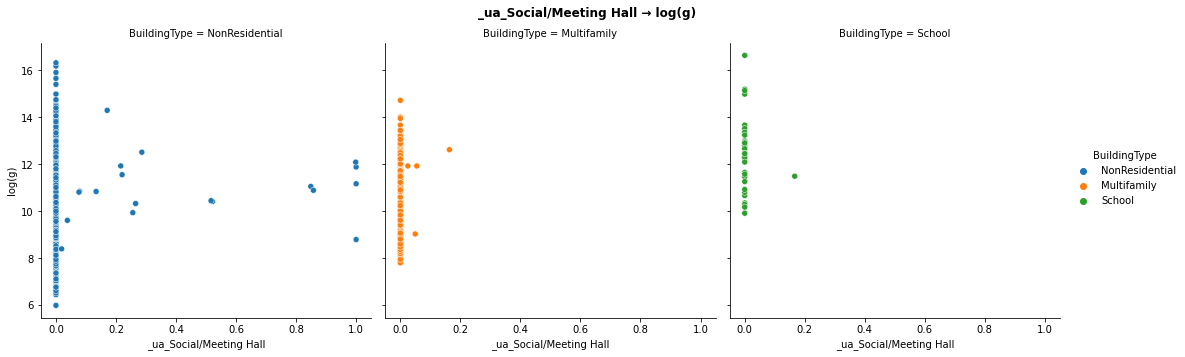

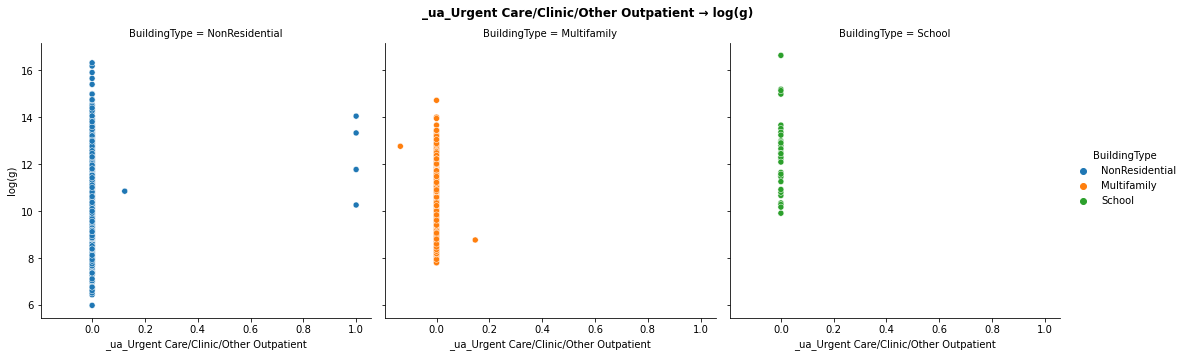

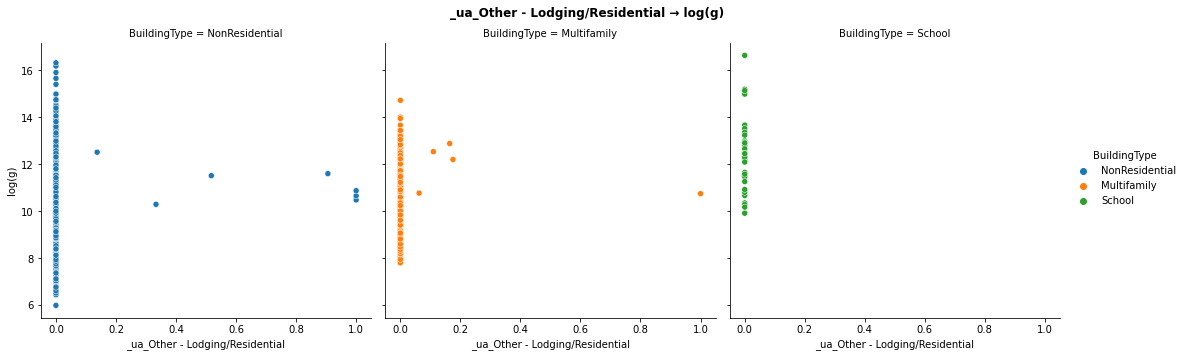

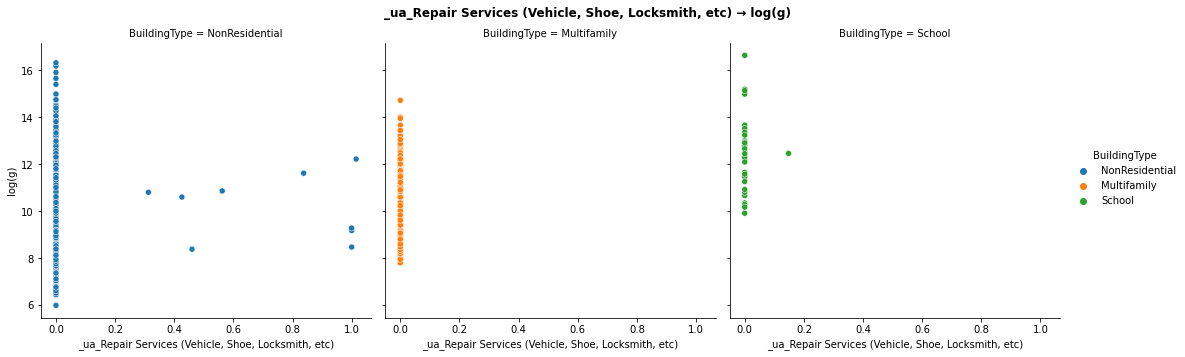

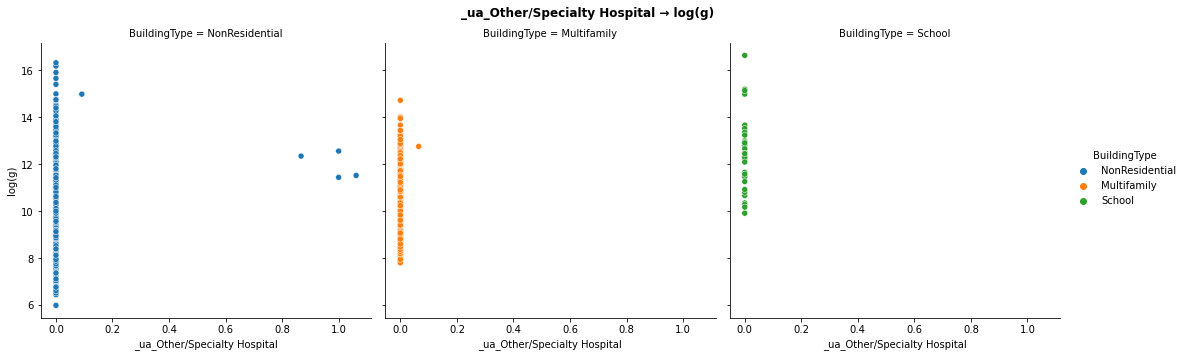

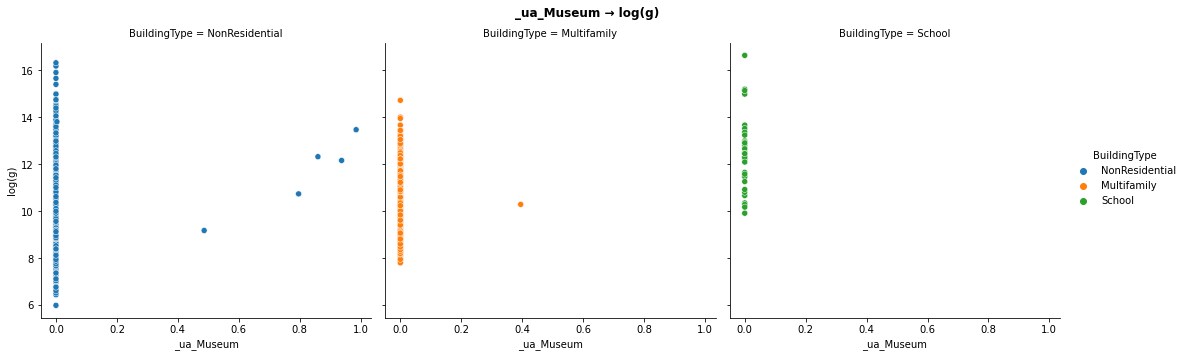

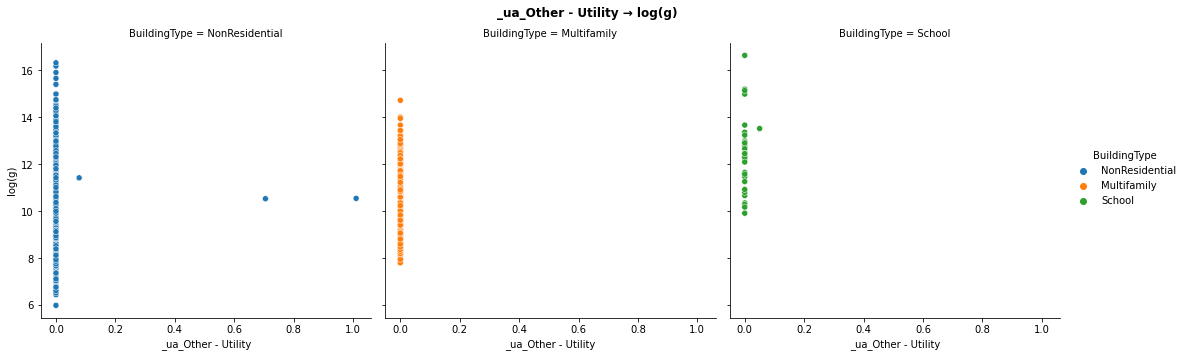

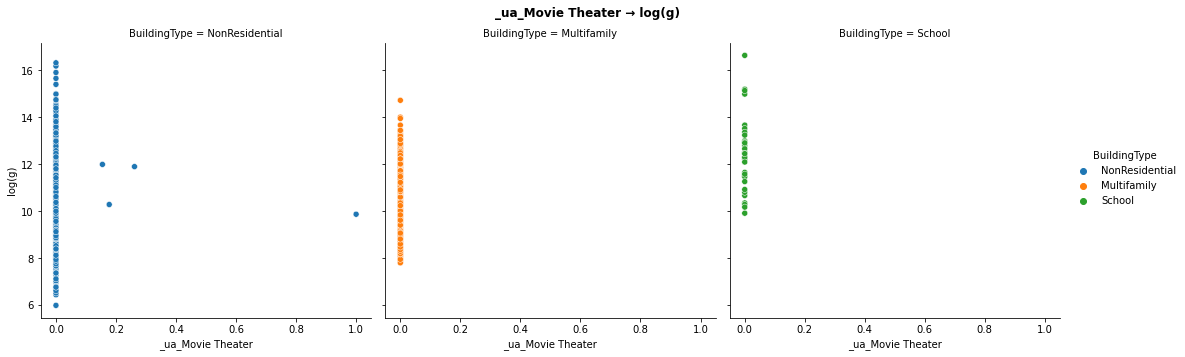

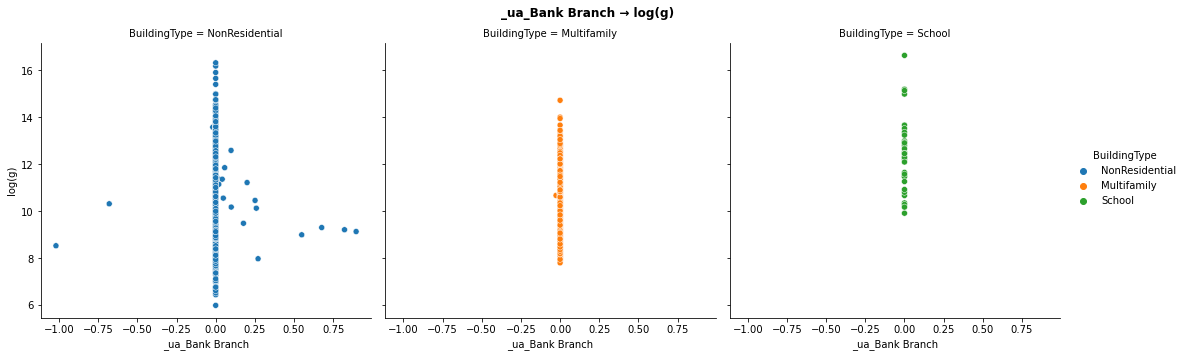

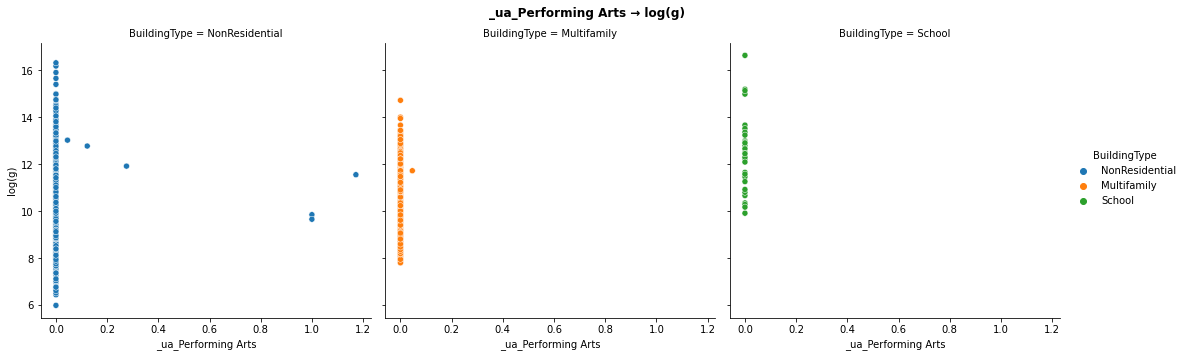

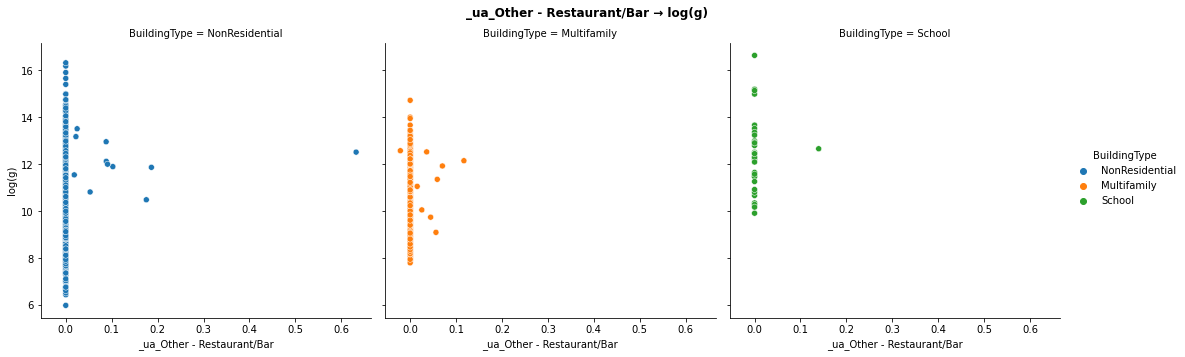

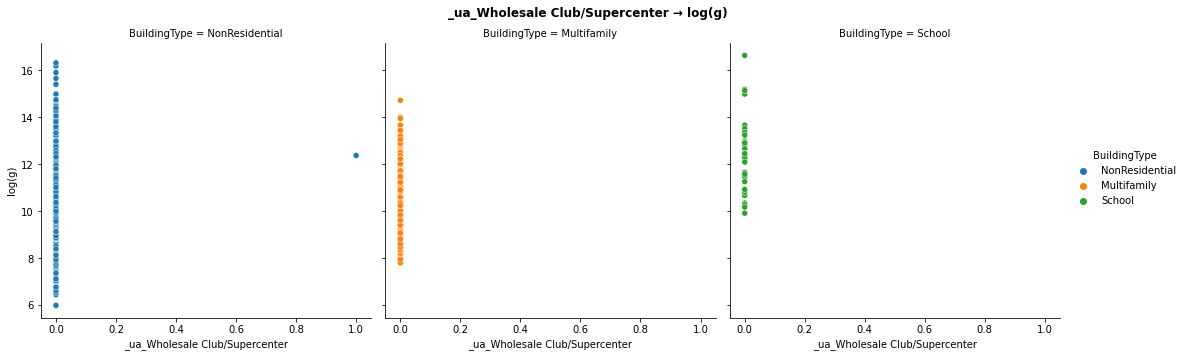

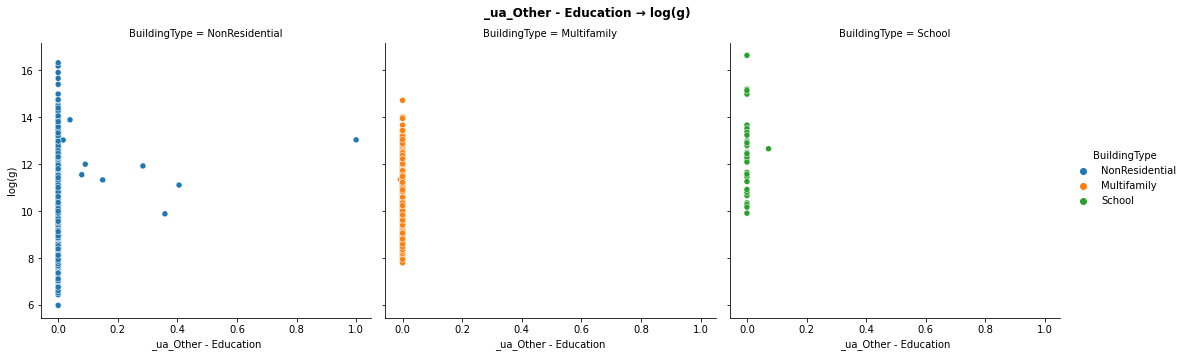

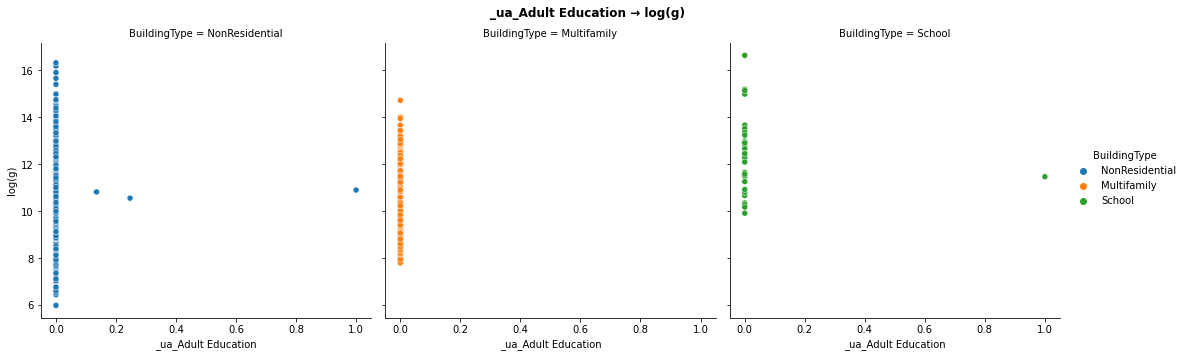

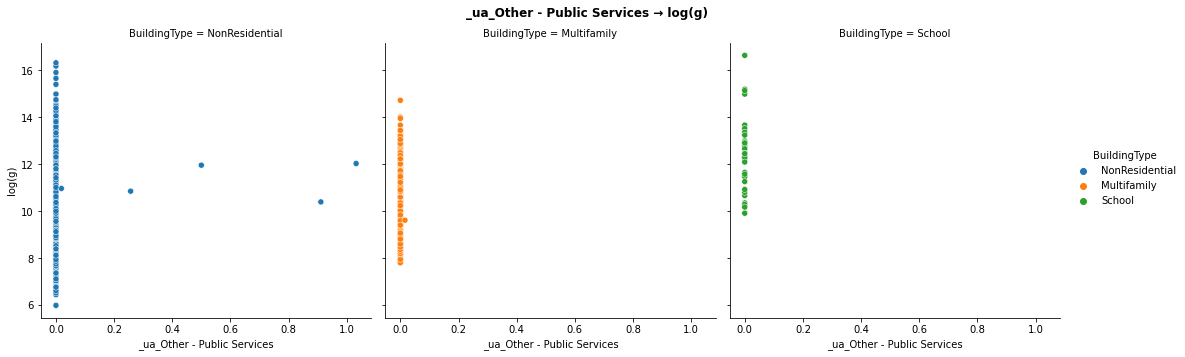

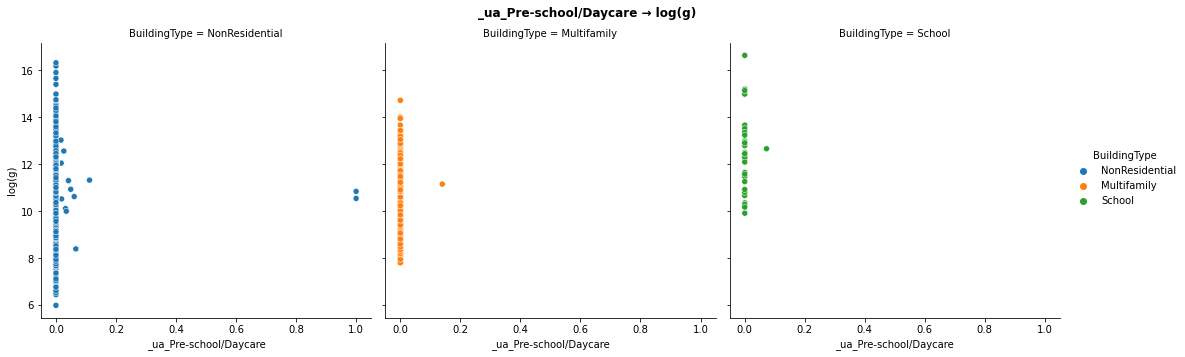

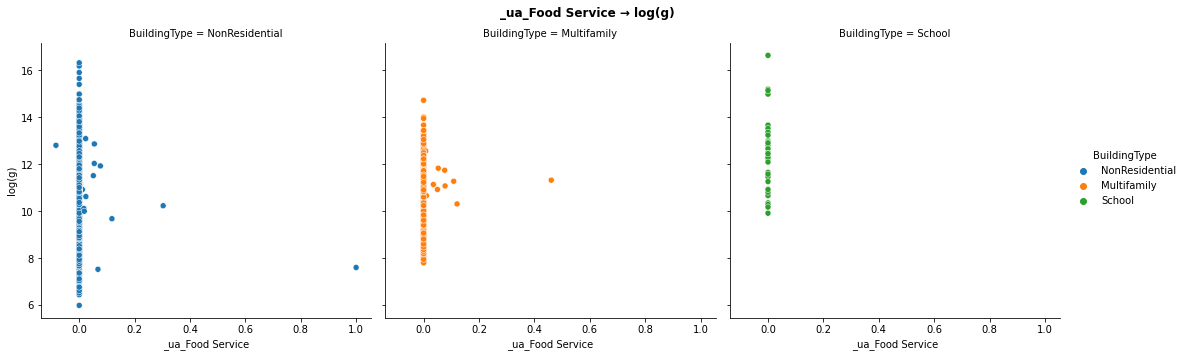

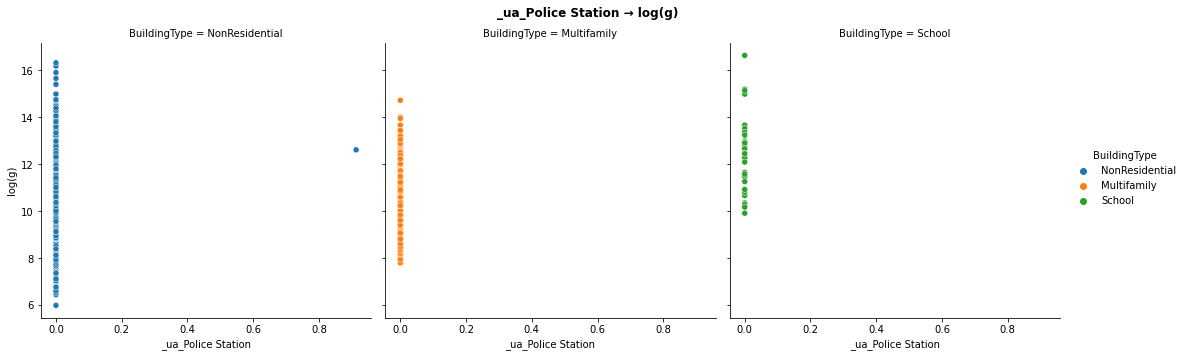

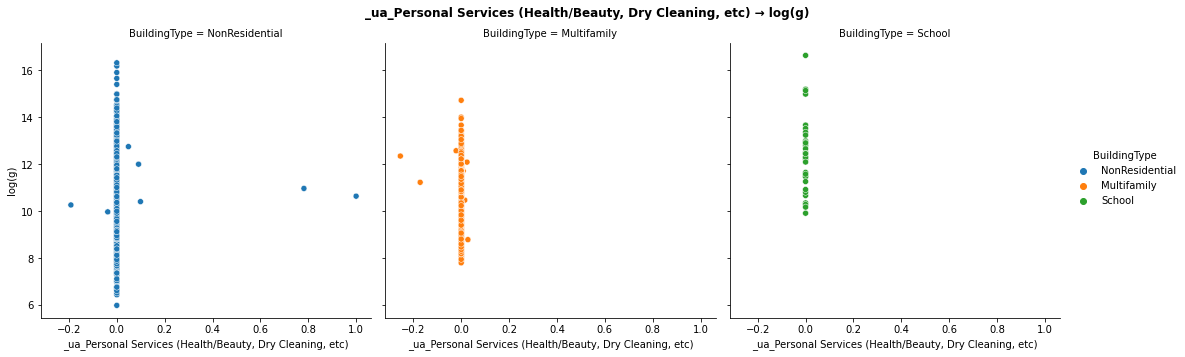

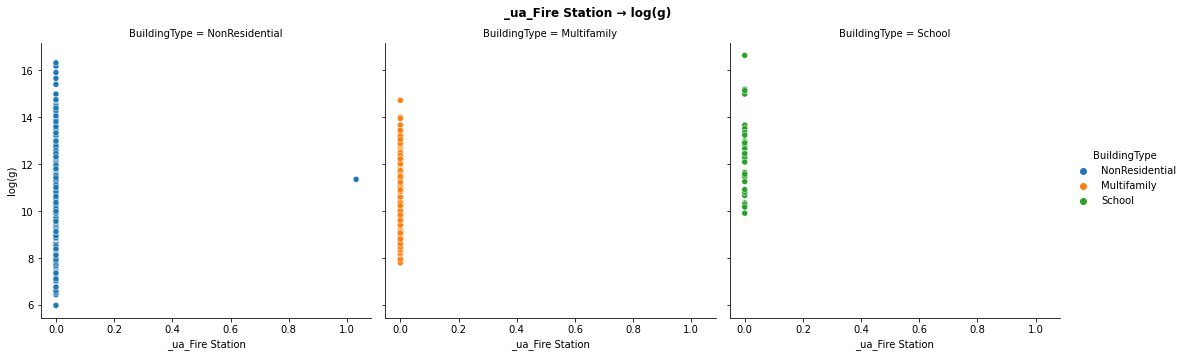

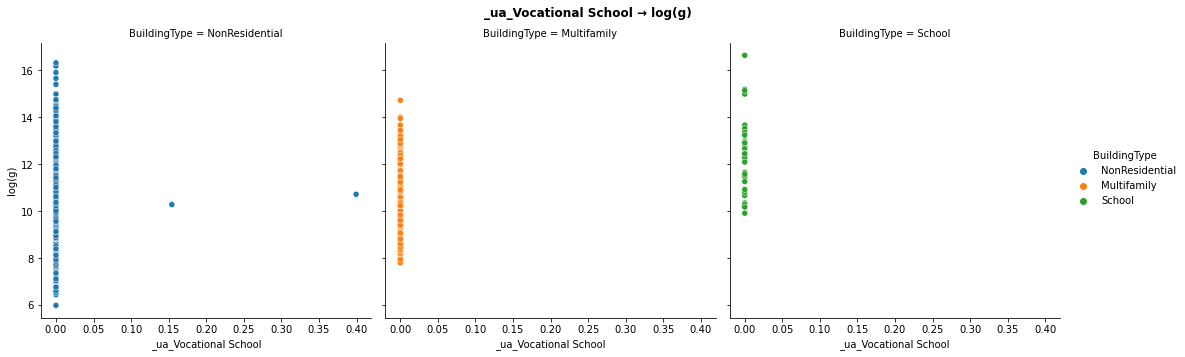

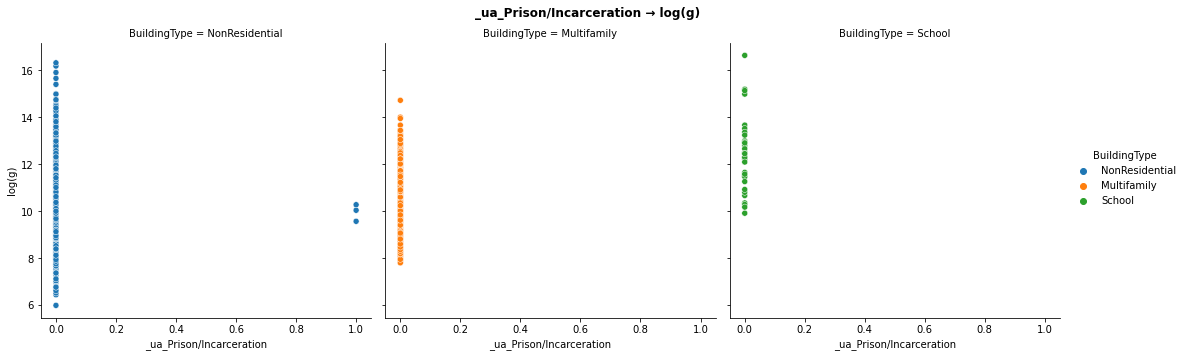

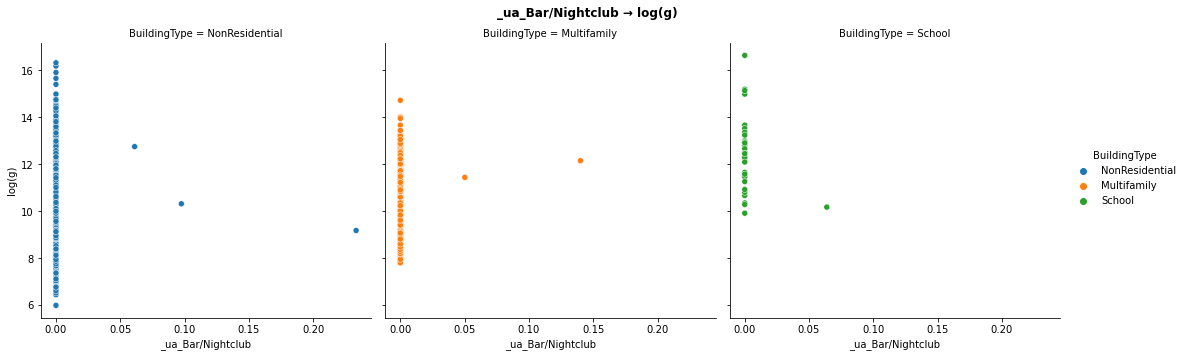

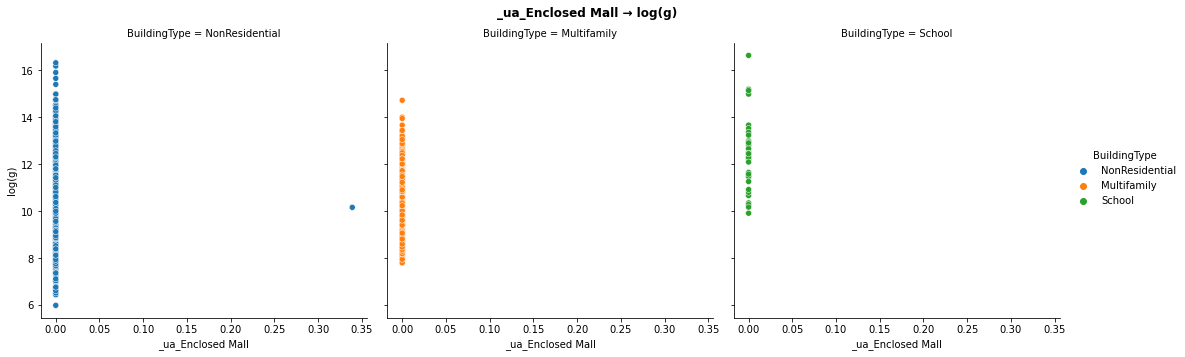

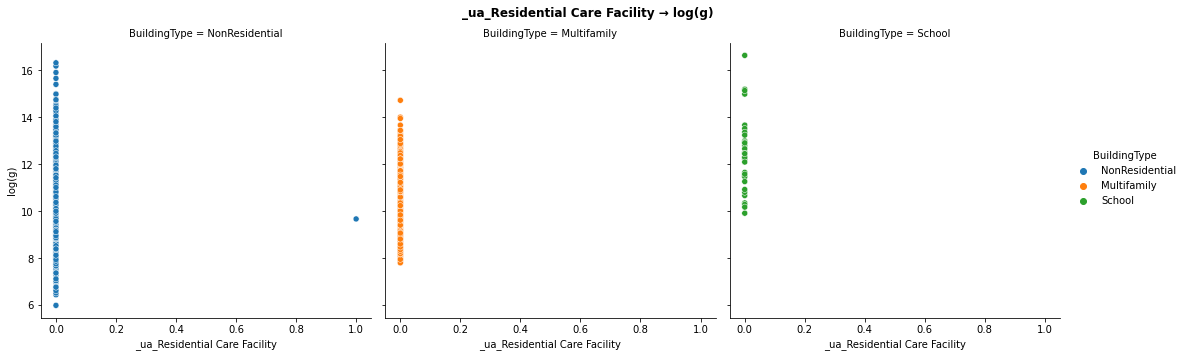

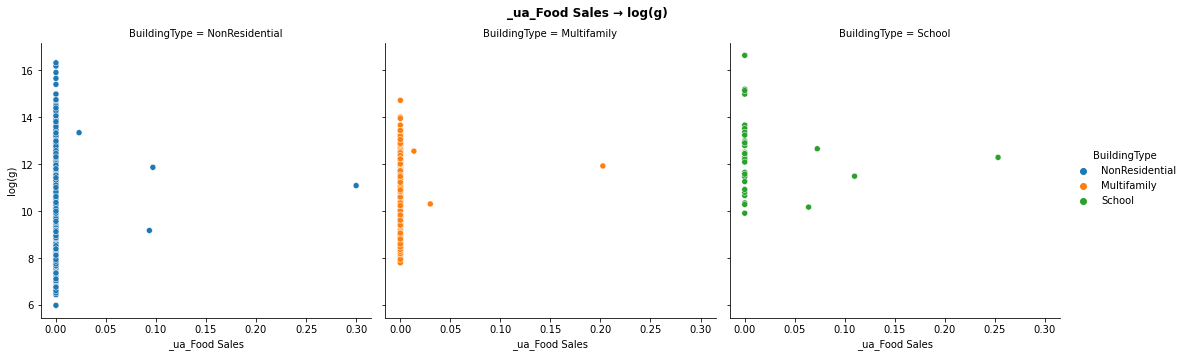

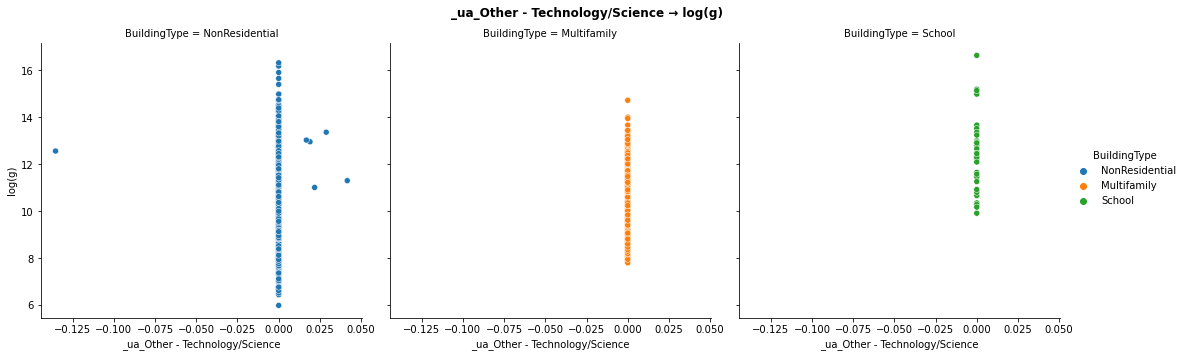

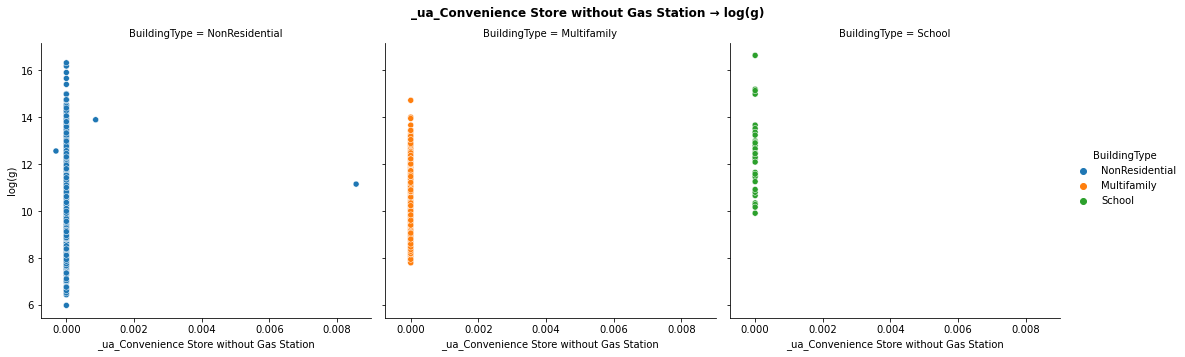

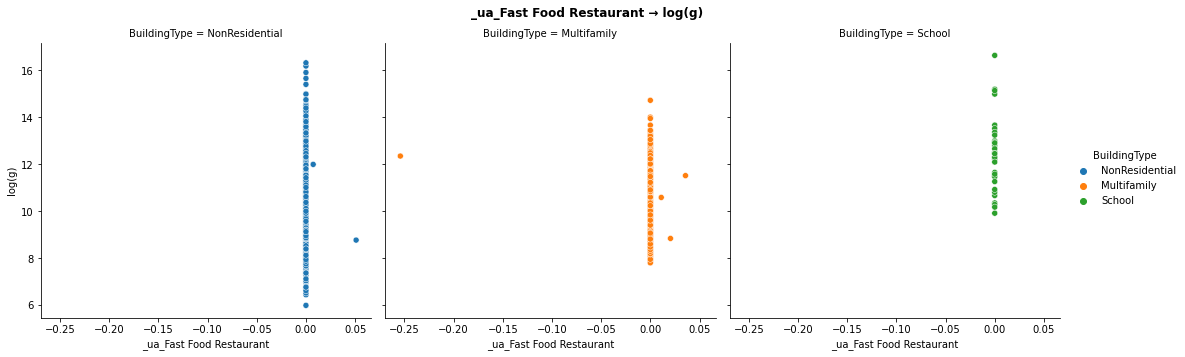

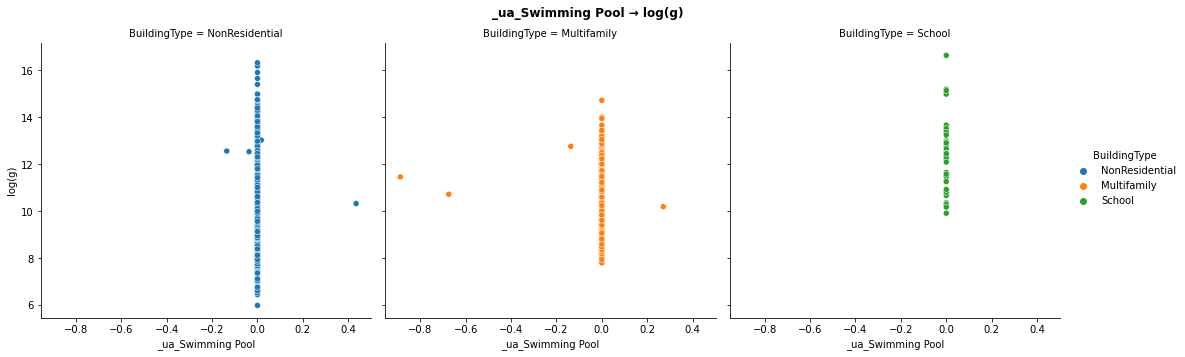

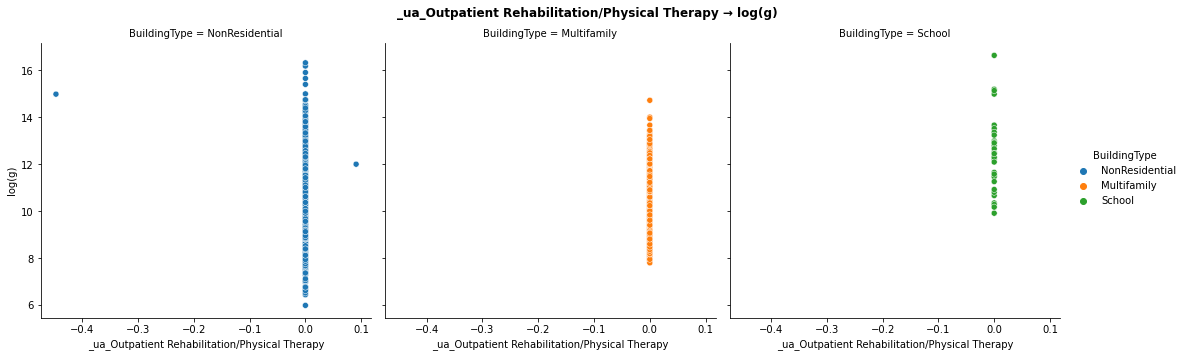

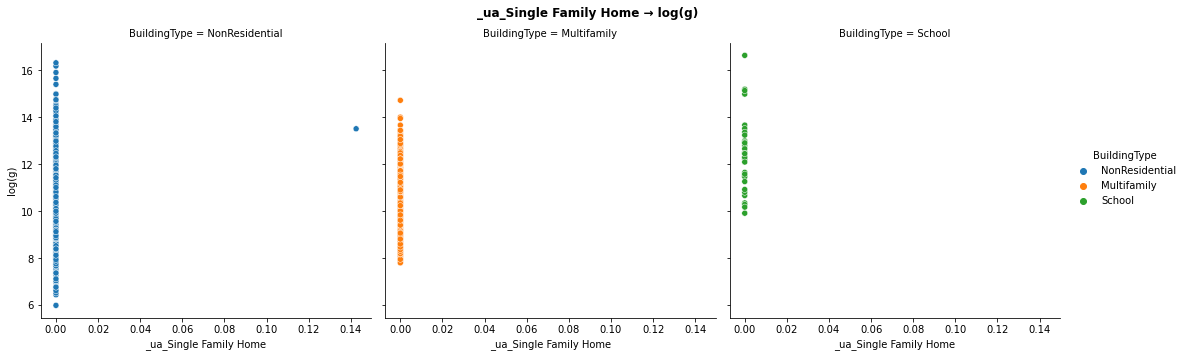

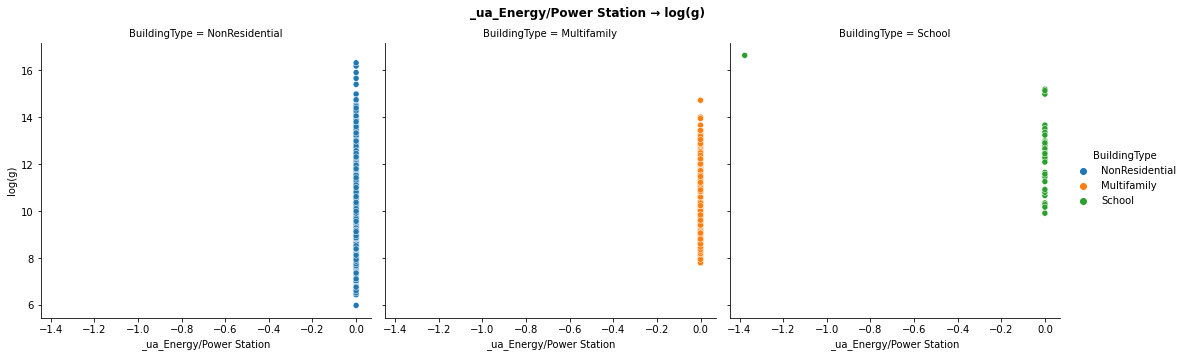

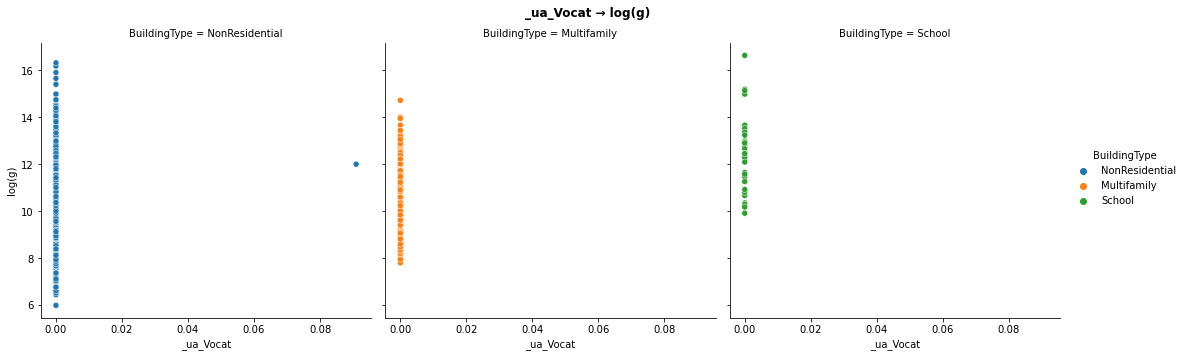

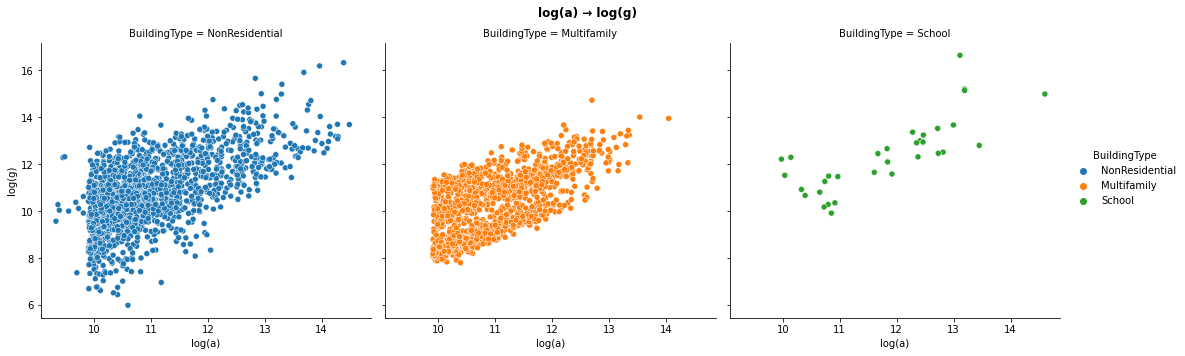

In [98]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [99]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


_ua_Multifamily Housing  _ua_Office  _ua_Parking  \
id                                                        
32                    0.000000    0.000000     0.264690   
43                    0.000000    1.529857     0.000000   
100                   0.000000    0.827762     0.476520   
234                   0.000000    0.094051     0.000000   
238                   0.000000    0.636102     0.130034   
247                   0.000000    0.208310     0.000000   
248                   0.000000    0.196675     0.000000   
264                   0.528618    0.000000     0.269342   
265                   0.698949    0.234320     0.000000   
267                   0.000000    0.000000     0.469613   
354                   0.000000    0.727196     0.176329   
355                   0.000000    0.941514     0.306953   
388                   0.000000    1.129987     0.062910   
393                   0.000000    0.507635     0.530224   
415                   0.000000    0.851766     0.168068   
432                   0.000000    0.563233     0.599620   
460                   0.000000    0.746675    -0.042037   
525                   0.000000   -0.058878     0.000000   
601                   0.342063    0.000000     0.517471   
604                   0.000000    0.862677     0.096215   
657                   0.658852    0.000000     0.745916   
772                   0.000000    0.787553     0.237632   
804                   0.000000    0.000000     1.061245   
812                   0.000000   -0.072173     0.000000   
843                   0.000000    0.000000     0.178801   
19464                 1.412625    0.044553     0.430282   
20163                 0.801160    0.000000     0.209411   
20211                 0.000000    0.089744     0.000000   
21138                 0.000000    0.858491     0.723540   
21210                 0.810424    0.034184     0.243854   
21445                 0.000000    0.922255     0.680591   
21945                 0.000000    0.000000     1.119784   
22839                 1.402677    0.000000     0.218674   
23113                 0.000000    0.000000     0.477029   
23373                 1.170681    0.016925     0.360228   
23816                 0.633062    0.000000     0.424731   
23894                 0.841384    0.190099     0.112459   
24579                 0.000000    0.432277    -0.358610   
24646                 0.000000   -0.135405     0.000000   
25708                 0.896716    0.000000     0.000000   
25932                 0.000000    0.567346     0.000000   
26331                 0.000000    0.818248     0.213028   
26555                 1.566952    0.000000     0.669627   
26994                 0.000000    0.346073     0.523911   
26997                 0.000000    0.489796     0.737609   
27059                 0.665517    0.000000     0.337774   
27100                 0.445902    0.000000     0.069831   
27922                 0.000000   -0.620638     0.000000   
30847                 0.659310    0.000000     0.275686   
32429                 0.000000   -0.179452     0.000000   
33254                 0.371284    0.000000     0.309068   
40348                 0.291245    0.000000     0.637822   
49698                 0.711573    0.000000     0.282816   
49710                 1.096916    0.000000     0.478090   
49776                 0.107954    0.546175     0.421722   
50057                 0.966192   -0.120378     0.110116   
50089                 0.984671    0.000000     0.219401   

       _ua_Non-Refrigerated Warehouse  _ua_Hotel  _ua_Other  _ua_Retail Store  \
id                                                                              
32                           0.000000   0.710101   0.000000          0.028360   
43                           0.929094   0.000000   0.000000          0.000000   
100                          0.000000   0.000000   0.047862         -0.352143   
234                          0.841983   0.000000   0.000000          0.000000   
238                          0.000000  

✔ No NA coefficient


#### Partition

In [100]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.5139659071671623
 OLS R2 score 0.25189146505643945
features : ['_ua_Multifamily Housing' '_ua_Office' '_ua_Parking'
 '_ua_Non-Refrigerated Warehouse' '_ua_Hotel' '_ua_Other'
 '_ua_Retail Store' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Senior Care Community' '_ua_College/University' '_ua_Medical Office'
 '_ua_Other - Entertainment/Public Assembly' '_ua_K-12 School'
 '_ua_Distribution Center' '_ua_Laboratory' '_ua_Worship Facility'
 '_ua_Supermarket/Grocery Store' '_ua_Residence Hall/Dormitory'
 '_ua_Other - Recreation' '_ua_Self-Storage Facility' '_ua_Restaurant'
 '_ua_Refrigerated Warehouse' '_ua_Other - Mall' '_ua_Courthouse'
 '_ua_Financial Office' '_ua_Data Center' '_ua_Strip Mall'
 '_ua_Other - Services' '_ua_Fitness Center/Health Club/Gym' '_ua_Library'
 '_ua_Lifestyle Center' '_ua_Automobile Dealership'
 '_ua_Manufacturing/Industrial Plant' '_ua_Social/Meeting Hall'
 '_ua_Urgent Care/Clinic/Other Outpatient'
 '_ua_Other - Lodging/Residential'
 '_ua_Repair

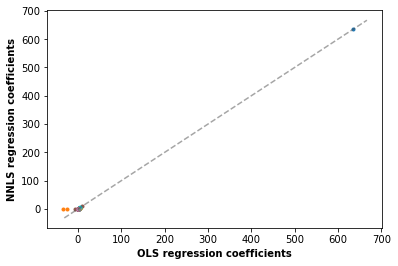

In [101]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives.

On pourra raffiner en éliminant ces variables peu pertinentes.

In [102]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.5581704184420627
SM OLS R2 score 0.25189146505427507
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     16.72
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           3.22e-97
Time:                        09:37:39   Log-Likelihood:                -1102.9
No. Observations:                 798   AIC:                             2320.
Df Residuals:                     741   BIC:                             2587.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

#### Validation croisée du score OLS

La présence des surfaces relatives par usage améliore améliore les performances (0.62 contre 0.56).

En revanche, la mauvaise qualité des données introduit du bruit.

La prochaine étape, à défaut de pouvoir corriger toutes les données, c'est de retirer les jeux incohérents des données d'apprentissage.

In [103]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.3723611  0.38772913 0.43849306]
mean scores : 0.39952776292639586
std scores : 0.028257919761218674


## Config 15 : $\ln{g} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Second test d'intégration.

$\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(g)\}$

$R^2_{15} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(g)\}\right)$ :
* $\mu = 0.42568789026257964$
* $\sigma = 0.08919399071216483$ 

Pour comparaison :

$R^2_4 \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_{15} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [104]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [105]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
32                            0.0                         0.0   
43                            0.0                         0.0   
100                           0.0                         0.0   
234                           0.0                         0.0   
238                           0.0                         0.0   
247                           0.0                         0.0   
248                           0.0                         0.0   
264                           0.0                         0.0   
265                           0.0                         1.0   
267                           0.0                         0.0   
354                           0.0                         0.0   
355                           0.0                         0.0   
388                           0.0                         0.0   
393                           0.0                         0.0   
415                           0.0                         0.0   
432                           0.0                         0.0   
460                           0.0                         0.0   
525                           0.0                         0.0   
601                           0.0                         0.0   
604                           0.0                         0.0   
657                           0.0                         0.0   
772                           0.0                         0.0   
804                           0.0                         0.0   
812                           0.0                         0.0   
843                           0.0                         0.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
20211                         0.0                         0.0   
21138                         0.0                         0.0   
21210                         0.0                         1.0   
21445                         0.0                         0.0   
21945                         0.0                         0.0   
22839                         0.0                         0.0   
23113                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
24579                         0.0                         0.0   
24646                         0.0                         0.0   
25708                         1.0                         0.0   
25932                         0.0                         0.0   
26331                         0.0                         0.0   
26555                         1.0                         0.0   
26994                         0.0                         0.0   
26997                         0.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
27922                         0.0                         0.0   
30847                         0.0                         1.0   
32429                         0.0                         0.0   
33254                         0.0                         0.0   
40348                         0.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
49776                         0.0                         0.0   
50057                         0.0                         0.0   
50089                         1.0                         0.0   

       ptype_Small- and Mid-Sized Office  ptype_Other  ptype_Warehouse  \
id                                                                       
32                     

✔ No NA coefficient


#### Partition

In [106]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.46956398365733854
 OLS R2 score 0.22646562494760292
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'age'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Parking'
 '_ua_Non-Refrigerated Warehouse' '_ua_Hotel' '_ua_Other'
 '_ua_Retail Store' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Senior Care Community' '_ua_College/University' '_ua_Medical Office'
 '_ua_Other - Entertainment/Public Assembly' '_ua_K-12 School'
 '_ua_Distribution Center' '_ua_L

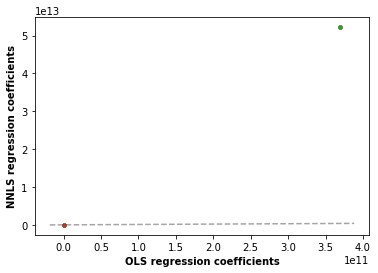

In [107]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives : on pourra raffiner en éliminant ces variables peu pertinentes.

In [108]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.613018049919859
SM OLS R2 score 0.22652981812470918
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     14.00
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          5.43e-102
Time:                        09:43:53   Log-Likelihood:                -1050.0
No. Observations:                 798   AIC:                             2264.
Df Residuals:                     716   BIC:                             2648.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------

#### Validation croisée du score OLS

La présence des surfaces relatives par usage améliore améliore les performances (0.62 contre 0.56).

En revanche, la mauvaise qualité des données introduit du bruit.

La propchaine étape, à défaut de pouvoir corriger toutes les données, c'est de retirer les jeux incohérents des données d'apprentissage.

In [109]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.31367184 0.43146987 0.53192196]
mean scores : 0.42568789026257964
std scores : 0.08919399071216483


## Config 16 : $\ln{g} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Second test d'intégration avec sélection et retrait de variables non pertinentes.

$\{t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a) : \log(g)\}$

Cela permet de dépasser les 70 % sur de la simple OLS avec seulement 27 variables.

Les nouvelles $p$-values > 0.05 permettent d'envisager d'itérer et peut-être encore améliorer.

$R^2_{16, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(g)\}\right)$ :
* $\mu = 0.4737010072183854$
* $\sigma = 0.024612104010330545$

Pour comparaison :

$R^2_{15, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(g)\}\right)$ :
* $\mu = 0.42568789026257964$
* $\sigma = 0.08919399071216483$ 

$R^2_{4, OLS} \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

$R^2_{16, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{15, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_{4, OLS} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [110]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [111]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
32                            0.0                         0.0   
43                            0.0                         0.0   
100                           0.0                         0.0   
234                           0.0                         0.0   
238                           0.0                         0.0   
247                           0.0                         0.0   
248                           0.0                         0.0   
264                           0.0                         0.0   
265                           0.0                         1.0   
267                           0.0                         0.0   
354                           0.0                         0.0   
355                           0.0                         0.0   
388                           0.0                         0.0   
393                           0.0                         0.0   
415                           0.0                         0.0   
432                           0.0                         0.0   
460                           0.0                         0.0   
525                           0.0                         0.0   
601                           0.0                         0.0   
604                           0.0                         0.0   
657                           0.0                         0.0   
772                           0.0                         0.0   
804                           0.0                         0.0   
812                           0.0                         0.0   
843                           0.0                         0.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
20211                         0.0                         0.0   
21138                         0.0                         0.0   
21210                         0.0                         1.0   
21445                         0.0                         0.0   
21945                         0.0                         0.0   
22839                         0.0                         0.0   
23113                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
24579                         0.0                         0.0   
24646                         0.0                         0.0   
25708                         1.0                         0.0   
25932                         0.0                         0.0   
26331                         0.0                         0.0   
26555                         1.0                         0.0   
26994                         0.0                         0.0   
26997                         0.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
27922                         0.0                         0.0   
30847                         0.0                         1.0   
32429                         0.0                         0.0   
33254                         0.0                         0.0   
40348                         0.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
49776                         0.0                         0.0   
50057                         0.0                         0.0   
50089                         1.0                         0.0   

       ptype_Small- and Mid-Sized Office  ptype_Other  ptype_Warehouse  \
id                                                                       
32                     

✔ No NA coefficient


#### Partition

In [112]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.46956398365733854
 OLS R2 score 0.22646562494760292
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'age'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Parking'
 '_ua_Non-Refrigerated Warehouse' '_ua_Hotel' '_ua_Other'
 '_ua_Retail Store' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Senior Care Community' '_ua_College/University' '_ua_Medical Office'
 '_ua_Other - Entertainment/Public Assembly' '_ua_K-12 School'
 '_ua_Distribution Center' '_ua_L

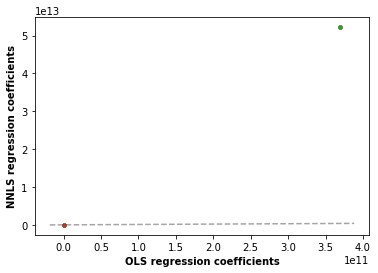

In [113]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives : on pourra raffiner en éliminant ces variables peu pertinentes.

In [114]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.613018049919859
SM OLS R2 score 0.22652981812470918
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     14.00
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          5.43e-102
Time:                        09:50:10   Log-Likelihood:                -1050.0
No. Observations:                 798   AIC:                             2264.
Df Residuals:                     716   BIC:                             2648.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [115]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
def sm_ols_2(X_train, X_test, y_train, y_test):
    _X_train = sm.add_constant(X_train)
    _X_test = sm.add_constant(X_test)
    mod = sm.OLS(y_train, _X_train)
    res = mod.fit()
    y_verif_sm_ols = res.predict(_X_train)
    y_pred_sm_ols = res.predict(_X_test)
    r2_verif_sm_ols = r2_score(y_train, y_verif_sm_ols)
    print("SM OLS R2 verif", r2_verif_sm_ols)
    r2_score_sm_ols = r2_score(y_test, y_pred_sm_ols)
    print("SM OLS R2 score", r2_score_sm_ols)
    print(res.summary())
    return res

res = sm_ols_2(X_train, X_test, y_train, y_test)
print(type(res))

SM OLS R2 verif 0.613018049919859
SM OLS R2 score 0.22652981812470918
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     14.00
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          5.43e-102
Time:                        09:50:18   Log-Likelihood:                -1050.0
No. Observations:                 798   AIC:                             2264.
Df Residuals:                     716   BIC:                             2648.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [116]:
import pandas as pd
def get_coefs(fit_sm_ols):
    _coefs = res.summary().tables[1]
    coefs = pd.DataFrame(_coefs.data)
    coefs.columns = list(coefs.loc[0])
    coefs = coefs.drop(index=0)
    coefs = coefs.set_index('')
    coefs = coefs.astype(float)
    return coefs

coefs = get_coefs(res)
display(coefs)

is_relevant = coefs['P>|t|'] < 0.05
display(coefs[is_relevant])
display(coefs[~is_relevant])

coef  std err       t  P>|t|  [0.025  \
                                                                            
const                             -2.3272    0.798  -2.916  0.004  -3.894   
ptype_Low-Rise Multifamily        -0.2372    0.458  -0.518  0.604  -1.136   
ptype_Mid-Rise Multifamily         0.2171    0.455   0.477  0.633  -0.676   
ptype_Small- and Mid-Sized Office -0.2390    0.491  -0.487  0.626  -1.202   
ptype_Other                        0.2412    0.481   0.501  0.616  -0.704   
...                                   ...      ...     ...    ...     ...   
_ua_Energy/Power Station           0.0000    0.000     NaN    NaN   0.000   
_ua_Vocat                          0.0000    0.000     NaN    NaN   0.000   
star_score                        -0.0083    0.002  -5.261  0.000  -0.011   
log(n_l)                          -0.2196    0.119  -1.838  0.066  -0.454   
log(a)                             1.1445    0.065  17.574  0.000   1.017   

                                   0.975]  
                                           
const                              -0.760  
ptype_Low-Rise Multifamily          0.661  
ptype_Mid-Rise Multifamily          1.111  
ptype_Small- and Mid-Sized Office   0.724  
ptype_Other                         1.186  
...                                   ...  
_ua_Energy/Power Station            0.000  
_ua_Vocat                           0.000  
star_score                         -0.005  
log(n_l)                            0.015  
log(a)                              1.272  

[95 rows x 6 columns]

coef  std err       t  P>|t|  \
                                                                            
const                                     -2.3272    0.798  -2.916  0.004   
ptype_Self-Storage Facility               -5.3733    2.637  -2.037  0.042   
ptype_Hospital                             2.3160    1.092   2.120  0.034   
age                                        0.0065    0.001   5.171  0.000   
_ua_Multifamily Housing                    0.7180    0.273   2.634  0.009   
_ua_Office                                 1.1959    0.420   2.846  0.005   
_ua_Other                                  1.1846    0.399   2.971  0.003   
_ua_Other - Entertainment/Public Assembly  1.2845    0.464   2.768  0.006   
_ua_Supermarket/Grocery Store              2.9257    1.217   2.403  0.016   
_ua_Other - Recreation                     2.7989    0.732   3.825  0.000   
_ua_Other - Mall                           3.8366    1.547   2.480  0.013   
_ua_Lifestyle Center                       2.1630    0.966   2.239  0.025   
_ua_Social/Meeting Hall                    1.4855    0.560   2.654  0.008   
_ua_Museum                                 2.9781    0.818   3.641  0.000   
_ua_Other - Public Services                2.0382    0.979   2.082  0.038   
star_score                                -0.0083    0.002  -5.261  0.000   
log(a)                                     1.1445    0.065  17.574  0.000   

                                           [0.025  0.975]  
                                                           
const                                      -3.894  -0.760  
ptype_Self-Storage Facility               -10.551  -0.196  
ptype_Hospital                              0.172   4.460  
age                                         0.004   0.009  
_ua_Multifamily Housing                     0.183   1.253  
_ua_Office                                  0.371   2.021  
_ua_Other                                   0.402   1.967  
_ua_Other - Entertainment/Public Assembly   0.373   2.196  
_ua_Supermarket/Grocery Store               0.536   5.316  
_ua_Other - Recreation                      1.362   4.235  
_ua_Other - Mall                            0.800   6.873  
_ua_Lifestyle Center                        0.267   4.060  
_ua_Social/Meeting Hall                     0.387   2.584  
_ua_Museum                                  1.372   4.584  
_ua_Other - Public Services                 0.116   3.960  
star_score                                 -0.011  -0.005  
log(a)                                      1.017   1.272

coef  std err      t  P>|t|  \
                                                                                
ptype_Low-Rise Multifamily                     -0.2372    0.458 -0.518  0.604   
ptype_Mid-Rise Multifamily                      0.2171    0.455  0.477  0.633   
ptype_Small- and Mid-Sized Office              -0.2390    0.491 -0.487  0.626   
ptype_Other                                     0.2412    0.481  0.501  0.616   
ptype_Warehouse                                 0.1353    0.712  0.190  0.849   
...                                                ...      ...    ...    ...   
_ua_Outpatient Rehabilitation/Physical Therapy  0.0000    0.000    NaN    NaN   
_ua_Single Family Home                          0.0000    0.000    NaN    NaN   
_ua_Energy/Power Station                        0.0000    0.000    NaN    NaN   
_ua_Vocat                                       0.0000    0.000    NaN    NaN   
log(n_l)                                       -0.2196    0.119 -1.838  0.066   

                                                [0.025  0.975]  
                                                                
ptype_Low-Rise Multifamily                      -1.136   0.661  
ptype_Mid-Rise Multifamily                      -0.676   1.111  
ptype_Small- and Mid-Sized Office               -1.202   0.724  
ptype_Other                                     -0.704   1.186  
ptype_Warehouse                                 -1.262   1.533  
...                                                ...     ...  
_ua_Outpatient Rehabilitation/Physical Therapy   0.000   0.000  
_ua_Single Family Home                           0.000   0.000  
_ua_Energy/Power Station                         0.000   0.000  
_ua_Vocat                                        0.000   0.000  
log(n_l)                                        -0.454   0.015  

[78 rows x 6 columns]

In [117]:
not_relevant_vars = list(coefs[~is_relevant].index)
print(not_relevant_vars)

['ptype_Low-Rise Multifamily', 'ptype_Mid-Rise Multifamily', 'ptype_Small- and Mid-Sized Office', 'ptype_Other', 'ptype_Warehouse', 'ptype_Large Office', 'ptype_Mixed Use Property', 'ptype_High-Rise Multifamily', 'ptype_Retail Store', 'ptype_Hotel', 'ptype_Worship Facility', 'ptype_Distribution Center', 'ptype_K-12 School', 'ptype_Senior Care Community', 'ptype_Medical Office', 'ptype_Supermarket / Grocery Store', 'ptype_Residence Hall', 'ptype_University', 'ptype_Refrigerated Warehouse', 'ptype_Restaurant', 'ptype_Laboratory', '_ua_Parking', '_ua_Non-Refrigerated Warehouse', '_ua_Hotel', '_ua_Retail Store', '_ua_Hospital (General Medical & Surgical)', '_ua_Senior Care Community', '_ua_College/University', '_ua_Medical Office', '_ua_K-12 School', '_ua_Distribution Center', '_ua_Laboratory', '_ua_Worship Facility', '_ua_Residence Hall/Dormitory', '_ua_Self-Storage Facility', '_ua_Restaurant', '_ua_Refrigerated Warehouse', '_ua_Courthouse', '_ua_Financial Office', '_ua_Data Center', '_ua

In [118]:
ml_data_16 = ml_data.drop(columns=not_relevant_vars)
display(ml_data_16)

ptype_Self-Storage Facility  ptype_Hospital  age  \
id                                                        
1                              0.0             0.0   89   
2                              0.0             0.0   20   
3                              0.0             0.0   47   
5                              0.0             0.0   90   
8                              0.0             0.0   36   
...                            ...             ...  ...   
50221                          0.0             0.0   34   
50223                          0.0             0.0   12   
50224                          0.0             0.0   42   
50225                          0.0             0.0   27   
50226                          0.0             0.0   78   

       _ua_Multifamily Housing  _ua_Office  _ua_Other  \
id                                                      
1                          0.0    0.000000        0.0   
2                          0.0    0.000000        0.0   
3                          0.0    0.000000        0.0   
5                          0.0    0.000000        0.0   
8                          0.0    0.000000        0.0   
...                        ...         ...        ...   
50221                      0.0    0.000000        0.0   
50223                      0.0    0.000000        0.0   
50224                      0.0    0.000000        0.0   
50225                      0.0    0.018261        0.0   
50226                      0.0    0.024072        0.0   

       _ua_Other - Entertainment/Public Assembly  \
id                                                 
1                                            0.0   
2                                            0.0   
3                                            0.0   
5                                            0.0   
8                                            0.0   
...                                          ...   
50221                                        0.0   
50223                                        0.0   
50224                                        0.0   
50225                                        0.0   
50226                                        0.0   

       _ua_Supermarket/Grocery Store  _ua_Other - Recreation  \
id                                                             
1                                0.0                0.000000   
2                                0.0                0.000000   
3                                0.0                0.000000   
5                                0.0                0.000000   
8                                0.0                0.000000   
...                              ...                     ...   
50221                            0.0                1.000000   
50223                            0.0                1.000000   
50224                            0.0                0.576347   
50225                            0.0                0.468123   
50226                            0.0                0.453007   

       _ua_Other - Mall  _ua_Lifestyle Center  _ua_Social/Meeting Hall  \
id                                                                       
1                   0.0                   0.0                      0.0   
2                   0.0                   0.0                      0.0   
3                   0.0                   0.0                      0.0   
5                   0.0                   0.0                      0.0   
8                   0.0                   0.0                      0.0   
...                 ...                   ...                      ...   
50221               0.0                   0.0                      0.0   
50223               0.0                   0.0                      0.0   
50224               0.0                   0.0                      0.0   
50225               0.0                   0.0                      0.0   
50226               0.0                   0.0                      0.0   

       _ua_Museum  _ua_O

NNLS R2 score 0.48286485772046794
 OLS R2 score 0.5239419717113707
features : ['ptype_Self-Storage Facility' 'ptype_Hospital' 'age'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Other'
 '_ua_Other - Entertainment/Public Assembly'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Recreation'
 '_ua_Other - Mall' '_ua_Lifestyle Center' '_ua_Social/Meeting Hall'
 '_ua_Museum' '_ua_Other - Public Services' 'star_score' 'log(a)']
intercept (ols) : [-1.41023568]
intercept (nnls) : [-2.44064433]
coefficients (ols) : [[-1.56849873  1.62260766  0.00680919 -0.41971157 -0.24332077  0.56980267
   0.74056317  1.8222463   2.45872856  0.83470379  1.40120871  0.81198757
   1.88941826  1.3965683  -0.00746628  1.11531253]]
coefficients (nnls) : [[0.         1.84319614 0.00770497 0.         0.03206439 0.80881146
  0.92314905 2.30382785 2.81270949 1.11950514 1.62896271 1.0302759
  2.12292801 1.64232582 0.         1.13450296]]
SM OLS R2 verif 0.5319386831573698
SM OLS R2 score 0.523941971711372
                 

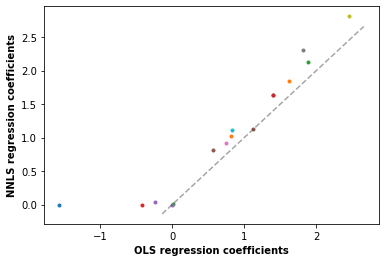

In [119]:
X, y = features_target_split(ml_data_16)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
sm_ols(X_train, X_test, y_train, y_test)

#### Validation croisée du score OLS

La présence des surfaces relatives par usage améliore améliore les performances (0.62 contre 0.56).

En revanche, la mauvaise qualité des données introduit du bruit.

La propchaine étape, à défaut de pouvoir corriger toutes les données, c'est de retirer les jeux incohérents des données d'apprentissage.

In [120]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.50479821 0.44461149 0.47169333]
mean scores : 0.4737010072183854
std scores : 0.024612104010330545


## Config 17 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Config 16 réduite au cas non résidentiel.

$\{t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a) : \log(g)\}$


$R^2_{17, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(g)\}\right)$ :
* $\mu = 0.4737010072183854$
* $\sigma = 0.024612104010330545$

Rappels pour comparaison :

$R^2_{17, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{16, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{15, OLS} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_{4, OLS} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$


In [121]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(r_data, config_name); # display(ml_data)

In [122]:
check_data(ml_data)

✘ Negative coefficients :


ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
265                           0.0                         1.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
21210                         0.0                         1.0   
22839                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
25708                         1.0                         0.0   
26555                         1.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
30847                         0.0                         1.0   
33254                         0.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
50057                         0.0                         0.0   
50089                         1.0                         0.0   

       ptype_High-Rise Multifamily  ptype_Senior Care Community  \
id                                                                
265                            0.0                          0.0   
19464                          0.0                          0.0   
20163                          1.0                          0.0   
21210                          0.0                          0.0   
22839                          1.0                          0.0   
23373                          1.0                          0.0   
23816                          0.0                          0.0   
23894                          0.0                          0.0   
25708                          0.0                          0.0   
26555                          0.0                          0.0   
27059                          0.0                          0.0   
27100                          0.0                          0.0   
30847                          0.0                          0.0   
33254                          0.0                          0.0   
49698                          0.0                          0.0   
49710                          0.0                          0.0   
50057                          1.0                          0.0   
50089                          0.0                          0.0   

       ptype_Mixed Use Property  ptype_Other  ptype_Residence Hall  \
id                                                                   
265                         0.0          0.0                   0.0   
19464                       0.0          0.0                   0.0   
20163                       0.0          0.0                   0.0   
21210                       0.0          0.0                   0.0   
22839                       0.0          0.0                   0.0   
23373                       0.0          0.0                   0.0   
23816                       0.0          0.0                   0.0   
23894                       0.0          0.0                   0.0   
25708                       0.0          0.0                   0.0   
26555                       0.0          0.0                   0.0   
27059                       0.0          0.0                   0.0   
27100                       0.0          0.0                   0.0   
30847                       0.0          0.0                   0.0   
33254                       1.0          0.0                   0.0   
49698                       0.0          0.0                   0.0   
49710                       0.0          0.0                   0.0   
50057                       0.0          0.0                   0.0   
50089                       0.0    

✔ No NA coefficient


In [123]:
X, y = features_target_split(ml_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

NNLS R2 score 0.48038378084193123
 OLS R2 score -1.6684196515606073e+20
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_High-Rise Multifamily' 'ptype_Senior Care Community'
 'ptype_Mixed Use Property' 'ptype_Other' 'ptype_Residence Hall'
 'ptype_Hotel' 'ptype_Small- and Mid-Sized Office' 'ptype_University'
 'age' '_ua_Multifamily Housing' '_ua_Parking' '_ua_Senior Care Community'
 '_ua_Retail Store' '_ua_Office' '_ua_Other'
 '_ua_Residence Hall/Dormitory' '_ua_Hotel' '_ua_Restaurant'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Lodging/Residential'
 '_ua_Non-Refrigerated Warehouse' '_ua_Medical Office'
 '_ua_Other - Restaurant/Bar' '_ua_College/University' '_ua_Food Service'
 '_ua_Self-Storage Facility' '_ua_Fitness Center/Health Club/Gym'
 '_ua_Museum' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Social/Meeting Hall' '_ua_Bar/Nightclub'
 '_ua_Other/Specialty Hospital' '_ua_Worship Facility'
 '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)'

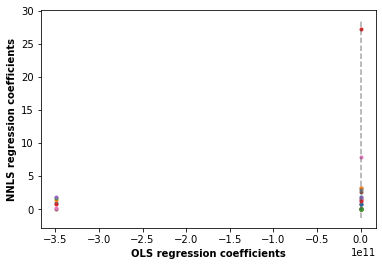

In [124]:
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
res = sm_ols_2(X_train, X_test, y_train, y_test)

In [125]:
show_ols_scores(reg_ols, X, y)

cv scores : [-3.83432510e+18  5.04374743e-01 -6.44837909e+19]
mean scores : -2.277270532620643e+19
std scores : 2.953570162365135e+19


In [126]:
display(coefs)
coefs = get_coefs(res)
display(coefs)

is_relevant = coefs['P>|t|'] < 0.05
display(coefs[is_relevant])
display(coefs[~is_relevant])

not_relevant_vars = list(coefs[~is_relevant].index)
print(not_relevant_vars)

ml_data_17 = ml_data.drop(columns=not_relevant_vars)
display(ml_data_17)

coef  std err       t  P>|t|  [0.025  \
                                                                            
const                             -2.3272    0.798  -2.916  0.004  -3.894   
ptype_Low-Rise Multifamily        -0.2372    0.458  -0.518  0.604  -1.136   
ptype_Mid-Rise Multifamily         0.2171    0.455   0.477  0.633  -0.676   
ptype_Small- and Mid-Sized Office -0.2390    0.491  -0.487  0.626  -1.202   
ptype_Other                        0.2412    0.481   0.501  0.616  -0.704   
...                                   ...      ...     ...    ...     ...   
_ua_Energy/Power Station           0.0000    0.000     NaN    NaN   0.000   
_ua_Vocat                          0.0000    0.000     NaN    NaN   0.000   
star_score                        -0.0083    0.002  -5.261  0.000  -0.011   
log(n_l)                          -0.2196    0.119  -1.838  0.066  -0.454   
log(a)                             1.1445    0.065  17.574  0.000   1.017   

                                   0.975]  
                                           
const                              -0.760  
ptype_Low-Rise Multifamily          0.661  
ptype_Mid-Rise Multifamily          1.111  
ptype_Small- and Mid-Sized Office   0.724  
ptype_Other                         1.186  
...                                   ...  
_ua_Energy/Power Station            0.000  
_ua_Vocat                           0.000  
star_score                         -0.005  
log(n_l)                            0.015  
log(a)                              1.272  

[95 rows x 6 columns]

coef  \
                                                                   
const                                              -4.770700e+00   
ptype_Low-Rise Multifamily                          6.712000e-01   
ptype_Mid-Rise Multifamily                          1.437900e+00   
ptype_High-Rise Multifamily                         1.977300e+00   
ptype_Senior Care Community                         8.028000e-01   
ptype_Mixed Use Property                            1.534000e+00   
ptype_Other                                        -8.138900e+00   
ptype_Residence Hall                               -3.055000e+00   
ptype_Hotel                                         1.045000e-11   
ptype_Small- and Mid-Sized Office                  -1.192000e-11   
ptype_University                                    1.507000e-12   
age                                                 1.520000e-02   
_ua_Multifamily Housing                             7.316000e-01   
_ua_Parking                                         3.708000e-01   
_ua_Senior Care Community                           1.514100e+00   
_ua_Retail Store                                    8.871000e-01   
_ua_Office                                          2.584400e+00   
_ua_Other                                           1.026490e+01   
_ua_Residence Hall/Dormitory                        6.330800e+00   
_ua_Hotel                                          -4.202000e-15   
_ua_Restaurant                                      2.474000e+00   
_ua_Supermarket/Grocery Store                       3.261200e+00   
_ua_Other - Lodging/Residential                     1.081010e+01   
_ua_Non-Refrigerated Warehouse                     -2.312000e-14   
_ua_Medical Office                                  2.344100e+01   
_ua_Other - Restaurant/Bar                         -7.615700e+00   
_ua_College/University                             -8.977000e-15   
_ua_Food Service                                    8.630900e+00   
_ua_Self-Storage Facility                           2.205400e+00   
_ua_Fitness Center/Health Club/Gym                  2.987770e+01   
_ua_Museum                                          4.206000e-14   
_ua_Hospital (General Medical & Surgical)           3.040000e-14   
_ua_Social/Meeting Hall                            -3.396300e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -2.250370e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                           -2.049620e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.348000e+00   
_ua_Lifestyle Center                               -3.150900e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -5.932200e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
star_score                                         -4.200000e-03   
log(n_l)                                           -4.953000e-01   
log(a)                                              1.249100e+00   

                                                         std err       t  \
                                                                           
const                          

coef  std err       t  P>|t|  [0.025  \
                                                                           
const                            -4.7707    1.692  -2.819  0.005  -8.098   
ptype_Other                      -8.1389    4.111  -1.980  0.048 -16.222   
age                               0.0152    0.002   9.237  0.000   0.012   
_ua_Multifamily Housing           0.7316    0.253   2.889  0.004   0.234   
_ua_Senior Care Community         1.5141    0.760   1.992  0.047   0.019   
_ua_Office                        2.5844    1.038   2.489  0.013   0.543   
_ua_Other                        10.2649    5.027   2.042  0.042   0.381   
_ua_Other - Lodging/Residential  10.8101    4.459   2.424  0.016   2.043   
star_score                       -0.0042    0.002  -2.160  0.031  -0.008   
log(n_l)                         -0.4953    0.238  -2.081  0.038  -0.963   
log(a)                            1.2491    0.080  15.592  0.000   1.092   

                                 0.975]  
                                         
const                            -1.444  
ptype_Other                      -0.056  
age                               0.018  
_ua_Multifamily Housing           1.230  
_ua_Senior Care Community         3.009  
_ua_Office                        4.626  
_ua_Other                        20.149  
_ua_Other - Lodging/Residential  19.577  
star_score                       -0.000  
log(n_l)                         -0.027  
log(a)                            1.407

coef  \
                                                                   
ptype_Low-Rise Multifamily                          6.712000e-01   
ptype_Mid-Rise Multifamily                          1.437900e+00   
ptype_High-Rise Multifamily                         1.977300e+00   
ptype_Senior Care Community                         8.028000e-01   
ptype_Mixed Use Property                            1.534000e+00   
ptype_Residence Hall                               -3.055000e+00   
ptype_Hotel                                         1.045000e-11   
ptype_Small- and Mid-Sized Office                  -1.192000e-11   
ptype_University                                    1.507000e-12   
_ua_Parking                                         3.708000e-01   
_ua_Retail Store                                    8.871000e-01   
_ua_Residence Hall/Dormitory                        6.330800e+00   
_ua_Hotel                                          -4.202000e-15   
_ua_Restaurant                                      2.474000e+00   
_ua_Supermarket/Grocery Store                       3.261200e+00   
_ua_Non-Refrigerated Warehouse                     -2.312000e-14   
_ua_Medical Office                                  2.344100e+01   
_ua_Other - Restaurant/Bar                         -7.615700e+00   
_ua_College/University                             -8.977000e-15   
_ua_Food Service                                    8.630900e+00   
_ua_Self-Storage Facility                           2.205400e+00   
_ua_Fitness Center/Health Club/Gym                  2.987770e+01   
_ua_Museum                                          4.206000e-14   
_ua_Hospital (General Medical & Surgical)           3.040000e-14   
_ua_Social/Meeting Hall                            -3.396300e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -2.250370e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                           -2.049620e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.348000e+00   
_ua_Lifestyle Center                               -3.150900e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -5.932200e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   

                                                         std err      t  \
                                                                          
ptype_Low-Rise Multifamily                          1.550000e+00  0.433   
ptype_Mid-Rise Multifamily                          1.564000e+00  0.919   
ptype_High-Rise Multifamily                         1.609000e+00  1.229   
ptype_Senior Care Community                         1.663000e+00  0.483   
ptype_Mixed Use Property                            1.344000e+00  1.141   
ptype_Residence Hall                                9.297000e+00 -0.329   
ptype_Hotel                                         1.610000e-11  0.648   
ptype_Small- and Mid-Sized Office                   2.440000e-11 -0.488   
ptype_University                                    2.520000e-12  0.598   
_ua_Parking                                         3.380000e-01  1.098   
_ua_Retail Store               

['ptype_Low-Rise Multifamily', 'ptype_Mid-Rise Multifamily', 'ptype_High-Rise Multifamily', 'ptype_Senior Care Community', 'ptype_Mixed Use Property', 'ptype_Residence Hall', 'ptype_Hotel', 'ptype_Small- and Mid-Sized Office', 'ptype_University', '_ua_Parking', '_ua_Retail Store', '_ua_Residence Hall/Dormitory', '_ua_Hotel', '_ua_Restaurant', '_ua_Supermarket/Grocery Store', '_ua_Non-Refrigerated Warehouse', '_ua_Medical Office', '_ua_Other - Restaurant/Bar', '_ua_College/University', '_ua_Food Service', '_ua_Self-Storage Facility', '_ua_Fitness Center/Health Club/Gym', '_ua_Museum', '_ua_Hospital (General Medical & Surgical)', '_ua_Social/Meeting Hall', '_ua_Bar/Nightclub', '_ua_Other/Specialty Hospital', '_ua_Worship Facility', '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)', '_ua_Food Sales', '_ua_Financial Office', '_ua_Bank Branch', '_ua_Strip Mall', '_ua_Fast Food Restaurant', '_ua_Other - Entertainment/Public Assembly', '_ua_Other - Public Services', '_ua_K-12 School'

ptype_Other  age  _ua_Multifamily Housing  _ua_Senior Care Community  \
id                                                                            
13             0.0  106                 0.881027                        0.0   
265            0.0   13                 0.698949                        0.0   
280            0.0  107                 0.968716                        0.0   
296            0.0   99                 1.000000                        0.0   
297            0.0    7                 0.769636                        0.0   
...            ...  ...                      ...                        ...   
50090          0.0    1                 1.116193                        0.0   
50092          0.0    1                 0.000000                        0.0   
50093          0.0    1                 0.910675                        0.0   
50095          0.0    1                 0.808226                        0.0   
50098          0.0    2                 0.872567                        0.0   

       _ua_Office  _ua_Other  _ua_Other - Lodging/Residential  star_score  \
id                                                                          
13        0.00000        0.0                         0.000000         1.0   
265       0.23432        0.0                         0.109887        85.0   
280       0.00000        0.0                         0.000000        34.0   
296       0.00000        0.0                         0.000000        15.0   
297       0.00000        0.0                         0.000000        54.0   
...           ...        ...                              ...         ...   
50090     0.00000        0.0                         0.000000        99.0   
50092     0.00000        0.0                         0.000000        69.0   
50093     0.00000        0.0                         0.000000        84.0   
50095     0.00000        0.0                         0.000000       100.0   
50098     0.00000        0.0                         0.000000        99.0   

       log(n_l)     log(a)     log(g)  
id                                     
13     1.945910  11.062128  11.925830  
265    2.079442  11.669476  12.540221  
280    1.945910  10.858537  11.886625  
296    1.609438  10.944065  10.830125  
297    1.945910  10.946323  10.995914  
...         ...        ...        ...  
50090  2.079442  11.063900  10.910715  
50092  2.079442  12.691580  13.056010  
50093  1.945910  11.362626   9.620461  
50095  2.079442  12.245947  11.481435  
50098  1.609438   9.915713   9.845858  

[1655 rows x 11 columns]

NNLS R2 score 0.48286485772046794
 OLS R2 score 0.5239419717113707
features : ['ptype_Self-Storage Facility' 'ptype_Hospital' 'age'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Other'
 '_ua_Other - Entertainment/Public Assembly'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Recreation'
 '_ua_Other - Mall' '_ua_Lifestyle Center' '_ua_Social/Meeting Hall'
 '_ua_Museum' '_ua_Other - Public Services' 'star_score' 'log(a)']
intercept (ols) : [-1.41023568]
intercept (nnls) : [-2.44064433]
coefficients (ols) : [[-1.56849873  1.62260766  0.00680919 -0.41971157 -0.24332077  0.56980267
   0.74056317  1.8222463   2.45872856  0.83470379  1.40120871  0.81198757
   1.88941826  1.3965683  -0.00746628  1.11531253]]
coefficients (nnls) : [[0.         1.84319614 0.00770497 0.         0.03206439 0.80881146
  0.92314905 2.30382785 2.81270949 1.11950514 1.62896271 1.0302759
  2.12292801 1.64232582 0.         1.13450296]]
SM OLS R2 verif 0.5319386831573698
SM OLS R2 score 0.523941971711372
                 

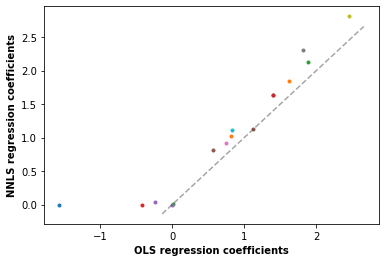

In [127]:
X, y = features_target_split(ml_data_16)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
sm_ols(X_train, X_test, y_train, y_test)
show_ols_scores(reg_ols, X, y)

## Config 18 : $\ln{g} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p, t_B)$

Config avec t_b non abstrait réduite au cas non résidentiel.

$\{t_B, t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a) : \log(g)\}$

$R^2_{18} \left(\{t_B, t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a):\log(e)\}\right)$
* $\mu = 0.4238855903576237$
* $\sigma = 0.14200661727297187$

#### Jeu de données

In [19]:
config_name = "{t_B, t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(r_data, config_name); # display(ml_data)

In [20]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


btype_Multifamily LR (1-4)  btype_Multifamily MR (5-9)  \
id                                                              
265                           0.0                         1.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
21210                         0.0                         1.0   
22839                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
25708                         1.0                         0.0   
26555                         1.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
30847                         0.0                         1.0   
33254                         1.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
50057                         0.0                         0.0   
50089                         1.0                         0.0   

       btype_Multifamily HR (10+)  btype_Campus  btype_NonResidential  \
id                                                                      
265                           0.0           0.0                   0.0   
19464                         0.0           0.0                   0.0   
20163                         1.0           0.0                   0.0   
21210                         0.0           0.0                   0.0   
22839                         1.0           0.0                   0.0   
23373                         1.0           0.0                   0.0   
23816                         0.0           0.0                   0.0   
23894                         0.0           0.0                   0.0   
25708                         0.0           0.0                   0.0   
26555                         0.0           0.0                   0.0   
27059                         0.0           0.0                   0.0   
27100                         1.0           0.0                   0.0   
30847                         0.0           0.0                   0.0   
33254                         0.0           0.0                   0.0   
49698                         0.0           0.0                   0.0   
49710                         0.0           0.0                   0.0   
50057                         1.0           0.0                   0.0   
50089                         0.0           0.0                   0.0   

       ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
265                           0.0                         1.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
21210                         0.0                         1.0   
22839                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
25708                         1.0                         0.0   
26555                         1.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
30847                         0.0                         1.0   
33254                         0.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
50057                         0.0                         0.0   
50089     

✔ No NA coefficient


In [21]:
from seattle_commons import features_target_split
from sklearn.model_selection import train_test_split

X, y = features_target_split(ml_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

In [22]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
def sm_ols_2(X_train, X_test, y_train, y_test):
    _X_train = sm.add_constant(X_train)
    _X_test = sm.add_constant(X_test)
    mod = sm.OLS(y_train, _X_train)
    res = mod.fit()
    y_verif_sm_ols = res.predict(_X_train)
    y_pred_sm_ols = res.predict(_X_test)
    r2_verif_sm_ols = r2_score(y_train, y_verif_sm_ols)
    print("SM OLS R2 verif", r2_verif_sm_ols)
    r2_score_sm_ols = r2_score(y_test, y_pred_sm_ols)
    print("SM OLS R2 score", r2_score_sm_ols)
    print(res.summary())
    return res

NNLS R2 score 0.4465795137119726
 OLS R2 score -8.45704168063815e+19
features : ['btype_Multifamily LR (1-4)' 'btype_Multifamily MR (5-9)'
 'btype_Multifamily HR (10+)' 'btype_Campus' 'btype_NonResidential'
 'ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_High-Rise Multifamily' 'ptype_Senior Care Community'
 'ptype_Mixed Use Property' 'ptype_Other' 'ptype_Residence Hall'
 'ptype_Hotel' 'ptype_Small- and Mid-Sized Office' 'ptype_University'
 'age' '_ua_Multifamily Housing' '_ua_Parking' '_ua_Senior Care Community'
 '_ua_Retail Store' '_ua_Office' '_ua_Other'
 '_ua_Residence Hall/Dormitory' '_ua_Hotel' '_ua_Restaurant'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Lodging/Residential'
 '_ua_Non-Refrigerated Warehouse' '_ua_Medical Office'
 '_ua_Other - Restaurant/Bar' '_ua_College/University' '_ua_Food Service'
 '_ua_Self-Storage Facility' '_ua_Fitness Center/Health Club/Gym'
 '_ua_Museum' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Social/Meeting Hall' '_ua_Bar/N

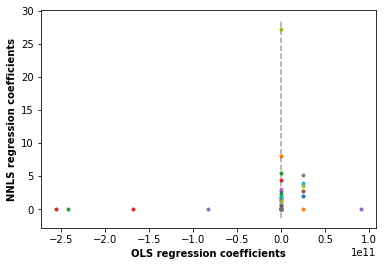

In [23]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results

reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
res = sm_ols_2(X_train, X_test, y_train, y_test)

In [24]:
from seattle_commons import show_ols_scores

show_ols_scores(reg_ols, X, y)

cv scores : [-7.78733810e+15  5.03135830e-01 -4.31527424e-01]
mean scores : -2595779365796447.5
std scores : 3670986384037568.0


In [25]:
import pandas as pd
def get_coefs(fit_sm_ols):
    _coefs = res.summary().tables[1]
    coefs = pd.DataFrame(_coefs.data)
    coefs.columns = list(coefs.loc[0])
    coefs = coefs.drop(index=0)
    coefs = coefs.set_index('')
    coefs = coefs.astype(float)
    return coefs

coefs = get_coefs(res)
display(coefs)

is_relevant = coefs['P>|t|'] < 0.05
display(coefs[is_relevant])
display(coefs[~is_relevant])

coef  \
                                                                   
const                                              -4.203200e+00   
btype_Multifamily LR (1-4)                         -8.730000e-01   
btype_Multifamily MR (5-9)                         -1.227800e+00   
btype_Multifamily HR (10+)                         -2.102400e+00   
btype_Campus                                       -7.098000e-12   
btype_NonResidential                               -3.833000e-12   
ptype_Low-Rise Multifamily                          5.801000e-01   
ptype_Mid-Rise Multifamily                          1.632100e+00   
ptype_High-Rise Multifamily                         2.878500e+00   
ptype_Senior Care Community                         1.284800e+00   
ptype_Mixed Use Property                            1.566300e+00   
ptype_Other                                        -7.547300e+00   
ptype_Residence Hall                               -4.597800e+00   
ptype_Hotel                                         9.295000e-13   
ptype_Small- and Mid-Sized Office                  -2.144000e-12   
ptype_University                                   -7.095000e-12   
age                                                 1.550000e-02   
_ua_Multifamily Housing                             7.336000e-01   
_ua_Parking                                         3.512000e-01   
_ua_Senior Care Community                           1.335400e+00   
_ua_Retail Store                                    8.281000e-01   
_ua_Office                                          2.674800e+00   
_ua_Other                                           9.520600e+00   
_ua_Residence Hall/Dormitory                        8.028700e+00   
_ua_Hotel                                           7.514000e-14   
_ua_Restaurant                                      2.512600e+00   
_ua_Supermarket/Grocery Store                       2.642700e+00   
_ua_Other - Lodging/Residential                     1.014310e+01   
_ua_Non-Refrigerated Warehouse                      4.012000e-15   
_ua_Medical Office                                  2.312420e+01   
_ua_Other - Restaurant/Bar                         -6.921800e+00   
_ua_College/University                             -1.389000e-14   
_ua_Food Service                                    8.521800e+00   
_ua_Self-Storage Facility                           2.010900e+00   
_ua_Fitness Center/Health Club/Gym                  3.150140e+01   
_ua_Museum                                          0.000000e+00   
_ua_Hospital (General Medical & Surgical)           0.000000e+00   
_ua_Social/Meeting Hall                            -3.024000e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -2.336310e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                           -2.052470e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.420300e+00   
_ua_Lifestyle Center                               -2.817200e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -2.191400e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
star_score                                      

coef  std err       t  P>|t|  [0.025  \
                                                                           
const                            -4.2032    1.439  -2.921  0.004  -7.032   
btype_Multifamily HR (10+)       -2.1024    0.747  -2.813  0.005  -3.572   
age                               0.0155    0.002   9.349  0.000   0.012   
_ua_Multifamily Housing           0.7336    0.253   2.894  0.004   0.235   
_ua_Office                        2.6748    1.040   2.572  0.010   0.630   
_ua_Other - Lodging/Residential  10.1431    4.494   2.257  0.025   1.306   
star_score                       -0.0044    0.002  -2.255  0.025  -0.008   
log(a)                            1.2661    0.081  15.639  0.000   1.107   

                                 0.975]  
                                         
const                            -1.374  
btype_Multifamily HR (10+)       -0.633  
age                               0.019  
_ua_Multifamily Housing           1.232  
_ua_Office                        4.720  
_ua_Other - Lodging/Residential  18.980  
star_score                       -0.001  
log(a)                            1.425

coef  \
                                                                   
btype_Multifamily LR (1-4)                         -8.730000e-01   
btype_Multifamily MR (5-9)                         -1.227800e+00   
btype_Campus                                       -7.098000e-12   
btype_NonResidential                               -3.833000e-12   
ptype_Low-Rise Multifamily                          5.801000e-01   
ptype_Mid-Rise Multifamily                          1.632100e+00   
ptype_High-Rise Multifamily                         2.878500e+00   
ptype_Senior Care Community                         1.284800e+00   
ptype_Mixed Use Property                            1.566300e+00   
ptype_Other                                        -7.547300e+00   
ptype_Residence Hall                               -4.597800e+00   
ptype_Hotel                                         9.295000e-13   
ptype_Small- and Mid-Sized Office                  -2.144000e-12   
ptype_University                                   -7.095000e-12   
_ua_Parking                                         3.512000e-01   
_ua_Senior Care Community                           1.335400e+00   
_ua_Retail Store                                    8.281000e-01   
_ua_Other                                           9.520600e+00   
_ua_Residence Hall/Dormitory                        8.028700e+00   
_ua_Hotel                                           7.514000e-14   
_ua_Restaurant                                      2.512600e+00   
_ua_Supermarket/Grocery Store                       2.642700e+00   
_ua_Non-Refrigerated Warehouse                      4.012000e-15   
_ua_Medical Office                                  2.312420e+01   
_ua_Other - Restaurant/Bar                         -6.921800e+00   
_ua_College/University                             -1.389000e-14   
_ua_Food Service                                    8.521800e+00   
_ua_Self-Storage Facility                           2.010900e+00   
_ua_Fitness Center/Health Club/Gym                  3.150140e+01   
_ua_Museum                                          0.000000e+00   
_ua_Hospital (General Medical & Surgical)           0.000000e+00   
_ua_Social/Meeting Hall                            -3.024000e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -2.336310e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                           -2.052470e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.420300e+00   
_ua_Lifestyle Center                               -2.817200e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -2.191400e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
log(n_l)                                           -3.484000e-01   

                                                         std err      t  \
                                                                          
btype_Multifamily LR (1-4)                          5.060000e-01 -1.724   
btype_Multifamily MR (5-9)                          7.760000e-01 -1.582   
btype_Campus                                        1.710000e-11 -0.415   
btype_NonRes

In [26]:
display(coefs)
coefs = get_coefs(res)
display(coefs)

is_relevant = coefs['P>|t|'] < 0.05
display(coefs[is_relevant])
display(coefs[~is_relevant])

not_relevant_vars = list(coefs[~is_relevant].index)
print(not_relevant_vars)

ml_data = ml_data.drop(columns=not_relevant_vars)
display(ml_data)

coef  \
                                                                   
const                                              -4.203200e+00   
btype_Multifamily LR (1-4)                         -8.730000e-01   
btype_Multifamily MR (5-9)                         -1.227800e+00   
btype_Multifamily HR (10+)                         -2.102400e+00   
btype_Campus                                       -7.098000e-12   
btype_NonResidential                               -3.833000e-12   
ptype_Low-Rise Multifamily                          5.801000e-01   
ptype_Mid-Rise Multifamily                          1.632100e+00   
ptype_High-Rise Multifamily                         2.878500e+00   
ptype_Senior Care Community                         1.284800e+00   
ptype_Mixed Use Property                            1.566300e+00   
ptype_Other                                        -7.547300e+00   
ptype_Residence Hall                               -4.597800e+00   
ptype_Hotel                                         9.295000e-13   
ptype_Small- and Mid-Sized Office                  -2.144000e-12   
ptype_University                                   -7.095000e-12   
age                                                 1.550000e-02   
_ua_Multifamily Housing                             7.336000e-01   
_ua_Parking                                         3.512000e-01   
_ua_Senior Care Community                           1.335400e+00   
_ua_Retail Store                                    8.281000e-01   
_ua_Office                                          2.674800e+00   
_ua_Other                                           9.520600e+00   
_ua_Residence Hall/Dormitory                        8.028700e+00   
_ua_Hotel                                           7.514000e-14   
_ua_Restaurant                                      2.512600e+00   
_ua_Supermarket/Grocery Store                       2.642700e+00   
_ua_Other - Lodging/Residential                     1.014310e+01   
_ua_Non-Refrigerated Warehouse                      4.012000e-15   
_ua_Medical Office                                  2.312420e+01   
_ua_Other - Restaurant/Bar                         -6.921800e+00   
_ua_College/University                             -1.389000e-14   
_ua_Food Service                                    8.521800e+00   
_ua_Self-Storage Facility                           2.010900e+00   
_ua_Fitness Center/Health Club/Gym                  3.150140e+01   
_ua_Museum                                          0.000000e+00   
_ua_Hospital (General Medical & Surgical)           0.000000e+00   
_ua_Social/Meeting Hall                            -3.024000e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -2.336310e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                           -2.052470e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.420300e+00   
_ua_Lifestyle Center                               -2.817200e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -2.191400e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
star_score                                      

coef  \
                                                                   
const                                              -4.203200e+00   
btype_Multifamily LR (1-4)                         -8.730000e-01   
btype_Multifamily MR (5-9)                         -1.227800e+00   
btype_Multifamily HR (10+)                         -2.102400e+00   
btype_Campus                                       -7.098000e-12   
btype_NonResidential                               -3.833000e-12   
ptype_Low-Rise Multifamily                          5.801000e-01   
ptype_Mid-Rise Multifamily                          1.632100e+00   
ptype_High-Rise Multifamily                         2.878500e+00   
ptype_Senior Care Community                         1.284800e+00   
ptype_Mixed Use Property                            1.566300e+00   
ptype_Other                                        -7.547300e+00   
ptype_Residence Hall                               -4.597800e+00   
ptype_Hotel                                         9.295000e-13   
ptype_Small- and Mid-Sized Office                  -2.144000e-12   
ptype_University                                   -7.095000e-12   
age                                                 1.550000e-02   
_ua_Multifamily Housing                             7.336000e-01   
_ua_Parking                                         3.512000e-01   
_ua_Senior Care Community                           1.335400e+00   
_ua_Retail Store                                    8.281000e-01   
_ua_Office                                          2.674800e+00   
_ua_Other                                           9.520600e+00   
_ua_Residence Hall/Dormitory                        8.028700e+00   
_ua_Hotel                                           7.514000e-14   
_ua_Restaurant                                      2.512600e+00   
_ua_Supermarket/Grocery Store                       2.642700e+00   
_ua_Other - Lodging/Residential                     1.014310e+01   
_ua_Non-Refrigerated Warehouse                      4.012000e-15   
_ua_Medical Office                                  2.312420e+01   
_ua_Other - Restaurant/Bar                         -6.921800e+00   
_ua_College/University                             -1.389000e-14   
_ua_Food Service                                    8.521800e+00   
_ua_Self-Storage Facility                           2.010900e+00   
_ua_Fitness Center/Health Club/Gym                  3.150140e+01   
_ua_Museum                                          0.000000e+00   
_ua_Hospital (General Medical & Surgical)           0.000000e+00   
_ua_Social/Meeting Hall                            -3.024000e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -2.336310e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                           -2.052470e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.420300e+00   
_ua_Lifestyle Center                               -2.817200e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -2.191400e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
star_score                                      

coef  std err       t  P>|t|  [0.025  \
                                                                           
const                            -4.2032    1.439  -2.921  0.004  -7.032   
btype_Multifamily HR (10+)       -2.1024    0.747  -2.813  0.005  -3.572   
age                               0.0155    0.002   9.349  0.000   0.012   
_ua_Multifamily Housing           0.7336    0.253   2.894  0.004   0.235   
_ua_Office                        2.6748    1.040   2.572  0.010   0.630   
_ua_Other - Lodging/Residential  10.1431    4.494   2.257  0.025   1.306   
star_score                       -0.0044    0.002  -2.255  0.025  -0.008   
log(a)                            1.2661    0.081  15.639  0.000   1.107   

                                 0.975]  
                                         
const                            -1.374  
btype_Multifamily HR (10+)       -0.633  
age                               0.019  
_ua_Multifamily Housing           1.232  
_ua_Office                        4.720  
_ua_Other - Lodging/Residential  18.980  
star_score                       -0.001  
log(a)                            1.425

coef  \
                                                                   
btype_Multifamily LR (1-4)                         -8.730000e-01   
btype_Multifamily MR (5-9)                         -1.227800e+00   
btype_Campus                                       -7.098000e-12   
btype_NonResidential                               -3.833000e-12   
ptype_Low-Rise Multifamily                          5.801000e-01   
ptype_Mid-Rise Multifamily                          1.632100e+00   
ptype_High-Rise Multifamily                         2.878500e+00   
ptype_Senior Care Community                         1.284800e+00   
ptype_Mixed Use Property                            1.566300e+00   
ptype_Other                                        -7.547300e+00   
ptype_Residence Hall                               -4.597800e+00   
ptype_Hotel                                         9.295000e-13   
ptype_Small- and Mid-Sized Office                  -2.144000e-12   
ptype_University                                   -7.095000e-12   
_ua_Parking                                         3.512000e-01   
_ua_Senior Care Community                           1.335400e+00   
_ua_Retail Store                                    8.281000e-01   
_ua_Other                                           9.520600e+00   
_ua_Residence Hall/Dormitory                        8.028700e+00   
_ua_Hotel                                           7.514000e-14   
_ua_Restaurant                                      2.512600e+00   
_ua_Supermarket/Grocery Store                       2.642700e+00   
_ua_Non-Refrigerated Warehouse                      4.012000e-15   
_ua_Medical Office                                  2.312420e+01   
_ua_Other - Restaurant/Bar                         -6.921800e+00   
_ua_College/University                             -1.389000e-14   
_ua_Food Service                                    8.521800e+00   
_ua_Self-Storage Facility                           2.010900e+00   
_ua_Fitness Center/Health Club/Gym                  3.150140e+01   
_ua_Museum                                          0.000000e+00   
_ua_Hospital (General Medical & Surgical)           0.000000e+00   
_ua_Social/Meeting Hall                            -3.024000e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -2.336310e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                           -2.052470e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.420300e+00   
_ua_Lifestyle Center                               -2.817200e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -2.191400e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
log(n_l)                                           -3.484000e-01   

                                                         std err      t  \
                                                                          
btype_Multifamily LR (1-4)                          5.060000e-01 -1.724   
btype_Multifamily MR (5-9)                          7.760000e-01 -1.582   
btype_Campus                                        1.710000e-11 -0.415   
btype_NonRes

['btype_Multifamily LR (1-4)', 'btype_Multifamily MR (5-9)', 'btype_Campus', 'btype_NonResidential', 'ptype_Low-Rise Multifamily', 'ptype_Mid-Rise Multifamily', 'ptype_High-Rise Multifamily', 'ptype_Senior Care Community', 'ptype_Mixed Use Property', 'ptype_Other', 'ptype_Residence Hall', 'ptype_Hotel', 'ptype_Small- and Mid-Sized Office', 'ptype_University', '_ua_Parking', '_ua_Senior Care Community', '_ua_Retail Store', '_ua_Other', '_ua_Residence Hall/Dormitory', '_ua_Hotel', '_ua_Restaurant', '_ua_Supermarket/Grocery Store', '_ua_Non-Refrigerated Warehouse', '_ua_Medical Office', '_ua_Other - Restaurant/Bar', '_ua_College/University', '_ua_Food Service', '_ua_Self-Storage Facility', '_ua_Fitness Center/Health Club/Gym', '_ua_Museum', '_ua_Hospital (General Medical & Surgical)', '_ua_Social/Meeting Hall', '_ua_Bar/Nightclub', '_ua_Other/Specialty Hospital', '_ua_Worship Facility', '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)', '_ua_Food Sales', '_ua_Financial Office', '

btype_Multifamily HR (10+)  age  _ua_Multifamily Housing  _ua_Office  \
id                                                                            
13                            0.0  106                 0.881027     0.00000   
265                           0.0   13                 0.698949     0.23432   
280                           0.0  107                 0.968716     0.00000   
296                           0.0   99                 1.000000     0.00000   
297                           0.0    7                 0.769636     0.00000   
...                           ...  ...                      ...         ...   
50090                         0.0    1                 1.116193     0.00000   
50092                         0.0    1                 0.000000     0.00000   
50093                         0.0    1                 0.910675     0.00000   
50095                         0.0    1                 0.808226     0.00000   
50098                         0.0    2                 0.872567     0.00000   

       _ua_Other - Lodging/Residential  star_score     log(a)     log(g)  
id                                                                        
13                            0.000000         1.0  11.062128  11.925830  
265                           0.109887        85.0  11.669476  12.540221  
280                           0.000000        34.0  10.858537  11.886625  
296                           0.000000        15.0  10.944065  10.830125  
297                           0.000000        54.0  10.946323  10.995914  
...                                ...         ...        ...        ...  
50090                         0.000000        99.0  11.063900  10.910715  
50092                         0.000000        69.0  12.691580  13.056010  
50093                         0.000000        84.0  11.362626   9.620461  
50095                         0.000000       100.0  12.245947  11.481435  
50098                         0.000000        99.0   9.915713   9.845858  

[1655 rows x 8 columns]

NNLS R2 score 0.5081151834292325
 OLS R2 score 0.5139541430173709
features : ['btype_Multifamily HR (10+)' 'age' '_ua_Multifamily Housing' '_ua_Office'
 '_ua_Other - Lodging/Residential' 'star_score' 'log(a)']
intercept (ols) : [-6.13109281]
intercept (nnls) : [-6.19595559]
coefficients (ols) : [[ 0.07321029  0.01496805  0.24566885  2.51751339  1.72969767 -0.00339269
   1.43214036]]
coefficients (nnls) : [[0.19161376 0.01478093 0.25414219 2.42637476 1.70921073 0.
  1.41580636]]
SM OLS R2 verif 0.5624562736060608
SM OLS R2 score 0.5139541430173711
                            OLS Regression Results                            
Dep. Variable:                 log(g)   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     74.37
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           8.71e-69
Time:                        16:48:07   Log-Likeliho

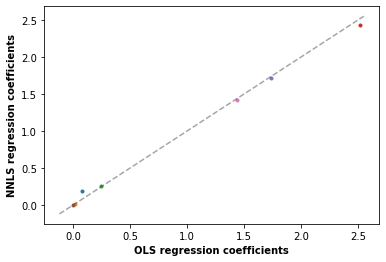

In [27]:
X, y = features_target_split(ml_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
sm_ols_2(X_train, X_test, y_train, y_test)
show_ols_scores(reg_ols, X, y)